<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Netherlands/Unilever/Unilever_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "UNA.AS"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close    Volume
Date                                                       
2009-01-02  17.60  18.01  17.34  17.99      12.38   4118227
2009-01-05  18.10  18.10  17.70  18.00      12.39   5947068
2009-01-06  18.15  18.37  17.89  18.01      12.40   6820561
2009-01-07  17.95  17.95  17.40  17.65      12.14   6905543
2009-01-08  17.57  17.82  17.26  17.74      12.21   5279969
...           ...    ...    ...    ...        ...       ...
2018-12-21  47.72  47.96  46.88  47.96      46.84  11104086
2018-12-24  47.60  47.80  46.99  46.99      45.89   1085623
2018-12-27  47.49  47.59  46.06  46.50      45.41   4130227
2018-12-28  46.56  47.19  46.56  46.88      45.79   2990853
2018-12-31  46.74  47.42  46.66  47.42      46.31   1095713

[2558 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2558.000000  2558.000000  2558.000000  2558.000000  2558.000000  2.558000e+03
mean     32.336998    32.600356    32.080997    32.352127    27.725043  5.059662e+06
std      10.006746    10.066808     9.955280    10.010965    11.102579  2.415643e+06
min      13.740000    13.950000    13.450000    13.590000     9.350000  2.936270e+05
25%      23.132500    23.375000    22.900000    23.132500    17.360000  3.580926e+06
50%      30.330000    30.575000    30.115000    30.335000    25.125000  4.540038e+06
75%      40.267500    40.670000    39.967500    40.365000    35.897500  5.897538e+06
max      51.830000    52.310000    51.700000    52.250000    49.030000  3.156753e+07

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close    Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2009-03-13  14.38  14.49  14.10  14.16       9.74   8612200   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  14.007007  14.597813  13.503520  13.998417  14.258930  14.342772      14.105      14.010  14.833284  14.12000  14.124327  14.0420  14.113889  14.12000  14.196667  14.905865               14.612138                 14.12000               13.627862               14.858207                 14.12000               13.381793               15.104276                 14.12000               13.135724               15.350345                 14.12000               12.889655  14.258930  14.180667  14.779432               14.751068                14.258930               13.766792               14.997137                14.258930               13.520722               15.243206                14.258930               13.274653               15.489275                14.258930   
2009-03-16  14.50  14.65  14.38  14.65      10.08   6348626   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  14.039157  14.583847  13.562709  14.210806  14.345834  14.345398      14.160      14.050  14.722621  14.13375  14.406335  14.0930  14.231667  14.13375  14.405000  14.811420               14.675685                 14.13375               13.591815               14.946653                 14.13375               13.320847               15.217620                 14.13375               13.049880               15.488588                 14.13375               12.778912  14.345834  14.497144  14.691527               14.887769                14.345834               13.803899               15.158737                14.345834               13.532931               15.429705                14.345834               13.261964               15.700672                14.345834   
2009-03-17  14.52  14.55  14.19  14.30   

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2.508000e+03  2508.000000  2508.000000  2508.000000    2508.000000   2508.000000     2508.000000     2508.000000       2508.000000  2508.000000  2508.000000  2508.000000  2508.000000   2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000  2508.000000             2508.000000              2508.000000             2508.000000             2508.000000              2508.000000             2508.000000             2508.000000              2508.000000             2508.000000             2508.000000              2508.000000             2508.000000  2508.000000  2508.000000  2508.000000             2508.000000              2508.000000             2508.000000             2508.000000              2508.000000             2508.000000             2508.000000   
mean     32.653138    32.917867    32.397827    32.669749    28.052516  4.977926e+06    15.785486     1.998006   186.278708      30.463317      0.033094        0.027911        0.010367          0.007974     6.626396     2.540670    27.013955     1.998006      2.013158    27.013955    32.635906    32.530057     3.235783    32.670055    32.623409    32.594223    32.619926    32.594392    32.493084    32.623586    32.670050    32.623680    32.639047    32.623586    32.661374    32.530112               33.361509                32.623586               31.885662               33.730471                32.623586               31.516700               34.099433                32.623586               31.147738               34.468394                32.623586               30.778777    32.623409    32.660438    32.544038               33.361332                32.623409               31.885485               33.730294                32.623409               31.516523               34.099256   
std       9.847842     9.907784     9.793402     9.849732    10.964458  2.327267e+06     8.737829     1.408701   103.689863       0.785698      0.178918        0.164750        0.101309          0.088961     3.397654     1.106757    14.830494     1.408701      1.412600    14.830494     9.868562     9.871394    33.815496     9.854514     9.843183     9.821908     9.847930     9.839048     9.850939     9.848816     9.851803     9.851141     9.847315     9.848816     9.849503     9.841326               10.040706                 9.848816                9.680802               10.145187                 9.848816                9.606146               10.255130                 9.848816                9.537924               10.370362                 9.848816                9.476275     9.843183     9.847924     9.842934               10.035520                 9.843183                9.674718               10.140223                 9.843183                9.599837               10.250386   
min      13.750000    13.950000    13.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close    Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2009-03-13  0.016544  0.014077  0.016993  0.014744   0.009829   8612200   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.000000  0.005247  0.639966  0.006412  0.006990  0.001219    0.000000    0.000000  0.035597  0.000876  0.010023  0.001030  0.004025  0.000876  0.015516  0.016095                0.000000                 0.000876                0.009183                0.000000                 0.000876                0.015496                0.000000                 0.000876                0.021698                0.000000                 0.000876                0.027791  0.006990  0.013293  0.013984                0.001830                 0.006990                0.012256                0.000655                 0.006990                0.015445                0.000000                 0.006990                0.020948                0.001981                 0.006990   
2009-03-16  0.019695  0.018248  0.024314  0.027419   0.018397   6348626   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.000854  0.004862  0.640541  0.011964  0.009313  0.001290    0.001485    0.001079  0.032749  0.001247  0.017347  0.002393  0.007156  0.001247  0.020934  0.013488                0.001612                 0.001247                0.008209                0.002149                 0.001247                0.013863                0.002640                 0.001247                0.019417                0.003091                 0.001247                0.024874  0.009313  0.021529  0.011566                0.005374                 0.009313                0.013261                0.004671                 0.009313                0.015774                0.004441                 0.009313                0.020609                0.006801                 0.009313   
2009-03-17  0.020221  0.015641  0.019346  0.0183

140242

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpa5vop043
  JVM stdout: /tmp/tmpa5vop043/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpa5vop043/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 15 days
H2O cluster name:           H2O_from_python_unknownUser_yr5hs0
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_020053_mod...  0.664973   0.924880              0.357728  0.554782  0.307783
1  DeepLearning_grid_1_AutoML_20190903_020053_mod...  0.569628   0.679712              0.435293  0.493362  0.243406
2  DeepLearning_grid_1_AutoML_20190903_020053_mod...  0.558325  10.005008              0.426657  0.651095  0.423925
3  DeepLearning_grid_1_AutoML_20190903_020053_mod...  0.558007  11.036692              0.423387  0.641931  0.412075
4  DeepLearning_grid_1_AutoML_20190903_020053_mod...  0.544799   8.490898              0.459487  0.669295  0.447956
5  DeepLearning_grid_1_AutoML_20190903_020053_mod...  0.542767  10.765838              0.471679  0.682890  0.466339
6              DeepLearning_1_AutoML_20190903_020053  0.540672  13.984581              0.447009  0.679576  0.461824
7  DeepLearning_grid_1_AutoML_20190903_020053_mod...  0.532195  15.979292              0.467647  0.699970  0.489959
8  DeepLearning_grid_1_AutoML_20190903_020053_mod...  0.498095   1.253589              0.491935  0.569549  0.324387
9  DeepLearning_grid_1_AutoML_20190903_020053_mod...  0.494412   1.074769              0.483585  0.554767  0.307766

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.003783
1           CDLCLOSINGMARUBOZU             0.611811           0.611811    0.002315
2                          SUB             0.533138           0.533138    0.002017
3                          DIV             0.502738           0.502738    0.001902
4                 STOCHF_fastk             0.435457           0.435457    0.001647
...                        ...                  ...                ...         ...
1036   BBANDS_lowerband_24_2_3             0.215189           0.215189    0.000814
1037  BBANDS_middleband_20_7_5             0.213561           0.213561    0.000808
1038                      Open             0.211966           0.211966    0.000802
1039  BBANDS_middleband_14_4_5             0.211829           0.211829    0.000801
1040  BBANDS_middleband_20_3_5             0.209010           0.209010    0.000791

[1041 rows x 4 columns]

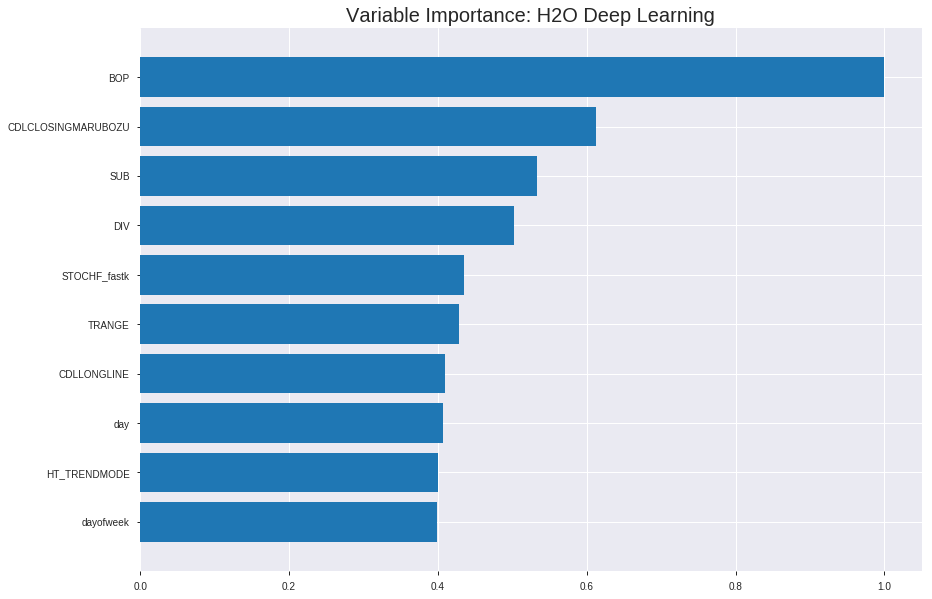

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_020053_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24208599119462473
RMSE: 0.492022348267459
LogLoss: 0.7206701318768287
Mean Per-Class Error: 0.3442103268716883
AUC: 0.6897835446925003
pr_auc: 0.697128747026581
Gini: 0.3795670893850005
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20121278202356777: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      257  558   0.6847   (558.0/815.0)
1      99   840   0.1054   (99.0/939.0)
Total  356  1398  0.3746   (657.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.201213     0.71887   318
max f2                       0.0256036    0.855757  389
max f0point5                 0.563894     0.680294  190
max accuracy                 0.563894     0.656784  190
max precision                0.991759     1         0
max recall                   0.00446992   1         398
max specificity              0.991759     1         0
max absolute_mcc             0.563894     0.311192  190
max min_per_class_accuracy   0.583205     0.648562  183
max mean_per_class_accuracy  0.563894     0.65579   190

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 54.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.977428           1.6604    1.6604             0.888889         0.983982   0.888889                    0.983982            0.0170394       0.0170394                  66.0395   66.0395
    2        0.0205245                   0.970966           1.55662   1.60851            0.833333         0.974044   0.861111                    0.979013            0.0159744       0.0330138                  55.6621   60.8508
    3        0.0302166                   0.965154           1.64819   1.62123            0.882353         0.968215   0.867925                    0.975549            0.0159744       0.0489883                  64.8186   62.1235
    4        0.0404789                   0.957285           1.45285   1.57854            0.777778         0.960036   0.84507                     0.971616            0.0149095       0.0638978                  45.2846   57.8545
    5        0.050171                    0.951004           1.31855   1.52832            0.705882         0.954901   0.818182                    0.968387            0.0127796       0.0766773                  31.8549   52.8318
    6        0.100342                    0.923401           1.37973   1.45403            0.738636         0.937844   0.778409                    0.953116            0.0692226       0.1459                     37.9732   45.4025
    7        0.149943                    0.897153           1.28824   1.39918            0.689655         0.910763   0.749049                    0.939106            0.0638978       0.209798                   28.8238   39.9183
    8        0.200114                    0.864477           1.16747   1.34109            0.625            0.881061   0.717949                    0.924553            0.0585729       0.268371                   16.7465   34.1088
    9        0.299886                    0.793697           1.30222   1.32816            0.697143         0.828532   0.711027                    0.892607            0.129925        0.398296                   30.2224   32.8158
    10       0.400228                    0.692517           1.19931   1.29585            0.642045         0.742667   0.693732                    0.855015            0.120341        0.518637                   19.9305   29.5853
    11       0.5                         0.590115           1.20616   1.27796            0.645714         0.643233   0.684151                    0.812755            0.120341        0.638978                   20.6159   27.7955
    12       0.599772                    0.463185           0.917961  1.21807            0.491429         0.527504   0.652091                    0.765304            0.0915868       0.730564                   -8.20386  21.807
    13       0.700114                    0.311766           0.880906  1.16975            0.471591         0.388153   0.626221                    0.71125             0.0883919       0.818956                   -11.9094  16.9747
    14       0.799886                    0.197304           0.768526  1.1197             0.411429         0.256005   0.59943                     0.654466            0.0766773       0.895634                   -23.1474  11.9702
    15       0.899658                    0.0846247          0.608416  1.063              0.325714         0.138013   0.569075                    0.597191            0.0607029       0.956337                   -39.1584  6.30002
    16       1                           0.000444516        0.435146  1                  0.232955         0.0435592  0.535348                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.29573935631685205
RMSE: 0.5438192312863274
LogLoss: 1.337929809257471
Mean Per-Class Error: 0.3784419339974896
AUC: 0.6294310183199072
pr_auc: 0.5755874618690303
Gini: 0.25886203663981444
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0002580498177273095: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    241  0.9918   (241.0/243.0)
1      0    259  0        (0.0/259.0)
Total  2    500  0.4801   (241.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00025805   0.682477  398
max f2                       0.00025805   0.843099  398
max f0point5                 0.234237     0.635286  258
max accuracy                 0.234237     0.625498  258
max precision                0.999284     0.71875   3
max recall                   0.00025805   1         398
max specificity              0.999981     0.967078  0
max absolute_mcc             0.234237     0.251299  258
max min_per_class_accuracy   0.372403     0.606178  202
max mean_per_class_accuracy  0.234237     0.621558  258

Gains/Lift Table: Avg response rate: 51.59 %, avg score: 43.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   1                  1.29215   1.29215            0.666667         1           0.666667                    1                   0.015444        0.015444                   29.2149   29.2149
    2        0.0219124                   0.999998           0.77529   1.05721            0.4              0.999999    0.545455                    1                   0.00772201      0.023166                   -22.471   5.72131
    3        0.0318725                   0.999995           1.55058   1.21139            0.8              0.999996    0.625                       0.999999            0.015444        0.03861                    55.0579   21.139
    4        0.0418327                   0.999932           1.55058   1.29215            0.8              0.99995     0.666667                    0.999987            0.015444        0.0540541                  55.0579   29.2149
    5        0.0517928                   0.999729           1.55058   1.34185            0.8              0.999832    0.692308                    0.999957            0.015444        0.0694981                  55.0579   34.1847
    6        0.101594                    0.991655           0.930347  1.14013            0.48             0.997209    0.588235                    0.99861             0.046332        0.11583                    -6.96525  14.0132
    7        0.151394                    0.93349            1.16293   1.14763            0.6              0.972057    0.592105                    0.989875            0.0579151       0.173745                   16.2934   14.7633
    8        0.201195                    0.826373           1.70564   1.28575            0.88             0.877779    0.663366                    0.962129            0.0849421       0.258687                   70.5637   28.5753
    9        0.300797                    0.615793           1.24046   1.27076            0.64             0.714155    0.655629                    0.880018            0.123552        0.382239                   24.0463   27.0756
    10       0.400398                    0.501603           1.2017    1.25358            0.62             0.553729    0.646766                    0.798852            0.119691        0.501931                   20.1699   25.3578
    11       0.5                         0.369252           1.04664   1.21236            0.54             0.43438     0.625498                    0.726248            0.104247        0.606178                   4.66409   21.2355
    12       0.599602                    0.254059           1.00788   1.17839            0.52             0.310099    0.607973                    0.65712             0.100386        0.706564                   0.787645  17.8389
    13       0.699203                    0.16904            0.891583  1.13753            0.46             0.213428    0.586895                    0.593916            0.0888031       0.795367                   -10.8417  13.7533
    14       0.798805                    0.0869769          0.581467  1.0682             0.3              0.12514     0.551122                    0.535465            0.0579151       0.853282                   -41.8533  6.81982
    15       0.898406                    0.0265906          0.658996  1.02283            0.34             0.0491453   0.527716                    0.481549            0.0656371       0.918919                   -34.1004  2.28321
    16       1                           6.05711e-07        0.798092  1                  0.411765         0.00804715  0.515936  


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:02:26  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 02:02:27  1 min 28.617 sec  368 obs/sec       0.275941  1             484        0.605614         5.41451             -0.474443      0.608735        0.279813           1.22671          0.399658                         0.651518           9.01018               -0.699629        0.58576           0.236143             1.05802            0.432271
    2019-09-03 02:02:37  1 min 38.178 sec  418 obs/sec       2.37514   9             4166       0.532905         1.13874             -0.141658      0.720929        0.718303           1.6604           0.388255                         0.622801           7.44983               -0.5531          0.594356          0.316215             1.0623             0.390438
    2019-09-03 02:02:46  1 min 47.475 sec  429 obs/sec       4.48974   17            7875       0.500897         0.750179            -0.00863162    0.680762        0.685837           1.45285          0.36431                          0.596458           6.7011                -0.424496        0.589494          0.344297             1.03721            0.410359
    2019-09-03 02:02:56  1 min 57.462 sec  438 obs/sec       6.8626    26            12037      0.492022         0.72067             0.0267921      0.689784        0.697129           1.6604           0.374572                         0.543819           1.33793               -0.18416         0.629431          0.575587             1.29215            0.48008
    2019-09-03 02:03:05  2 min  6.578 sec  442 obs/sec       8.97777   34            15747      0.561153         1.05683             -0.265895      0.685586        0.65075            1.55662          0.350627                         0.691898           8.29262               -0.91684         0.561284          0.315147             1.03648            0.448207
    2019-09-03 02:03:15  2 min 16.349 sec  449 obs/sec       11.3968   43            19990      0.490288         0.734823            0.0336414      0.71058         0.721257           1.76417          0.376283                         0.578413           6.30671               -0.339605        0.582233          0.350275             1.05616            0.414343
    2019-09-03 02:03:24  2 min 25.686 sec  457 obs/sec       13.7805   52            24171      0.446725         0.588715            0.197739       0.764691        0.77055            1.76417          0.293615                         0.581586           6.76442               -0.354344        0.59527           0.328782             1.04206            0.414343
    2019-09-03 02:03:25  2 min 26.724 sec  456 obs/sec       13.7805   52            24171      0.492022         0.72067             0.0267921      0.689784        0.697129           1.6604           0.374572                         0.543819           1.33793               -0.18416         0.629431          0.575587             1.29215            0.48008

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.0037831440215389837
CDLCLOSINGMARUBOZU        0.6118108034133911     0.6118108034133911   0.002314568383246333
SUB                       0.5331379175186157     0.5331379175186157   0.002016937525316295
DIV                       0.5027384757995605     0.5027384757995605   0.0019019320591187286
STOCHF_fastk              0.4354568421840668     0.4354568421840668   0.001647395949146897
---                       ---                    ---                  ---
BBANDS_lowerband_24_2_3   0.21518917381763458    0.21518917381763458  0.0008140916364280975
BBANDS_middleband_20_7_5  0.2135610431432724     0.2135610431432724   0.0008079321836011
Open                      0.2119659185409546     0.2119659185409546   0.0008018975974982316
BBANDS_middleband_14_4_5  0.21182912588119507    0.21182912588119507  0.0008013800911652719
BBANDS_middleband_20_3_5  0.2090102881193161     0.2090102881193161   0.0007907160219387312


See the whole table with table.as_data_frame()


('accuracy', 0.6454183266932271)

('F1', 0.7210031347962383)

('auc', 0.6649733299466598)

('logloss', 0.9248801618793312)

('mean_per_class_error', 0.3576327152654306)

('rmse', 0.554781702953208)

('mse', 0.3077827379316615)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


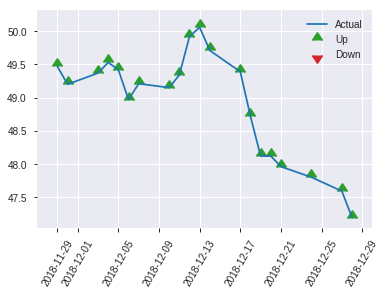


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3077827379316615
RMSE: 0.554781702953208
LogLoss: 0.9248801618793312
Mean Per-Class Error: 0.3576327152654306
AUC: 0.6649733299466598
pr_auc: 0.6162726156372899
Gini: 0.3299466598933196
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06926173151994588: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      47   77   0.621    (77.0/124.0)
1      12   115  0.0945   (12.0/127.0)
Total  59   192  0.3546   (89.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0692617    0.721003  191
max f2                       0.0194511    0.849057  233
max f0point5                 0.0738056    0.642616  189
max accuracy                 0.0738056    0.645418  189
max precision                0.721364     0.708333  23
max recall                   0.013975     1         241
max specificity              0.993784     0.991935  0
max absolute_mcc             0.0692617    0.335495  191
max min_per_class_accuracy   0.183382     0.582677  122
max mean_per_class_accuracy  0.0738056    0.642367  189

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 28.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.972193           1.31759   1.31759            0.666667         0.986859   0.666667                    0.986859            0.015748        0.015748                   31.7585   31.7585
    2        0.0239044                   0.944587           0.658793  0.988189           0.333333         0.958565   0.5                         0.972712            0.00787402      0.023622                   -34.1207  -1.1811
    3        0.0318725                   0.911833           0.988189  0.988189           0.5              0.927234   0.5                         0.961343            0.00787402      0.0314961                  -1.1811   -1.1811
    4        0.0438247                   0.885308           1.97638   1.2577             1                0.894232   0.636364                    0.94304             0.023622        0.0551181                  97.6378   25.7695
    5        0.0517928                   0.860386           0.988189  1.21623            0.5              0.866729   0.615385                    0.9313              0.00787402      0.0629921                  -1.1811   21.6233
    6        0.103586                    0.718233           1.52029   1.36826            0.769231         0.778099   0.692308                    0.8547              0.0787402       0.141732                   52.0291   36.8262
    7        0.151394                    0.632349           1.15289   1.30025            0.583333         0.673185   0.657895                    0.797379            0.0551181       0.19685                    15.2887   30.0249
    8        0.203187                    0.553125           1.36826   1.31759            0.692308         0.590391   0.666667                    0.744618            0.0708661       0.267717                   36.8262   31.7585
    9        0.302789                    0.377144           1.34394   1.32625            0.68             0.46262    0.671053                    0.651855            0.133858        0.401575                   34.3937   32.6254
    10       0.40239                     0.257266           1.10677   1.27193            0.56             0.308509   0.643564                    0.566869            0.110236        0.511811                   10.6772   27.1926
    11       0.501992                    0.173702           0.711496  1.16073            0.36             0.21463    0.587302                    0.49698             0.0708661       0.582677                   -28.8504  16.073
    12       0.601594                    0.130838           1.34394   1.19106            0.68             0.153171   0.602649                    0.440058            0.133858        0.716535                   34.3937   19.1062
    13       0.701195                    0.0915554          1.10677   1.17909            0.56             0.109121   0.596591                    0.39305             0.110236        0.826772                   10.6772   17.9089
    14       0.800797                    0.0504211          1.02772   1.16026            0.52             0.0713286  0.587065                    0.353035            0.102362        0.929134                   2.77165   16.0262
    15       0.900398                    0.0301767          0.395276  1.07564            0.2              0.0395821  0.544248                    0.318361            0.0393701       0.968504                   -60.4724  7.56393
    16       1                           0.000445898        0.31622   1                  0.16             0.0152078  0.505976                    

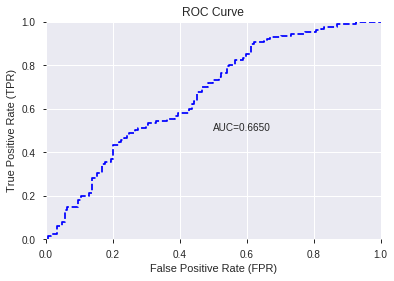

This function is available for GLM models only


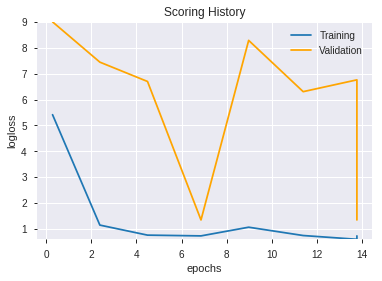

--2019-09-03 02:23:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.100.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.100.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  55.8MB/s    in 6.2s    

2019-09-03 02:24:01 (56.3 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_020053_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_020053_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_83a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_022411_model_9  0.770066  0.573405              0.292831  0.443153  0.196385
1  DeepLearning_grid_1_AutoML_20190903_022411_model_8  0.768034  0.583851              0.293021  0.446966  0.199779
2  DeepLearning_grid_1_AutoML_20190903_022411_model_6  0.765494  0.568985              0.288799  0.442978  0.196229
3  DeepLearning_grid_1_AutoML_20190903_022411_model_7  0.764351  0.794862              0.325756  0.501969  0.251972
4  DeepLearning_grid_1_AutoML_20190903_022411_model_5  0.761684  0.589820              0.293212  0.446616  0.199466
5  DeepLearning_grid_1_AutoML_20190903_022411_model_1  0.753366  0.878726              0.317215  0.508596  0.258670
6  DeepLearning_grid_1_AutoML_20190903_022411_model_3  0.733331  0.750609              0.353886  0.482697  0.232996
7  DeepLearning_grid_1_AutoML_20190903_022411_model_2  0.720409  0.823646              0.357918  0.513890  0.264083
8               DeepLearning_1_AutoML_20190903_022411  0.715964  0.707254              0.324422  0.497945  0.247949
9  DeepLearning_grid_1_AutoML_20190903_022411_model_4  0.697295  0.960353              0.398622  0.522080  0.272567

variable  relative_importance  scaled_importance  percentage
0    CDLCLOSINGMARUBOZU             1.000000           1.000000    0.037849
1                   BOP             0.950702           0.950702    0.035983
2           CDLLONGLINE             0.751713           0.751713    0.028452
3                   SUB             0.603764           0.603764    0.022852
4                   DIV             0.601429           0.601429    0.022763
5   CDLGAPSIDESIDEWHITE             0.595472           0.595472    0.022538
6                  TANH             0.575088           0.575088    0.021766
7        CDLSPINNINGTOP             0.571911           0.571911    0.021646
8                TRANGE             0.563597           0.563597    0.021332
9          STOCHF_fastk             0.551244           0.551244    0.020864
10       CDLMORNINGSTAR             0.542735           0.542735    0.020542
11            CDLTAKURI             0.540045           0.540045    0.020440
12                CCI_8             0.537892           0.537892    0.020359
13     CDLDRAGONFLYDOJI             0.537171           0.537171    0.020331
14            CDLINNECK             0.528039           0.528039    0.019986
15   CDLMORNINGDOJISTAR             0.526870           0.526870    0.019941
16            CDLHAMMER             0.524731           0.524731    0.019861
17       STOCHRSI_fastd             0.524484           0.524484    0.019851
18              BETA_12             0.523265           0.523265    0.019805
19      CDLLADDERBOTTOM             0.512775           0.512775    0.019408
20               ULTOSC             0.512630           0.512630    0.019403
21           aroonup_20             0.502223           0.502223    0.019009
22                MFI_8             0.502040           0.502040    0.019002
23            dayofweek             0.500217           0.500217    0.018933
24       CDL3LINESTRIKE             0.498246           0.498246    0.018858
25          aroondown_8             0.496671           0.496671    0.018798
26        days_in_month             0.494110           0.494110    0.018702
27           aroonup_14             0.493167           0.493167    0.018666
28         HT_TRENDMODE             0.492594           0.492594    0.018644
29              WILLR_8             0.490334           0.490334    0.018559
30               Volume             0.489691           0.489691    0.018534
31         aroondown_30             0.488093           0.488093    0.018474
32   CDLEVENINGDOJISTAR             0.486697           0.486697    0.018421
33            dayofyear             0.484701           0.484701    0.018345
34              weekday             0.480840           0.480840    0.018199
35       STOCHRSI_fastk             0.479091           0.479091    0.018133
36          HT_DCPERIOD             0.477651           0.477651    0.018079
37                  COS             0.477436           0.477436    0.018070
38              quarter             0.475789           0.475789    0.018008
39                  OBV             0.475568           0.475568    0.018000
40                  day             0.472501           0.472501    0.017884
41           AROONOSC_8             0.470763           0.470763    0.017818
42            aroonup_8             0.470485           0.470485    0.017807
43                ADOSC             0.466573           0.466573    0.017659
44         weekday_name             0.465798           0.465798    0.017630
45               BETA_8             0.455964           0.455964    0.017258
46                  SIN             0.455743           0.455743    0.017249
47                 week             0.455347           0.455347    0.017234
48    CDLLONGLEGGEDDOJI             0.436819           0.436819    0.016533
49       CDLRICKSHAWMAN             0.410101           0.410101    0.015522

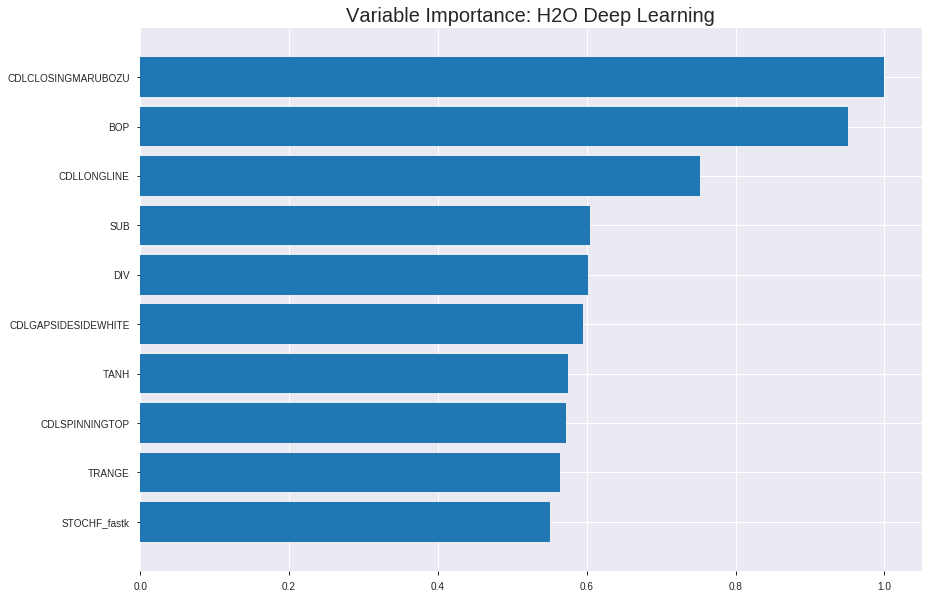

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_022411_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1952836289856485
RMSE: 0.4419090732103704
LogLoss: 0.5743273737544953
Mean Per-Class Error: 0.2911588493175745
AUC: 0.7680321710212535
pr_auc: 0.7745113585379366
Gini: 0.5360643420425071
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4345848075508012: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      464  351   0.4307   (351.0/815.0)
1      167  772   0.1778   (167.0/939.0)
Total  631  1123  0.2953   (518.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.434585     0.748788  243
max f2                       0.168153     0.863123  360
max f0point5                 0.544279     0.731985  189
max accuracy                 0.469272     0.714367  227
max precision                0.954894     1         0
max recall                   0.0712411    1         397
max specificity              0.954894     1         0
max absolute_mcc             0.469272     0.424025  227
max min_per_class_accuracy   0.533383     0.705005  196
max mean_per_class_accuracy  0.469272     0.708841  227

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 52.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.91058            1.6604    1.6604             0.888889         0.926182  0.888889                    0.926182            0.0170394       0.0170394                  66.0395   66.0395
    2        0.0205245                   0.891952           1.6604    1.6604             0.888889         0.89894   0.888889                    0.912561            0.0170394       0.0340788                  66.0395   66.0395
    3        0.0302166                   0.886332           1.75807   1.69172            0.941176         0.889147  0.90566                     0.905051            0.0170394       0.0511182                  75.8066   69.1723
    4        0.0404789                   0.880974           1.6604    1.68378            0.888889         0.883651  0.901408                    0.899625            0.0170394       0.0681576                  66.0395   68.3781
    5        0.050171                    0.874701           1.64819   1.6769             0.882353         0.878298  0.897727                    0.895505            0.0159744       0.0841321                  64.8186   67.6905
    6        0.100342                    0.8319             1.54954   1.61322            0.829545         0.855198  0.863636                    0.875352            0.0777423       0.161874                   54.9545   61.3225
    7        0.149943                    0.79215            1.54589   1.59095            0.827586         0.812395  0.851711                    0.854526            0.0766773       0.238552                   54.5885   59.0949
    8        0.200114                    0.74901            1.46464   1.55928            0.784091         0.76968   0.834758                    0.833254            0.0734824       0.312034                   46.4638   55.9281
    9        0.299886                    0.688783           1.30222   1.47376            0.697143         0.718317  0.788973                    0.795014            0.129925        0.44196                    30.2224   47.3759
    10       0.400228                    0.609777           1.36912   1.44752            0.732955         0.64974   0.774929                    0.758592            0.13738         0.57934                    36.9119   44.7524
    11       0.5                         0.539292           1.13144   1.38445            0.605714         0.574009  0.741163                    0.72176             0.112886        0.692226                   13.1441   38.4452
    12       0.599772                    0.463654           1.00335   1.32106            0.537143         0.50573   0.707224                    0.685823            0.100106        0.792332                   0.335311  32.1056
    13       0.700114                    0.38886            0.700479  1.23211            0.375            0.425825  0.659609                    0.64856             0.0702875       0.86262                    -29.9521  23.2113
    14       0.799886                    0.315479           0.555046  1.14766            0.297143         0.353635  0.614398                    0.611773            0.0553781       0.917998                   -44.4954  14.7661
    15       0.899658                    0.202061           0.544372  1.08076            0.291429         0.255773  0.57858                     0.572293            0.0543131       0.972311                   -45.5628  8.07563
    16       1                           0.044814           0.275946  1                  0.147727         0.149528  0.535348                    0.529871         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.22023199872280907
RMSE: 0.46928882228624313
LogLoss: 0.6307860097697624
Mean Per-Class Error: 0.34064222953111845
AUC: 0.7030443141554252
pr_auc: 0.6802342411394208
Gini: 0.40608862831085046
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2922805343243828: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      80   163  0.6708   (163.0/243.0)
1      20   239  0.0772   (20.0/259.0)
Total  100  402  0.3645   (183.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.292281     0.723147  312
max f2                       0.136989     0.856481  377
max f0point5                 0.47419      0.668335  222
max accuracy                 0.47419      0.661355  222
max precision                0.932948     1         0
max recall                   0.136989     1         377
max specificity              0.932948     1         0
max absolute_mcc             0.471257     0.321754  225
max min_per_class_accuracy   0.519306     0.646091  198
max mean_per_class_accuracy  0.47419      0.659358  222

Gains/Lift Table: Avg response rate: 51.59 %, avg score: 51.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.903241           1.29215   1.29215            0.666667         0.911448  0.666667                    0.911448            0.015444        0.015444                   29.2149   29.2149
    2        0.0219124                   0.896431           1.93822   1.58582            1                0.898075  0.818182                    0.90537             0.019305        0.034749                   93.8224   58.582
    3        0.0318725                   0.885373           1.16293   1.45367            0.6              0.889843  0.75                        0.900518            0.011583        0.046332                   16.2934   45.3668
    4        0.0418327                   0.880134           1.55058   1.47674            0.8              0.882093  0.761905                    0.896131            0.015444        0.0617761                  55.0579   47.6742
    5        0.0517928                   0.873638           1.55058   1.49094            0.8              0.876802  0.769231                    0.892414            0.015444        0.0772201                  55.0579   49.0941
    6        0.101594                    0.829024           1.55058   1.52018            0.8              0.849107  0.784314                    0.871185            0.0772201       0.15444                    55.0579   52.0176
    7        0.151394                    0.780492           1.55058   1.53018            0.8              0.810579  0.789474                    0.851249            0.0772201       0.23166                    55.0579   53.0177
    8        0.201195                    0.738269           1.08541   1.42008            0.56             0.757826  0.732673                    0.828124            0.0540541       0.285714                   8.54054   42.0085
    9        0.300797                    0.669001           1.24046   1.36061            0.64             0.705194  0.701987                    0.787419            0.123552        0.409266                   24.0463   36.0608
    10       0.400398                    0.585275           1.16293   1.31144            0.6              0.622688  0.676617                    0.746441            0.11583         0.525097                   16.2934   31.1435
    11       0.5                         0.522659           1.16293   1.28185            0.6              0.552898  0.661355                    0.707887            0.11583         0.640927                   16.2934   28.1853
    12       0.599602                    0.459442           1.00788   1.23634            0.52             0.486268  0.637874                    0.671073            0.100386        0.741313                   0.787645  23.6342
    13       0.699203                    0.393927           0.852819  1.18171            0.44             0.421559  0.609687                    0.63553             0.0849421       0.826255                   -14.7181  18.1709
    14       0.798805                    0.29292            0.930347  1.15037            0.48             0.339244  0.593516                    0.598586            0.0926641       0.918919                   -6.96525  15.0367
    15       0.898406                    0.181045           0.542703  1.083              0.28             0.230718  0.558758                    0.557803            0.0540541       0.972973                   -45.7297  8.29987
    16       1                           0.0155784          0.266031  1                  0.137255         0.132094  0.515936                    0.514553          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:30:18  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 02:30:20  1 min 42.045 sec  563 obs/sec       0.627138  1             1100       0.473971         0.674315            0.0968914      0.735373        0.744781           1.6604           0.342075                         0.489042           0.707624              0.0423771        0.708089          0.710979             1.61519            0.36255
    2019-09-03 02:30:30  1 min 51.782 sec  822 obs/sec       5.01596   8             8798       0.462744         0.616495            0.13917        0.761993        0.76833            1.6604           0.307868                         0.471392           0.632529              0.110253         0.715724          0.71511              1.61519            0.364542
    2019-09-03 02:30:41  2 min  2.215 sec  972 obs/sec       11.2184   18            19677      0.441909         0.574327            0.214942       0.768032        0.774511           1.6604           0.295325                         0.469289           0.630786              0.118176         0.703044          0.680234             1.29215            0.364542
    2019-09-03 02:30:50  2 min 11.837 sec  1093 obs/sec      18.0131   29            31595      0.439445         0.570015            0.223671       0.774727        0.778521           1.6604           0.294755                         0.467194           0.631058              0.126031         0.711259          0.680471             1.29215            0.36255
    2019-09-03 02:31:00  2 min 21.445 sec  1189 obs/sec      25.4755   41            44684      0.435717         0.562663            0.236789       0.780299        0.782826           1.6604           0.297605                         0.47038            0.639801              0.114071         0.708192          0.675803             0.969112           0.354582
    2019-09-03 02:31:09  2 min 30.881 sec  1273 obs/sec      33.5177   54            58790      0.432752         0.556742            0.24714        0.786412        0.786903           1.6604           0.284493                         0.477162           0.659051              0.0883388        0.697547          0.668836             0.969112           0.350598
    2019-09-03 02:31:18  2 min 39.639 sec  1351 obs/sec      41.6534   67            73060      0.428694         0.547875            0.261192       0.794744        0.792741           1.6604           0.281642                         0.475085           0.651073              0.0962605        0.699588          0.67501              1.29215            0.35259
    2019-09-03 02:31:19  2 min 40.522 sec  1350 obs/sec      41.6534   67            73060      0.441909         0.574327            0.214942       0.768032        0.774511           1.6604           0.295325                         0.469289           0.630786              0.118176         0.703044          0.680234             1.29215            0.364542

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.03784895232349081
BOP                 0.950701892375946      0.950701892375946    0.03598307059838967
CDLLONGLINE         0.7517130374908447     0.7517130374908447   0.028451550916937438
SUB                 0.6037635803222656     0.6037635803222656   0.022851818966277544
DIV                 0.6014291048049927     0.6014291048049927   0.022763461513723923
---                 ---                    ---                  ---
BETA_8              0.4559643268585205     0.4559643268585205   0.017257772068480722
SIN                 0.45574304461479187    0.45574304461479187  0.0172493967673878
week                0.4553474485874176     0.4553474485874176   0.01723442387220835
CDLLONGLEGGEDDOJI   0.4368186891078949     0.4368186891078949   0.016533129738054465
CDLRICKSHAWMAN      0.4101006090641022     0.4101006090641022   0.015521878400301744


See the whole table with table.as_data_frame()


('accuracy', 0.7290836653386454)

('F1', 0.752542372881356)

('auc', 0.7700660401320802)

('logloss', 0.5734054850841662)

('mean_per_class_error', 0.2716217932435865)

('rmse', 0.4431532275428209)

('mse', 0.1963847830816192)

deeplearning prediction progress: |███████████████████████████████████████| 100%


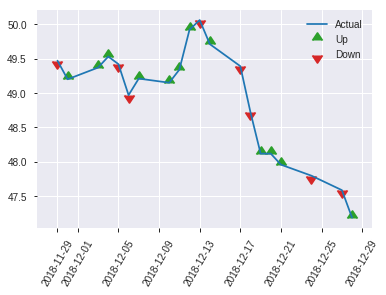


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1963847830816192
RMSE: 0.4431532275428209
LogLoss: 0.5734054850841662
Mean Per-Class Error: 0.2716217932435865
AUC: 0.7700660401320802
pr_auc: 0.7322791742222661
Gini: 0.5401320802641605
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.359741414201496: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      67   57   0.4597   (57.0/124.0)
1      16   111  0.126    (16.0/127.0)
Total  83   168  0.2908   (73.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.359741     0.752542  167
max f2                       0.227458     0.869565  204
max f0point5                 0.422556     0.723589  140
max accuracy                 0.422556     0.729084  140
max precision                0.921965     1         0
max recall                   0.139755     1         237
max specificity              0.921965     1         0
max absolute_mcc             0.422556     0.460248  140
max min_per_class_accuracy   0.459799     0.701613  126
max mean_per_class_accuracy  0.422556     0.728378  140

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 47.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.893359           1.31759   1.31759            0.666667         0.911682  0.666667                    0.911682            0.015748        0.015748                   31.7585   31.7585
    2        0.0239044                   0.885103           1.97638   1.64698            1                0.888556  0.833333                    0.900119            0.023622        0.0393701                  97.6378   64.6982
    3        0.0318725                   0.874283           1.97638   1.72933            1                0.879058  0.875                       0.894854            0.015748        0.0551181                  97.6378   72.9331
    4        0.0438247                   0.87052            1.97638   1.79671            1                0.870753  0.909091                    0.888281            0.023622        0.0787402                  97.6378   79.6707
    5        0.0517928                   0.867998           1.97638   1.82435            1                0.869354  0.923077                    0.885369            0.015748        0.0944882                  97.6378   82.4349
    6        0.103586                    0.777718           1.52029   1.67232            0.769231         0.812355  0.846154                    0.848862            0.0787402       0.173228                   52.0291   67.232
    7        0.151394                    0.725619           1.31759   1.5603             0.666667         0.753749  0.789474                    0.818826            0.0629921       0.23622                    31.7585   56.0298
    8        0.203187                    0.690081           1.21623   1.4726             0.615385         0.706012  0.745098                    0.79007             0.0629921       0.299213                   21.6233   47.2595
    9        0.302789                    0.607445           1.50205   1.48228            0.76             0.656748  0.75                        0.746214            0.149606        0.448819                   50.2047   48.2283
    10       0.40239                     0.522683           1.18583   1.4089             0.6              0.564021  0.712871                    0.701117            0.11811         0.566929                   18.5827   40.8903
    11       0.501992                    0.466082           1.34394   1.39601            0.68             0.496916  0.706349                    0.660601            0.133858        0.700787                   34.3937   39.6013
    12       0.601594                    0.399592           1.02772   1.33504            0.52             0.42893   0.675497                    0.622245            0.102362        0.80315                    2.77165   33.5037
    13       0.701195                    0.324126           0.790551  1.2577             0.4              0.364401  0.636364                    0.585619            0.0787402       0.88189                    -20.9449  25.7695
    14       0.800797                    0.247441           0.869606  1.20943            0.44             0.28304   0.61194                     0.547985            0.0866142       0.968504                   -13.0394  20.9425
    15       0.900398                    0.163605           0.15811   1.09313            0.08             0.195806  0.553097                    0.509027            0.015748        0.984252                   -84.189   9.31294
    16       1                           0.0828517          0.15811   1                  0.08             0.126236  0.505976                    0.470901          

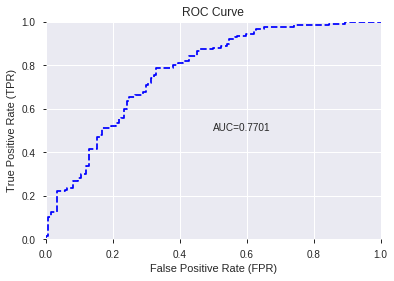

This function is available for GLM models only


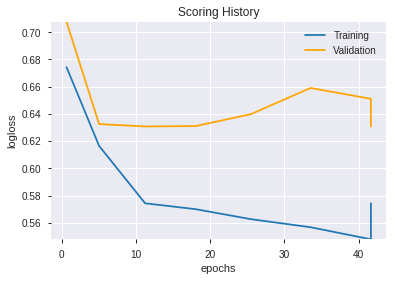

--2019-09-03 02:31:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.133.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.133.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_022411_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_022411_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_83a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'BOP',
 'CDLLONGLINE',
 'SUB',
 'DIV',
 'CDLGAPSIDESIDEWHITE',
 'TANH',
 'CDLSPINNINGTOP',
 'TRANGE',
 'STOCHF_fastk',
 'CDLMORNINGSTAR',
 'CDLTAKURI',
 'CCI_8',
 'CDLDRAGONFLYDOJI',
 'CDLINNECK',
 'CDLMORNINGDOJISTAR',
 'CDLHAMMER',
 'STOCHRSI_fastd',
 'BETA_12',
 'CDLLADDERBOTTOM',
 'ULTOSC',
 'aroonup_20',
 'MFI_8',
 'dayofweek',
 'CDL3LINESTRIKE',
 'aroondown_8',
 'days_in_month',
 'aroonup_14',
 'HT_TRENDMODE',
 'WILLR_8',
 'Volume',
 'aroondown_30',
 'CDLEVENINGDOJISTAR',
 'dayofyear',
 'weekday',
 'STOCHRSI_fastk',
 'HT_DCPERIOD',
 'COS',
 'quarter',
 'OBV',
 'day',
 'AROONOSC_8',
 'aroonup_8',
 'ADOSC',
 'weekday_name',
 'BETA_8',
 'SIN',
 'week',
 'CDLLONGLEGGEDDOJI',
 'CDLRICKSHAWMAN']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_023132_model_1  0.77159  0.574914               0.28918  0.442634  0.195925

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.424293           1.000000    0.096637
1                 CCI_8             0.311864           0.735019    0.071030
2          STOCHF_fastk             0.266651           0.628459    0.060732
3    CDLCLOSINGMARUBOZU             0.255998           0.603352    0.058306
4               WILLR_8             0.219004           0.516162    0.049880
5                 MFI_8             0.205466           0.484255    0.046797
6   CDLGAPSIDESIDEWHITE             0.203268           0.479075    0.046296
7                ULTOSC             0.193693           0.456508    0.044116
8                   DIV             0.151848           0.357884    0.034585
9        STOCHRSI_fastd             0.138960           0.327509    0.031649
10            CDLHAMMER             0.117617           0.277207    0.026788
11               TRANGE             0.115497           0.272211    0.026306
12       CDLSPINNINGTOP             0.115228           0.271577    0.026244
13                  SUB             0.113195           0.266785    0.025781
14         aroondown_30             0.108738           0.256279    0.024766
15      CDLLADDERBOTTOM             0.088420           0.208394    0.020139
16   CDLMORNINGDOJISTAR             0.086825           0.204635    0.019775
17           aroonup_14             0.082258           0.193872    0.018735
18                  day             0.075359           0.177610    0.017164
19                 TANH             0.070451           0.166043    0.016046
20          CDLLONGLINE             0.067396           0.158844    0.015350
21       CDL3LINESTRIKE             0.067045           0.158017    0.015270
22                 week             0.066484           0.156694    0.015142
23                  SIN             0.062268           0.146756    0.014182
24                  COS             0.059289           0.139736    0.013504
25         HT_TRENDMODE             0.055973           0.131920    0.012748
26     CDLDRAGONFLYDOJI             0.054328           0.128043    0.012374
27            CDLTAKURI             0.054170           0.127672    0.012338
28   CDLEVENINGDOJISTAR             0.054126           0.127566    0.012328
29              BETA_12             0.049434           0.116508    0.011259
30          aroondown_8             0.046455           0.109487    0.010580
31          HT_DCPERIOD             0.043803           0.103238    0.009977
32       STOCHRSI_fastk             0.043349           0.102168    0.009873
33                  OBV             0.042445           0.100036    0.009667
34              quarter             0.042055           0.099118    0.009578
35                ADOSC             0.040579           0.095639    0.009242
36        days_in_month             0.025626           0.060396    0.005836
37    CDLLONGLEGGEDDOJI             0.025542           0.060199    0.005818
38           AROONOSC_8             0.024580           0.057930    0.005598
39       CDLMORNINGSTAR             0.024340           0.057366    0.005544
40            CDLINNECK             0.022685           0.053466    0.005167
41       CDLRICKSHAWMAN             0.021006           0.049507    0.004784
42               Volume             0.014945           0.035223    0.003404
43           aroonup_20             0.013353           0.031471    0.003041
44         weekday_name             0.007899           0.018617    0.001799
45            dayofyear             0.007159           0.016873    0.001631
46            dayofweek             0.003569           0.008411    0.000813
47              weekday             0.003477           0.008196    0.000792
48            aroonup_8             0.002364           0.005571    0.000538
49               BETA_8             0.000210           0.000494    0.000048

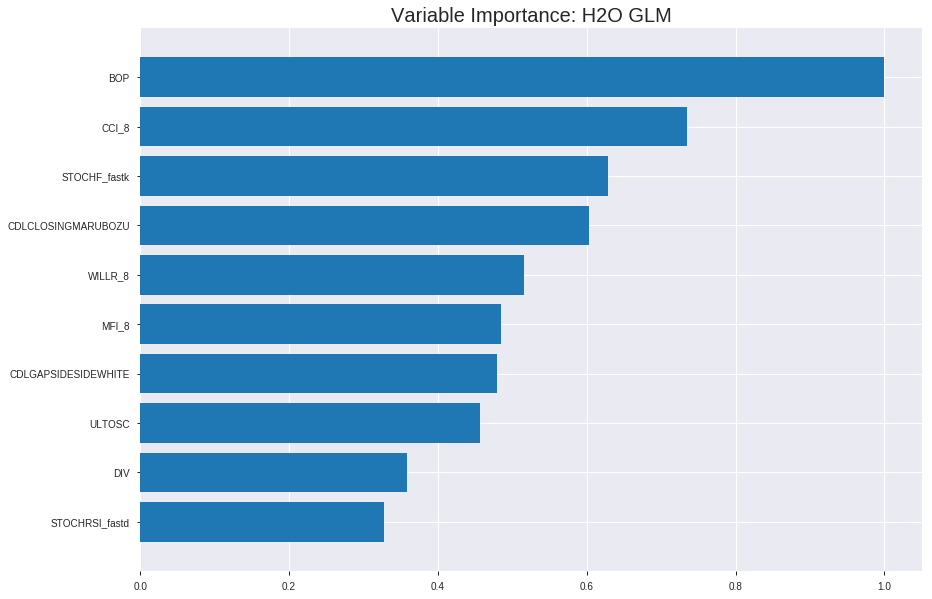

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_023132_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19535533944312744
RMSE: 0.4419902028813845
LogLoss: 0.5733445062162127
Null degrees of freedom: 1753
Residual degrees of freedom: 1703
Null deviance: 2422.786744110176
Residual deviance: 2011.292527806474
AIC: 2113.292527806474
AUC: 0.7682941649189517
pr_auc: 0.7786364815525052
Gini: 0.5365883298379035
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3938372611656771: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      362  453   0.5558   (453.0/815.0)
1      105  834   0.1118   (105.0/939.0)
Total  467  1287  0.3181   (558.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.393837     0.749326  267
max f2                       0.179335     0.86108   358
max f0point5                 0.515488     0.731834  203
max accuracy                 0.515488     0.715507  203
max precision                0.993907     1         0
max recall                   0.0646728    1         391
max specificity              0.993907     1         0
max absolute_mcc             0.515488     0.427109  203
max min_per_class_accuracy   0.539154     0.70184   191
max mean_per_class_accuracy  0.515488     0.712985  203

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 53.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.932421           1.86794   1.86794            1                0.958638  1                           0.958638            0.0191693       0.0191693                  86.7945   86.7945
    2        0.0205245                   0.920019           1.6604    1.76417            0.888889         0.925202  0.944444                    0.94192             0.0170394       0.0362087                  66.0395   76.417
    3        0.0302166                   0.895643           1.64819   1.72697            0.882353         0.904275  0.924528                    0.929845            0.0159744       0.0521832                  64.8186   72.6968
    4        0.0404789                   0.880038           1.76417   1.7364             0.944444         0.886861  0.929577                    0.918948            0.0181044       0.0702875                  76.417    73.6399
    5        0.050171                    0.867559           1.53831   1.69813            0.823529         0.876057  0.909091                    0.910662            0.0149095       0.085197                   53.8307   69.8131
    6        0.100342                    0.809484           1.52832   1.61322            0.818182         0.839214  0.863636                    0.874938            0.0766773       0.161874                   52.8318   61.3225
    7        0.149943                    0.76868            1.52441   1.58385            0.816092         0.787547  0.847909                    0.846029            0.0756124       0.237487                   52.4415   58.3847
    8        0.200114                    0.732801           1.48587   1.55928            0.795455         0.750833  0.834758                    0.822162            0.0745474       0.312034                   48.5865   55.9281
    9        0.299886                    0.664981           1.35559   1.49151            0.725714         0.699917  0.798479                    0.781491            0.13525         0.447284                   35.5594   49.1515
    10       0.400228                    0.613514           1.2736    1.43688            0.681818         0.639121  0.769231                    0.745797            0.127796        0.57508                    27.3599   43.688
    11       0.5                         0.547984           1.14211   1.37806            0.611429         0.579387  0.737742                    0.712591            0.113951        0.689031                   14.2115   37.8062
    12       0.599772                    0.485381           0.960657  1.30863            0.514286         0.516018  0.70057                     0.679891            0.0958466       0.784878                   -3.93428  30.8627
    13       0.700114                    0.413214           0.753546  1.22907            0.403409         0.44828   0.65798                     0.646696            0.0756124       0.86049                    -24.6454  22.9071
    14       0.799886                    0.343349           0.587068  1.14899            0.314286         0.379574  0.61511                     0.613377            0.0585729       0.919063                   -41.2932  14.8992
    15       0.899658                    0.231808           0.56572   1.08431            0.302857         0.294134  0.580482                    0.577973            0.056443        0.975506                   -43.428   8.43075
    16       1                           0.0218079          0.244106  1                  0.130682         0.15317   0.535348                    0.535348           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21129130519033396
RMSE: 0.45966433969836507
LogLoss: 0.610542484635181
Null degrees of freedom: 501
Residual degrees of freedom: 451
Null deviance: 696.1689483589155
Residual deviance: 612.9846545737216
AIC: 714.9846545737216
AUC: 0.7254397254397255
pr_auc: 0.7076309796196912
Gini: 0.4508794508794509
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2893801402632463: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      71   172  0.7078   (172.0/243.0)
1      13   246  0.0502   (13.0/259.0)
Total  84   418  0.3685   (185.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.28938      0.726736  330
max f2                       0.161927     0.853254  370
max f0point5                 0.5009       0.689278  220
max accuracy                 0.5009       0.683267  220
max precision                0.835934     0.866667  27
max recall                   0.090122     1         390
max specificity              0.945384     0.995885  0
max absolute_mcc             0.5009       0.36541   220
max min_per_class_accuracy   0.541246     0.671815  199
max mean_per_class_accuracy  0.5009       0.681737  220

Gains/Lift Table: Avg response rate: 51.59 %, avg score: 52.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.914148           1.61519   1.61519            0.833333         0.932052  0.833333                    0.932052            0.019305        0.019305                   61.5187   61.5187
    2        0.0219124                   0.893234           1.16293   1.40962            0.6              0.898327  0.727273                    0.916722            0.011583        0.030888                   16.2934   40.9617
    3        0.0318725                   0.881419           1.93822   1.57481            1                0.886889  0.8125                      0.907399            0.019305        0.0501931                  93.8224   57.4807
    4        0.0418327                   0.87055            1.93822   1.66133            1                0.877013  0.857143                    0.900165            0.019305        0.0694981                  93.8224   66.1335
    5        0.0517928                   0.848822           1.55058   1.64004            0.8              0.857706  0.846154                    0.891999            0.015444        0.0849421                  55.0579   64.0036
    6        0.101594                    0.79588            1.31799   1.48217            0.68             0.816081  0.764706                    0.854784            0.0656371       0.150579                   31.7992   48.2171
    7        0.151394                    0.755564           1.78317   1.58118            0.92             0.773842  0.815789                    0.828159            0.0888031       0.239382                   78.3166   58.1183
    8        0.201195                    0.724141           1.31799   1.51604            0.68             0.737929  0.782178                    0.805825            0.0656371       0.305019                   31.7992   51.6037
    9        0.300797                    0.656019           1.2017    1.41195            0.62             0.69421   0.728477                    0.768866            0.119691        0.42471                    20.1699   41.1951
    10       0.400398                    0.599041           1.27923   1.37894            0.66             0.628136  0.711443                    0.733859            0.127413        0.552124                   27.9228   37.8935
    11       0.5                         0.543835           1.16293   1.33591            0.6              0.57021   0.689243                    0.701259            0.11583         0.667954                   16.2934   33.5907
    12       0.599602                    0.473265           0.852819  1.25566            0.44             0.506367  0.647841                    0.668885            0.0849421       0.752896                   -14.7181  25.566
    13       0.699203                    0.409369           0.891583  1.2038             0.46             0.441717  0.621083                    0.636525            0.0888031       0.841699                   -10.8417  20.3797
    14       0.798805                    0.315967           0.658996  1.13587            0.34             0.365128  0.586035                    0.602685            0.0656371       0.907336                   -34.1004  13.5867
    15       0.898406                    0.218672           0.620232  1.0787             0.32             0.270161  0.556541                    0.56582             0.0617761       0.969112                   -37.9768  7.87011
    16       1                           0.00274708         0.304035  1                  0.156863         0.138062  0.515936                    0.522362          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-03 02:31:33  0.000 sec   2            18        51            1.3664            1.37309
    2019-09-03 02:31:33  0.086 sec   4            11        51            1.35844           1.36582
    2019-09-03 02:31:33  0.167 sec   6            6.9       51            1.34701           1.35547
    2019-09-03 02:31:33  0.249 sec   8            4.3       51            1.33148           1.34158
    2019-09-03 02:31:33  0.316 sec   10           2.7       51            1.31167           1.32424
    2019-09-03 02:31:34  0.388 sec   12           1.7       51            1.28822           1.30437
    2019-09-03 02:31:34  0.456 sec   14           1         51            1.26273           1.28379
    2019-09-03 02:31:34  0.540 sec   16           0.64      51            1.2373            1.26463
    2019-09-03 02:31:34  0.626 sec   18           0.4       51            1.21397           1.24866
    2019-09-03 02:31:34  0.647 sec   20           0.25      51            1.19413           1.23682
    2019-09-03 02:31:34  0.667 sec   22           0.15      51            1.17832           1.22899
    2019-09-03 02:31:34  0.689 sec   24           0.095     51            1.16633           1.22441
    2019-09-03 02:31:34  0.714 sec   26           0.059     51            1.15753           1.22205
    2019-09-03 02:31:34  0.741 sec   28           0.037     51            1.15119           1.22109
    2019-09-03 02:31:34  0.764 sec   30           0.023     51            1.14669           1.22108
    2019-09-03 02:31:34  0.797 sec   32           0.014     51            1.14358           1.22186
    2019-09-03 02:31:34  0.822 sec   34           0.0088    51            1.14153           1.22332
    2019-09-03 02:31:34  0.847 sec   36           0.0054    51            1.14025           1.22541
    2019-09-03 02:31:34  0.869 sec   38           0.0034    51            1.1395            1.22793
    2019-09-03 02:31:34  0.891 sec   39           0.0021    51            1.13909           1.23033

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7211155378486056)

('F1', 0.7615894039735098)

('auc', 0.7715900431800864)

('logloss', 0.5749140052626974)

('mean_per_class_error', 0.2806388112776226)

('rmse', 0.44263429115707653)

('mse', 0.19592511570812762)

glm prediction progress: |████████████████████████████████████████████████| 100%


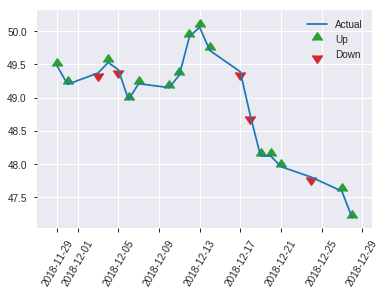


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19592511570812762
RMSE: 0.44263429115707653
LogLoss: 0.5749140052626974
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 348.7926110092956
Residual deviance: 288.6068306418741
AIC: 390.6068306418741
AUC: 0.7715900431800864
pr_auc: 0.7319532647409223
Gini: 0.5431800863601728
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36786398810723203: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   60   0.4839   (60.0/124.0)
1      12   115  0.0945   (12.0/127.0)
Total  76   175  0.2869   (72.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.367864     0.761589  174
max f2                       0.247026     0.866852  212
max f0point5                 0.528406     0.716878  105
max accuracy                 0.391474     0.721116  162
max precision                0.928787     1         0
max recall                   0.127034     1         238
max specificity              0.928787     1         0
max absolute_mcc             0.388588     0.461979  164
max min_per_class_accuracy   0.492551     0.692913  125
max mean_per_class_accuracy  0.391474     0.719361  162

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 48.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.907206           1.31759   1.31759            0.666667         0.920571  0.666667                    0.920571            0.015748        0.015748                   31.7585   31.7585
    2        0.0239044                   0.878453           1.97638   1.64698            1                0.895369  0.833333                    0.90797             0.023622        0.0393701                  97.6378   64.6982
    3        0.0318725                   0.852084           0.988189  1.48228            0.5              0.857723  0.75                        0.895408            0.00787402      0.0472441                  -1.1811   48.2283
    4        0.0438247                   0.82315            1.97638   1.61704            1                0.834842  0.818182                    0.87889             0.023622        0.0708661                  97.6378   61.7037
    5        0.0517928                   0.81041            1.97638   1.67232            1                0.813103  0.846154                    0.868769            0.015748        0.0866142                  97.6378   67.232
    6        0.103586                    0.7498             1.82435   1.74833            0.923077         0.775824  0.884615                    0.822296            0.0944882       0.181102                   82.4349   74.8334
    7        0.151394                    0.70403            1.31759   1.61231            0.666667         0.721406  0.815789                    0.790436            0.0629921       0.244094                   31.7585   61.2308
    8        0.203187                    0.667712           1.36826   1.5501             0.692308         0.683149  0.784314                    0.763088            0.0708661       0.314961                   36.8262   55.01
    9        0.302789                    0.609653           1.18583   1.43027            0.6              0.64221   0.723684                    0.723326            0.11811         0.433071                   18.5827   43.0274
    10       0.40239                     0.541721           1.66016   1.48718            0.84             0.578469  0.752475                    0.68747             0.165354        0.598425                   66.0157   48.7175
    11       0.501992                    0.492551           0.948661  1.38033            0.48             0.514876  0.698413                    0.653225            0.0944882       0.692913                   -5.13386  38.0327
    12       0.601594                    0.416515           1.10677   1.33504            0.56             0.450621  0.675497                    0.619681            0.110236        0.80315                    10.6772   33.5037
    13       0.701195                    0.367122           1.02772   1.29138            0.52             0.388404  0.653409                    0.58683             0.102362        0.905512                   2.77165   29.1383
    14       0.800797                    0.287244           0.553386  1.19959            0.28             0.318009  0.606965                    0.553394            0.0551181       0.96063                    -44.6614  19.9593
    15       0.900398                    0.203103           0.237165  1.09313            0.12             0.238454  0.553097                    0.518556            0.023622        0.984252                   -76.2835  9.31294
    16       1                           0.0708751          0.15811   1                  0.08             0.137719  0.505976                    0.480624            

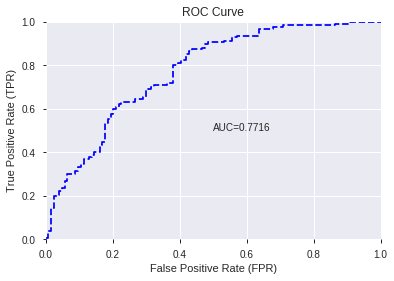

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


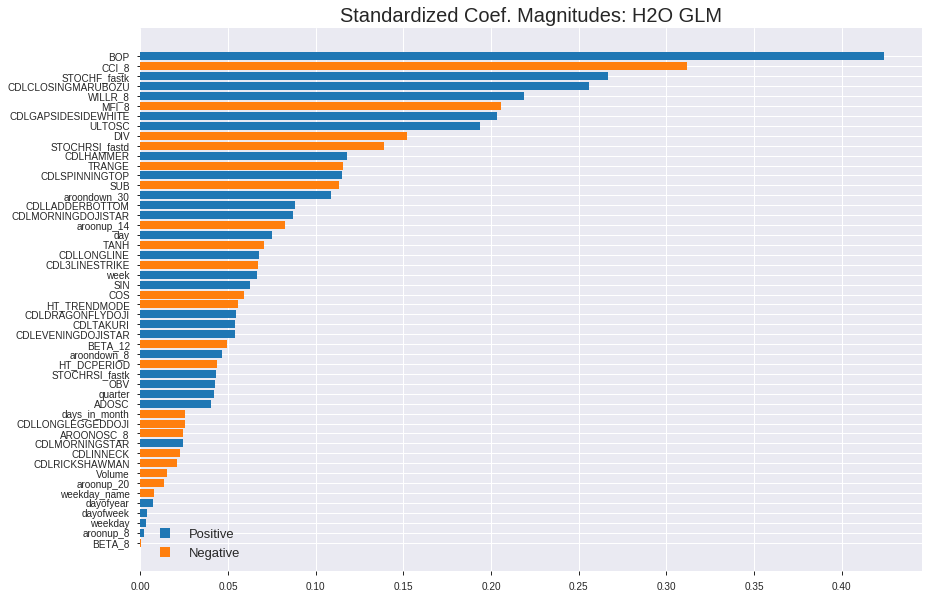

'log_likelihood'
--2019-09-03 02:31:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.129.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.129.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_023132_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_023132_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_83a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'CCI_8',
 'STOCHF_fastk',
 'CDLCLOSINGMARUBOZU',
 'WILLR_8',
 'MFI_8',
 'CDLGAPSIDESIDEWHITE',
 'ULTOSC',
 'DIV',
 'STOCHRSI_fastd',
 'CDLHAMMER',
 'TRANGE',
 'CDLSPINNINGTOP',
 'SUB',
 'aroondown_30',
 'CDLLADDERBOTTOM',
 'CDLMORNINGDOJISTAR',
 'aroonup_14',
 'day',
 'TANH',
 'CDLLONGLINE',
 'CDL3LINESTRIKE',
 'week',
 'SIN',
 'COS',
 'HT_TRENDMODE',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLEVENINGDOJISTAR',
 'BETA_12',
 'aroondown_8',
 'HT_DCPERIOD',
 'STOCHRSI_fastk',
 'OBV',
 'quarter',
 'ADOSC',
 'days_in_month',
 'CDLLONGLEGGEDDOJI',
 'AROONOSC_8',
 'CDLMORNINGSTAR',
 'CDLINNECK',
 'CDLRICKSHAWMAN',
 'Volume',
 'aroonup_20',
 'weekday_name',
 'dayofyear',
 'dayofweek',
 'weekday',
 'aroonup_8',
 'BETA_8']

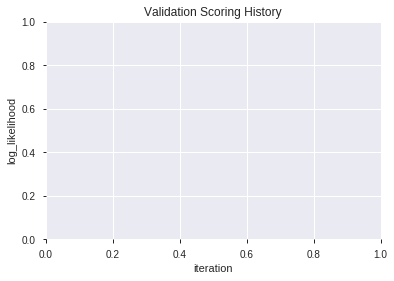

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_023145_model_3  0.769050  0.573371              0.264510  0.442061  0.195418
1  XGBoost_grid_1_AutoML_20190903_023145_model_1  0.767399  0.574725              0.268733  0.441861  0.195241
2               XGBoost_2_AutoML_20190903_023145  0.766891  0.578510              0.280925  0.444185  0.197301
3  XGBoost_grid_1_AutoML_20190903_023145_model_4  0.764605  0.581935              0.284195  0.445780  0.198720
4  XGBoost_grid_1_AutoML_20190903_023145_model_2  0.763081  0.583666              0.268637  0.446376  0.199252
5               XGBoost_1_AutoML_20190903_023145  0.762954  0.578809              0.346488  0.444576  0.197648
6  XGBoost_grid_1_AutoML_20190903_023145_model_6  0.761557  0.581345              0.292831  0.445433  0.198410
7               XGBoost_3_AutoML_20190903_023145  0.760859  0.584845              0.284957  0.446626  0.199475
8  XGBoost_grid_1_AutoML_20190903_023145_model_7  0.758001  0.588266              0.338233  0.449273  0.201847
9  XGBoost_grid_1_AutoML_20190903_023145_model_5  0.740919  0.596160              0.313373  0.452797  0.205025

variable  relative_importance  scaled_importance  percentage
0                  BOP          1433.014771           1.000000    0.195325
1         STOCHF_fastk           579.243713           0.404213    0.078953
2                  SUB           357.680511           0.249600    0.048753
3                CCI_8           339.188873           0.236696    0.046233
4                  DIV           308.461365           0.215253    0.042044
5                  SIN           285.030121           0.198902    0.038851
6                MFI_8           282.237915           0.196954    0.038470
7               TRANGE           257.060547           0.179384    0.035038
8               Volume           251.544235           0.175535    0.034286
9              WILLR_8           250.291962           0.174661    0.034116
10           dayofyear           230.080475           0.160557    0.031361
11              ULTOSC           225.047302           0.157045    0.030675
12      STOCHRSI_fastd           213.412659           0.148926    0.029089
13              BETA_8           211.886887           0.147861    0.028881
14                 OBV           173.608643           0.121149    0.023664
15                 COS           164.406281           0.114728    0.022409
16                 day           155.410385           0.108450    0.021183
17  CDLCLOSINGMARUBOZU           148.251251           0.103454    0.020207
18         HT_DCPERIOD           145.403885           0.101467    0.019819
19                week           143.791763           0.100342    0.019599
20             BETA_12           140.181198           0.097823    0.019107
21           aroonup_8           139.572906           0.097398    0.019024
22               ADOSC           128.672775           0.089792    0.017539
23          aroonup_14           117.925919           0.082292    0.016074
24          aroonup_20           100.381424           0.070049    0.013682
25        aroondown_30            95.274773           0.066486    0.012986
26      STOCHRSI_fastk            81.435852           0.056828    0.011100
27                TANH            65.503853           0.045711    0.008928
28           dayofweek            59.802212           0.041732    0.008151
29         aroondown_8            51.380535           0.035855    0.007003
30        weekday_name            50.601791           0.035311    0.006897
31          AROONOSC_8            38.810234           0.027083    0.005290
32         CDLLONGLINE            32.113377           0.022410    0.004377
33      CDLSPINNINGTOP            26.537224           0.018518    0.003617
34             weekday            14.632991           0.010211    0.001995
35   CDLLONGLEGGEDDOJI            12.596386           0.008790    0.001717
36       days_in_month            12.326703           0.008602    0.001680
37             quarter             4.958988           0.003461    0.000676
38      CDLRICKSHAWMAN             4.347961           0.003034    0.000593
39           CDLHAMMER             3.848647           0.002686    0.000525
40        HT_TRENDMODE             0.591343           0.000413    0.000081

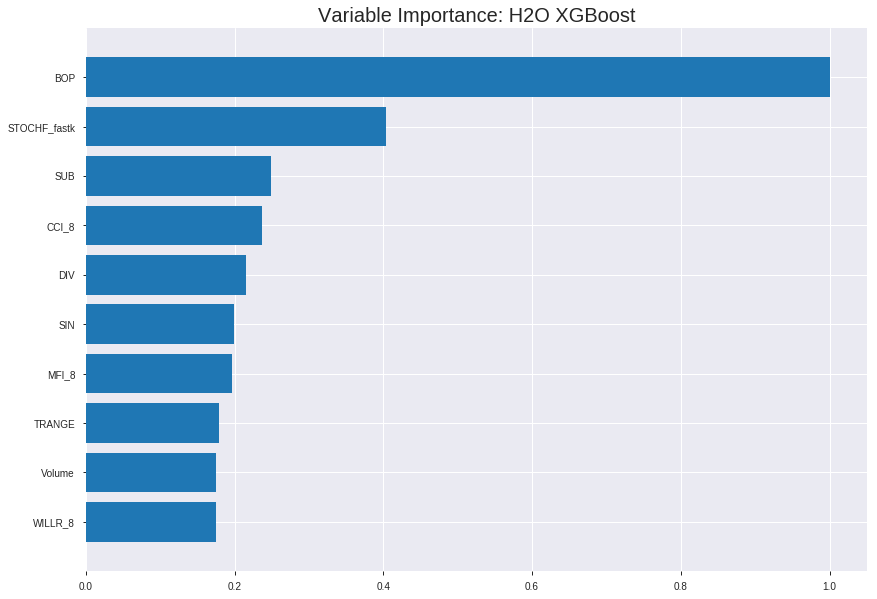

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_023145_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14505589426777712
RMSE: 0.38086204099093035
LogLoss: 0.4597263089988046
Mean Per-Class Error: 0.17984933717503937
AUC: 0.9024010662694291
pr_auc: 0.9136351286894835
Gini: 0.8048021325388581
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5361590683460236: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      651  164  0.2012   (164.0/815.0)
1      155  784  0.1651   (155.0/939.0)
Total  806  948  0.1819   (319.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.536159     0.830949  196
max f2                       0.391989     0.899661  264
max f0point5                 0.635449     0.843809  142
max accuracy                 0.549809     0.81984   188
max precision                0.917931     1         0
max recall                   0.176046     1         359
max specificity              0.917931     1         0
max absolute_mcc             0.549809     0.639125  188
max min_per_class_accuracy   0.547366     0.815951  190
max mean_per_class_accuracy  0.549809     0.820151  188

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 53.57 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.885164           1.86794    1.86794            1                0.899206  1                           0.899206            0.0191693       0.0191693                  86.7945   86.7945
    2        0.0205245                   0.873751           1.86794    1.86794            1                0.87988   1                           0.889543            0.0191693       0.0383387                  86.7945   86.7945
    3        0.0302166                   0.864396           1.86794    1.86794            1                0.868707  1                           0.88286             0.0181044       0.056443                   86.7945   86.7945
    4        0.0404789                   0.857713           1.86794    1.86794            1                0.860786  1                           0.877264            0.0191693       0.0756124                  86.7945   86.7945
    5        0.050171                    0.848115           1.86794    1.86794            1                0.85275   1                           0.872528            0.0181044       0.0937167                  86.7945   86.7945
    6        0.100342                    0.814768           1.86794    1.86794            1                0.832323  1                           0.852426            0.0937167       0.187433                   86.7945   86.7945
    7        0.149943                    0.778569           1.80353    1.84664            0.965517         0.797993  0.988593                    0.834419            0.0894569       0.27689                    80.3533   84.6637
    8        0.200114                    0.750143           1.76181    1.82537            0.943182         0.762719  0.977208                    0.816443            0.0883919       0.365282                   76.1811   82.537
    9        0.299886                    0.689647           1.63312    1.76141            0.874286         0.721594  0.942966                    0.784887            0.162939        0.528222                   63.3117   76.1408
    10       0.400228                    0.633789           1.44341    1.68168            0.772727         0.660589  0.900285                    0.753724            0.144835        0.673056                   44.3412   68.1682
    11       0.5                         0.563901           1.20616    1.58679            0.645714         0.598618  0.849487                    0.722773            0.120341        0.793397                   20.6159   58.6794
    12       0.599772                    0.486439           0.83257    1.46133            0.445714         0.526374  0.782319                    0.690102            0.0830671       0.876464                   -16.743   46.1329
    13       0.700114                    0.406753           0.753546   1.35989            0.403409         0.447915  0.728013                    0.655391            0.0756124       0.952077                   -24.6454  35.9888
    14       0.799886                    0.312378           0.288197   1.22621            0.154286         0.360202  0.65645                     0.618572            0.028754        0.980831                   -71.1803  22.6213
    15       0.899658                    0.207993           0.181457   1.11035            0.0971429        0.261438  0.594423                    0.578966            0.0181044       0.998935                   -81.8543  11.035
    16       1                           0.0506834          0.0106133  1                  0.00568182       0.147942  0.535348                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2029238875145272
RMSE: 0.45047073990940545
LogLoss: 0.5922486795832016
Mean Per-Class Error: 0.2967729634396301
AUC: 0.7475809142475809
pr_auc: 0.7241634085847604
Gini: 0.49516182849516177
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4176505506038666: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      125  118  0.4856   (118.0/243.0)
1      32   227  0.1236   (32.0/259.0)
Total  157  345  0.2988   (150.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.417651     0.751656  267
max f2                       0.187878     0.856096  364
max f0point5                 0.572206     0.713066  173
max accuracy                 0.503527     0.705179  218
max precision                0.920554     1         0
max recall                   0.140412     1         387
max specificity              0.920554     1         0
max absolute_mcc             0.417651     0.421313  267
max min_per_class_accuracy   0.544851     0.699588  196
max mean_per_class_accuracy  0.503527     0.703227  218

Gains/Lift Table: Avg response rate: 51.59 %, avg score: 52.42 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.892981           1.61519   1.61519            0.833333         0.902347  0.833333                    0.902347            0.019305        0.019305                   61.5187   61.5187
    2        0.0219124                   0.866844           1.93822   1.76202            1                0.87818   0.909091                    0.891362            0.019305        0.03861                    93.8224   76.2022
    3        0.0318725                   0.85103            1.16293   1.57481            0.6              0.855754  0.8125                      0.880234            0.011583        0.0501931                  16.2934   57.4807
    4        0.0418327                   0.845664           1.55058   1.56904            0.8              0.847147  0.809524                    0.872357            0.015444        0.0656371                  55.0579   56.9038
    5        0.0517928                   0.83927            1.55058   1.56549            0.8              0.841223  0.807692                    0.866369            0.015444        0.0810811                  55.0579   56.5489
    6        0.101594                    0.797151           1.55058   1.55818            0.8              0.816979  0.803922                    0.842158            0.0772201       0.158301                   55.0579   55.818
    7        0.151394                    0.758276           1.70564   1.60669            0.88             0.776647  0.828947                    0.820609            0.0849421       0.243243                   70.5637   60.6686
    8        0.201195                    0.72396            1.16293   1.49685            0.6              0.740383  0.772277                    0.800751            0.0579151       0.301158                   16.2934   49.6846
    9        0.300797                    0.65697            1.16293   1.38628            0.6              0.68725   0.715232                    0.763168            0.11583         0.416988                   16.2934   38.6279
    10       0.400398                    0.604594           1.35676   1.37894            0.7              0.632356  0.711443                    0.730628            0.135135        0.552124                   35.6757   37.8935
    11       0.5                         0.546576           1.43429   1.38996            0.74             0.575364  0.717131                    0.699699            0.142857        0.694981                   43.4286   38.9961
    12       0.599602                    0.485505           1.00788   1.32649            0.52             0.516929  0.684385                    0.669338            0.100386        0.795367                   0.787645  32.6492
    13       0.699203                    0.412161           0.852819  1.25902            0.44             0.444366  0.649573                    0.637291            0.0849421       0.880309                   -14.7181  25.9017
    14       0.798805                    0.312927           0.426409  1.1552             0.22             0.363294  0.59601                     0.603127            0.042471        0.92278                    -57.3591  15.5201
    15       0.898406                    0.212431           0.465174  1.0787             0.24             0.262662  0.556541                    0.565381            0.046332        0.969112                   -53.4826  7.87011
    16       1                           0.0816232          0.304035  1                  0.156863         0.159945  0.515936                    0.524191          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:31:54  2.514 sec   0                  0.5              0.693147            0.5             0                  1                0.464652                         0.5                0.693147              0.5               0                    1                  0.484064
    2019-09-03 02:31:54  2.631 sec   5                  0.478605         0.651072            0.813192        0.827153           1.86794          0.266249                         0.483904           0.661319              0.741686          0.716487             1.61519            0.320717
    2019-09-03 02:31:55  2.711 sec   10                 0.460398         0.615923            0.831435        0.845944           1.86794          0.246864                         0.474661           0.643126              0.743505          0.720434             1.93822            0.310757
    2019-09-03 02:31:55  2.808 sec   15                 0.445992         0.588021            0.837461        0.855065           1.86794          0.264538                         0.465277           0.624365              0.74944           0.733524             1.93822            0.312749
    2019-09-03 02:31:55  2.897 sec   20                 0.435145         0.56665             0.844125        0.861878           1.86794          0.258267                         0.459158           0.611711              0.747764          0.730409             1.61519            0.318725
    2019-09-03 02:31:55  3.010 sec   25                 0.425756         0.548104            0.852089        0.869972           1.86794          0.248575                         0.457486           0.60812               0.747668          0.731113             1.93822            0.320717
    2019-09-03 02:31:55  3.114 sec   30                 0.416398         0.529762            0.862883        0.880541           1.86794          0.237742                         0.455146           0.603119              0.746246          0.728305             1.93822            0.334661
    2019-09-03 02:31:55  3.209 sec   35                 0.409578         0.516011            0.869406        0.886825           1.86794          0.217788                         0.451918           0.596197              0.751013          0.738038             1.93822            0.284861
    2019-09-03 02:31:55  3.309 sec   40                 0.403332         0.503523            0.875348        0.891506           1.86794          0.22862                          0.450745           0.59356               0.751974          0.736359             1.93822            0.318725
    2019-09-03 02:31:55  3.410 sec   45                 0.398969         0.494884            0.880024        0.89521            1.86794          0.215507                         0.45114            0.593977              0.749257          0.732568             1.61519            0.320717
    2019-09-03 02:31:55  3.508 sec   50                 0.394918         0.486685            0.88465         0.898816           1.86794          0.209806                         0.450059           0.591691              0.750489          0.733196             1.61519            0.314741
    2019-09-03 02:31:55  3.611 sec   55                 0.389256         0.476143            0.8933          0.905522           1.86794          0.201824                         0.450276           0.591983              0.74805           0

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ---------------------
BOP             1433.0147705078125     1.0                    0.19532541133139256
STOCHF_fastk    579.2437133789062      0.4042133586478258     0.07895314054353028
SUB             357.6805114746094      0.2496000172753693     0.0487532260426342
CCI_8           339.1888732910156      0.2366960063997236     0.04623274481052393
DIV             308.46136474609375     0.21525344406379382    0.042044467502259424
---             ---                    ---                    ---
days_in_month   12.326703071594238     0.008601937206289972   0.0016801769230653984
quarter         4.958988189697266      0.0034605283153780514  0.0006759291166251488
CDLRICKSHAWMAN  4.347960948944092      0.0030341354732884712  0.00059264375935524
CDLHAMMER       3.848647117614746      0.0026856995453374945  0.0005245853684055801
HT_TRENDMODE    0.5913429260253906     0.000412656546321458   8.060230964883062e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7370517928286853)

('F1', 0.769230769230769)

('auc', 0.7690500381000762)

('logloss', 0.5733709799653963)

('mean_per_class_error', 0.2645097790195581)

('rmse', 0.44206144352394905)

('mse', 0.19541831985047758)

xgboost prediction progress: |████████████████████████████████████████████| 100%


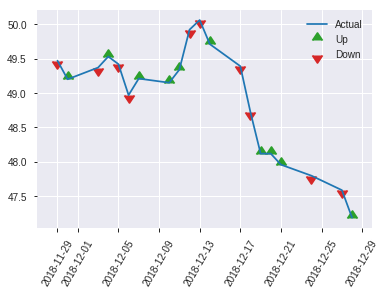


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19541831985047758
RMSE: 0.44206144352394905
LogLoss: 0.5733709799653963
Mean Per-Class Error: 0.2645097790195581
AUC: 0.7690500381000762
pr_auc: 0.7322940613396095
Gini: 0.5381000762001524
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4222472906112671: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      75   49   0.3952   (49.0/124.0)
1      17   110  0.1339   (17.0/127.0)
Total  92   159  0.2629   (66.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.422247     0.769231  158
max f2                       0.275845     0.869565  204
max f0point5                 0.422247     0.720839  158
max accuracy                 0.422247     0.737052  158
max precision                0.886603     1         0
max recall                   0.15859      1         236
max specificity              0.886603     1         0
max absolute_mcc             0.422247     0.488678  158
max min_per_class_accuracy   0.503637     0.693548  126
max mean_per_class_accuracy  0.422247     0.73549   158

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 49.54 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.862348           1.97638    1.97638            1                0.878411  1                           0.878411            0.023622        0.023622                   97.6378   97.6378
    2        0.0239044                   0.844482           1.97638    1.97638            1                0.849868  1                           0.86414             0.023622        0.0472441                  97.6378   97.6378
    3        0.0318725                   0.822238           1.97638    1.97638            1                0.831812  1                           0.856058            0.015748        0.0629921                  97.6378   97.6378
    4        0.0438247                   0.818782           1.31759    1.79671            0.666667         0.82055   0.909091                    0.846374            0.015748        0.0787402                  31.7585   79.6707
    5        0.0517928                   0.817091           0.988189   1.67232            0.5              0.817394  0.846154                    0.841915            0.00787402      0.0866142                  -1.1811   67.232
    6        0.103586                    0.756684           1.21623    1.44428            0.615385         0.78639   0.730769                    0.814153            0.0629921       0.149606                   21.6233   44.4276
    7        0.151394                    0.726423           1.64698    1.50829            0.833333         0.741156  0.763158                    0.791101            0.0787402       0.228346                   64.6982   50.8288
    8        0.203187                    0.703514           1.82435    1.58885            0.923077         0.716119  0.803922                    0.771988            0.0944882       0.322835                   82.4349   58.8853
    9        0.302789                    0.629802           1.26488    1.48228            0.64             0.66513   0.75                        0.736837            0.125984        0.448819                   26.4882   48.2283
    10       0.40239                     0.556165           1.10677    1.38933            0.56             0.600282  0.70297                     0.703037            0.110236        0.559055                   10.6772   38.9335
    11       0.501992                    0.507005           1.34394    1.38033            0.68             0.531551  0.698413                    0.669012            0.133858        0.692913                   34.3937   38.0327
    12       0.601594                    0.440514           1.26488    1.36121            0.64             0.472892  0.688742                    0.636542            0.125984        0.818898                   26.4882   36.1214
    13       0.701195                    0.379622           0.790551   1.28015            0.4              0.41072   0.647727                    0.604465            0.0787402       0.897638                   -20.9449  28.0154
    14       0.800797                    0.287401           0.553386   1.18976            0.28             0.333596  0.60199                     0.570774            0.0551181       0.952756                   -44.6614  18.976
    15       0.900398                    0.194286           0.395276   1.10187            0.2              0.239086  0.557522                    0.534083            0.0393701       0.992126                   -60.4724  10.1874
    16       1                           0.0879307          0.0790551  1                  0.04             0.145363  0.505976                    0

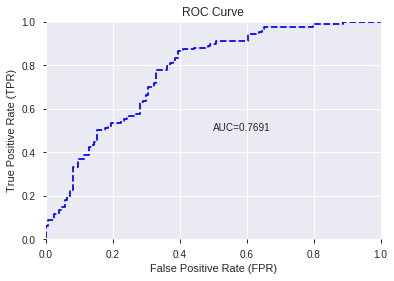

This function is available for GLM models only


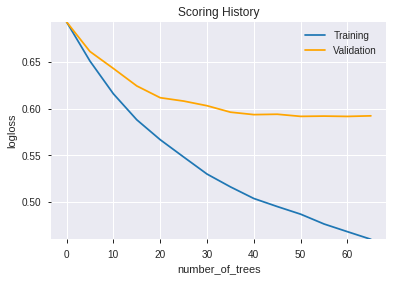

--2019-09-03 02:32:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_023145_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_023145_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_83a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'SUB',
 'CCI_8',
 'DIV',
 'SIN',
 'MFI_8',
 'TRANGE',
 'Volume',
 'WILLR_8',
 'dayofyear',
 'ULTOSC',
 'STOCHRSI_fastd',
 'BETA_8',
 'OBV',
 'COS',
 'day',
 'CDLCLOSINGMARUBOZU',
 'HT_DCPERIOD',
 'week',
 'BETA_12',
 'aroonup_8',
 'ADOSC',
 'aroonup_14',
 'aroonup_20',
 'aroondown_30',
 'STOCHRSI_fastk',
 'TANH',
 'dayofweek',
 'aroondown_8',
 'weekday_name',
 'AROONOSC_8',
 'CDLLONGLINE',
 'CDLSPINNINGTOP',
 'weekday',
 'CDLLONGLEGGEDDOJI',
 'days_in_month',
 'quarter',
 'CDLRICKSHAWMAN',
 'CDLHAMMER',
 'HT_TRENDMODE']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_023214_model_1  0.539148  1.82923              0.427038  0.587556  0.345222

variable  relative_importance  scaled_importance    percentage
0                          BOP         9.234543e-03           1.000000  2.646571e-02
1           CDLCLOSINGMARUBOZU         7.131631e-03           0.772278  2.043887e-02
2                  CDLLONGLINE         6.206541e-03           0.672101  1.778761e-02
3                 STOCHF_fastk         6.197601e-03           0.671132  1.776199e-02
4               STOCHRSI_fastk         5.079075e-03           0.550008  1.455636e-02
...                        ...                  ...                ...           ...
1036             MINMAX_min_12         2.848876e-07           0.000031  8.164726e-07
1037                   MA_30_5         1.929965e-07           0.000021  5.531177e-07
1038  BBANDS_middleband_30_6_4         5.217579e-08           0.000006  1.495330e-07
1039           CDLADVANCEBLOCK         0.000000e+00           0.000000  0.000000e+00
1040              CDLTASUKIGAP         0.000000e+00           0.000000  0.000000e+00

[1041 rows x 4 columns]

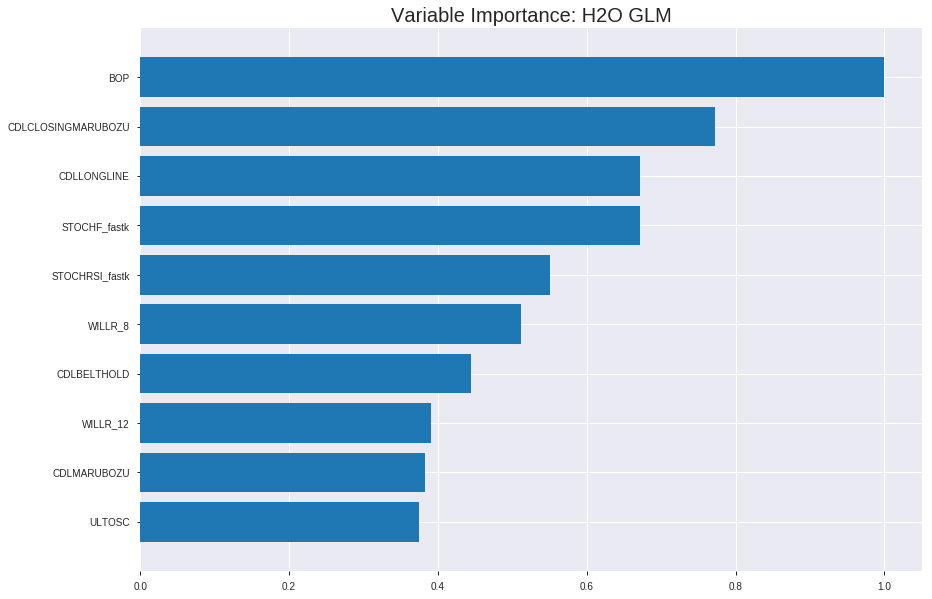

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_023214_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24247008794414662
RMSE: 0.49241251806198694
LogLoss: 0.6780020589322228
Null degrees of freedom: 1753
Residual degrees of freedom: 714
Null deviance: 2422.786744110176
Residual deviance: 2378.4312227342375
AIC: 4458.431222734238
AUC: 0.6444396532010951
pr_auc: 0.6628537101284541
Gini: 0.2888793064021902
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48562144742787294: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      76   739   0.9067   (739.0/815.0)
1      26   913   0.0277   (26.0/939.0)
Total  102  1652  0.4361   (765.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.485621     0.704747  346
max f2                       0.451744     0.852417  392
max f0point5                 0.536413     0.635437  190
max accuracy                 0.536413     0.609464  190
max precision                0.606722     1         0
max recall                   0.422087     1         399
max specificity              0.606722     1         0
max absolute_mcc             0.545735     0.219749  149
max min_per_class_accuracy   0.537766     0.601704  183
max mean_per_class_accuracy  0.544666     0.608398  154

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 53.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.5861             1.6604    1.6604             0.888889         0.59311   0.888889                    0.59311             0.0170394       0.0170394                  66.0395   66.0395
    2        0.0205245                   0.582041           1.45285   1.55662            0.777778         0.584193  0.833333                    0.588652            0.0149095       0.0319489                  45.2846   55.6621
    3        0.0302166                   0.579209           0.988912  1.37453            0.529412         0.580776  0.735849                    0.586126            0.00958466      0.0415335                  -1.10881  37.4525
    4        0.0404789                   0.577355           1.6604    1.447              0.888889         0.578345  0.774648                    0.584153            0.0170394       0.0585729                  66.0395   44.6999
    5        0.050171                    0.575045           1.09879   1.37973            0.588235         0.576439  0.738636                    0.582663            0.0106496       0.0692226                  9.8791    37.9732
    6        0.100342                    0.569113           1.35851   1.36912            0.727273         0.571924  0.732955                    0.577294            0.0681576       0.13738                    35.8505   36.9119
    7        0.149943                    0.564371           1.33118   1.35657            0.712644         0.566677  0.726236                    0.573782            0.0660277       0.203408                   33.1179   35.6568
    8        0.200114                    0.559856           1.33728   1.35173            0.715909         0.562225  0.723647                    0.570884            0.0670927       0.270501                   33.7279   35.1732
    9        0.299886                    0.55321            1.15279   1.28554            0.617143         0.556484  0.688213                    0.566093            0.115016        0.385517                   15.2789   28.5544
    10       0.400228                    0.545629           1.14624   1.25062            0.613636         0.549538  0.669516                    0.561943            0.115016        0.500532                   14.6239   25.0618
    11       0.5                         0.537911           0.982005  1.19702            0.525714         0.542053  0.640821                    0.557974            0.0979766       0.598509                   -1.79948  19.7018
    12       0.599772                    0.53023            0.896613  1.14705            0.48             0.534045  0.614068                    0.553993            0.0894569       0.687966                   -10.3387  14.7046
    13       0.700114                    0.522411           0.891519  1.11042            0.477273         0.526231  0.594463                    0.550014            0.0894569       0.777423                   -10.8481  11.0423
    14       0.799886                    0.513575           0.928635  1.08775            0.497143         0.51805   0.582324                    0.546027            0.0926518       0.870075                   -7.13647  8.77482
    15       0.899658                    0.497295           0.693808  1.04406            0.371429         0.506118  0.558935                    0.541601            0.0692226       0.939297                   -30.6192  4.40603
    16       1                           0.422087           0.604959  1                  0.323864         0.479279  0.535348                    0.535348         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.3168478048142989
RMSE: 0.5628923563296084
LogLoss: 2.519010776592764
Null degrees of freedom: 501
Residual degrees of freedom: -538
Null deviance: 696.1689483589155
Residual deviance: 9269.286700699959
AIC: 11349.286700699959
AUC: 0.5798020242464688
pr_auc: 0.4784352723964688
Gini: 0.15960404849293752
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47489659806635653: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      24   219  0.9012   (219.0/243.0)
1      7    252  0.027    (7.0/259.0)
Total  31   471  0.4502   (226.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.474897     0.690411  368
max f2                       0.4553       0.843099  397
max f0point5                 0.494787     0.604817  290
max accuracy                 0.494787     0.583665  290
max precision                0.999926     0.612245  7
max recall                   0.4553       1         397
max specificity              1            0.880658  0
max absolute_mcc             0.489543     0.189768  314
max min_per_class_accuracy   0.521243     0.548263  156
max mean_per_class_accuracy  0.508663     0.57614   210

Gains/Lift Table: Avg response rate: 51.59 %, avg score: 68.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0278884                   1                  1.246     1.246              0.642857         1         0.642857                    1                   0.034749        0.034749                   24.6001   24.6001
    2        0.0318725                   1                  0.969112  1.21139            0.5              1         0.625                       1                   0.003861        0.03861                    -3.0888   21.139
    3        0.0418327                   1                  1.55058   1.29215            0.8              1         0.666667                    1                   0.015444        0.0540541                  55.0579   29.2149
    4        0.0517928                   1                  1.16293   1.2673             0.6              1         0.653846                    1                   0.011583        0.0656371                  16.2934   26.73
    5        0.101594                    1                  0.852819  1.06412            0.44             1         0.54902                     1                   0.042471        0.108108                   -14.7181  6.41229
    6        0.151394                    0.999996           1.24046   1.12213            0.64             0.999999  0.578947                    1                   0.0617761       0.169884                   24.0463   12.213
    7        0.201195                    0.999892           1.31799   1.17061            0.68             0.999971  0.60396                     0.999993            0.0656371       0.235521                   31.7992   17.061
    8        0.300797                    0.96603            0.852819  1.06538            0.44             0.990507  0.549669                    0.996852            0.0849421       0.320463                   -14.7181  6.53814
    9        0.400398                    0.590841           1.00788   1.05108            0.52             0.800327  0.542289                    0.947965            0.100386        0.420849                   0.787645  5.10767
    10       0.5                         0.521155           1.27923   1.09653            0.66             0.534757  0.565737                    0.865653            0.127413        0.548263                   27.9228   9.65251
    11       0.599602                    0.510244           1.12417   1.10112            0.58             0.515652  0.568106                    0.807513            0.111969        0.660232                   12.417    10.1117
    12       0.699203                    0.501073           1.04664   1.09336            0.54             0.505845  0.564103                    0.76454             0.104247        0.764479                   4.66409   9.33571
    13       0.798805                    0.493519           0.969112  1.07787            0.5              0.497487  0.55611                     0.731242            0.0965251       0.861004                   -3.0888   7.78652
    14       0.898406                    0.481313           0.77529   1.04432            0.4              0.487757  0.538803                    0.704248            0.0772201       0.938224                   -22.471   4.43202
    15       1                           0.449647           0.60807   1                  0.313725         0.468952  0.515936                    0.680344            0.0617761       1                          -39.193   0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-03 02:32:18  0.000 sec   2            18        1040          1.356             18.4647
    2019-09-03 02:32:20  2.053 sec   4            13        1040          1.34897           24.4073
    2019-09-03 02:32:22  4.151 sec   6            9.5       1041          1.34025           49.6861
    2019-09-03 02:32:25  6.457 sec   8            6.9       1042          1.3297            74.7453
    2019-09-03 02:32:27  8.505 sec   10           5         1042          1.31723           94.4104

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5776892430278885)

('F1', 0.6988636363636364)

('auc', 0.5391478282956567)

('logloss', 1.8292301234312376)

('mean_per_class_error', 0.4270383540767082)

('rmse', 0.5875556168851371)

('mse', 0.3452216029332741)

glm prediction progress: |████████████████████████████████████████████████| 100%


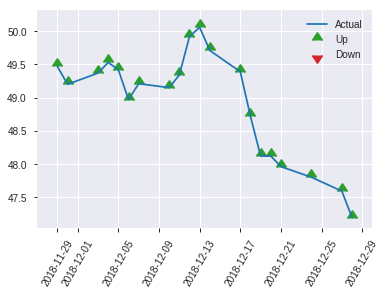


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.3452216029332741
RMSE: 0.5875556168851371
LogLoss: 1.8292301234312376
Null degrees of freedom: 250
Residual degrees of freedom: -789
Null deviance: 348.7926110092956
Residual deviance: 918.2735219624813
AIC: 2998.273521962481
AUC: 0.5391478282956567
pr_auc: 0.5061117400790845
Gini: 0.07829565659131332
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49658496559718807: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      22   102  0.8226   (102.0/124.0)
1      4    123  0.0315   (4.0/127.0)
Total  26   225  0.4223   (106.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.496585     0.698864  220
max f2                       0.477325     0.845638  232
max f0point5                 0.496585     0.598832  220
max accuracy                 0.496585     0.577689  220
max precision                1            0.6       1
max recall                   0.462531     1         241
max specificity              1            0.983871  0
max absolute_mcc             0.496585     0.239419  220
max min_per_class_accuracy   0.814465     0.543307  119
max mean_per_class_accuracy  0.496585     0.572962  220

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 77.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   1                  0.658793  0.658793           0.333333         1         0.333333                    1                   0.00787402      0.00787402                 -34.1207  -34.1207
    2        0.0239044                   1                  1.31759   0.988189           0.666667         1         0.5                         1                   0.015748        0.023622                   31.7585   -1.1811
    3        0.0318725                   0.999999           0         0.741142           0                0.999999  0.375                       1                   0               0.023622                   -100      -25.8858
    4        0.0438247                   0.999999           0.658793  0.718683           0.333333         0.999999  0.363636                    0.999999            0.00787402      0.0314961                  -34.1207  -28.1317
    5        0.0517928                   0.999997           0.988189  0.760145           0.5              0.999998  0.384615                    0.999999            0.00787402      0.0393701                  -1.1811   -23.9855
    6        0.103586                    0.999922           0.912174  0.83616            0.461538         0.999982  0.423077                    0.999991            0.0472441       0.0866142                  -8.78256  -16.384
    7        0.151394                    0.998838           1.48228   1.0402             0.75             0.999502  0.526316                    0.999837            0.0708661       0.15748                    48.2283   4.01989
    8        0.203187                    0.996308           0.760145  0.968813           0.384615         0.997912  0.490196                    0.999346            0.0393701       0.19685                    -23.9855  -3.11873
    9        0.302789                    0.950377           1.02772   0.988189           0.52             0.974062  0.5                         0.991029            0.102362        0.299213                   2.77165   -1.1811
    10       0.40239                     0.887088           1.02772   0.997973           0.52             0.919023  0.50495                     0.973206            0.102362        0.401575                   2.77165   -0.202697
    11       0.501992                    0.814264           1.42299   1.0823             0.72             0.846645  0.547619                    0.948094            0.141732        0.543307                   42.2992   8.23022
    12       0.601594                    0.712747           0.948661  1.06018            0.48             0.770295  0.536424                    0.918657            0.0944882       0.637795                   -5.13386  6.01763
    13       0.701195                    0.613819           0.790551  1.02188            0.4              0.667608  0.517045                    0.882997            0.0787402       0.716535                   -20.9449  2.18772
    14       0.800797                    0.553372           1.18583   1.04227            0.6              0.581648  0.527363                    0.845516            0.11811         0.834646                   18.5827   4.2269
    15       0.900398                    0.495926           1.34394   1.07564            0.68             0.520772  0.544248                    0.809593            0.133858        0.968504                   34.3937   7.56393
    16       1                           0.438148           0.31622   1                  0.16             0.473214  0.505976                    0.776089   

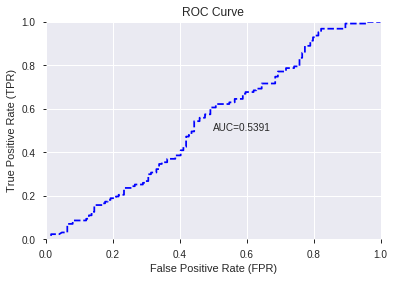

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


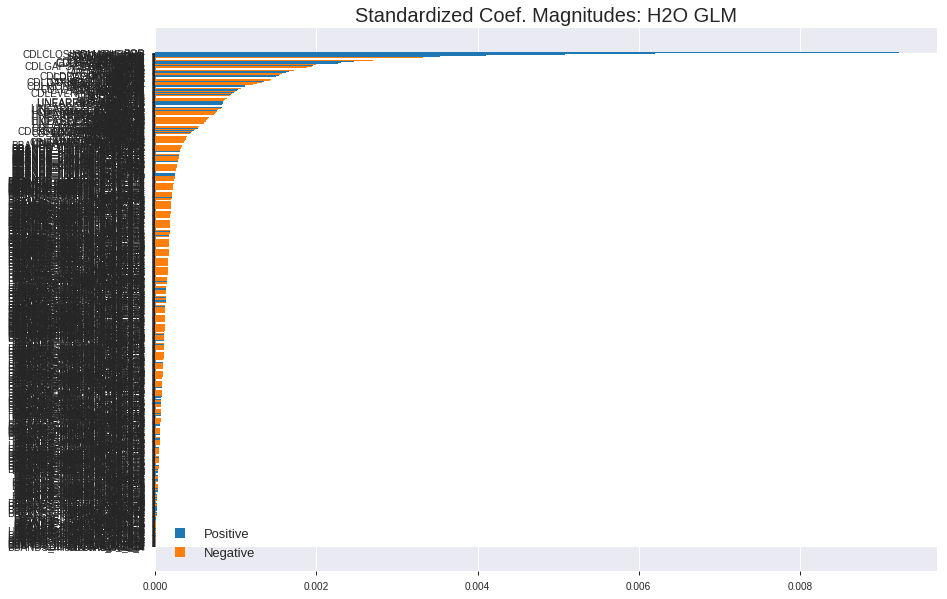

'log_likelihood'
--2019-09-03 02:32:50--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.106.172
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.106.172|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_023214_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_023214_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_83a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

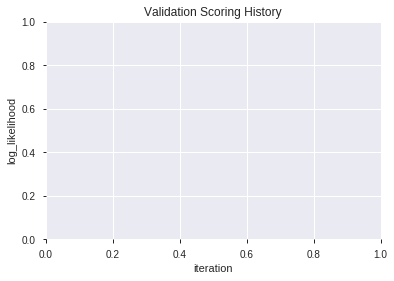

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190903_023256  0.778956  0.562942              0.305690  0.437379  0.191300
1  XGBoost_grid_1_AutoML_20190903_023256_model_4  0.778766  0.571420              0.284576  0.440085  0.193675
2  XGBoost_grid_1_AutoML_20190903_023256_model_7  0.766256  0.576188              0.276702  0.443335  0.196546
3  XGBoost_grid_1_AutoML_20190903_023256_model_2  0.763018  0.581196              0.297435  0.445382  0.198365
4  XGBoost_grid_1_AutoML_20190903_023256_model_6  0.759843  0.584432              0.280639  0.447206  0.199994
5  XGBoost_grid_1_AutoML_20190903_023256_model_1  0.757112  0.578169              0.284862  0.445019  0.198042
6  XGBoost_grid_1_AutoML_20190903_023256_model_3  0.754826  0.585275              0.272098  0.447161  0.199953
7               XGBoost_1_AutoML_20190903_023256  0.752858  0.582588              0.317977  0.447225  0.200010
8               XGBoost_2_AutoML_20190903_023256  0.750000  0.590919              0.301657  0.450603  0.203043
9  XGBoost_grid_1_AutoML_20190903_023256_model_5  0.749301  0.591180              0.358299  0.451808  0.204131

variable  relative_importance  scaled_importance  percentage
0                        BOP          1730.324585           1.000000    0.188029
1               STOCHF_fastk           543.764282           0.314256    0.059089
2                        SUB           448.522736           0.259213    0.048740
3         CDLCLOSINGMARUBOZU           257.693970           0.148928    0.028003
4                        DIV           249.870255           0.144407    0.027153
..                       ...                  ...                ...         ...
272                  ROCP_12             0.944860           0.000546    0.000103
273                    Close             0.646526           0.000374    0.000070
274  BBANDS_lowerband_24_1_5             0.619705           0.000358    0.000067
275               aroonup_20             0.490311           0.000283    0.000053
276                   CMO_12             0.174015           0.000101    0.000019

[277 rows x 4 columns]

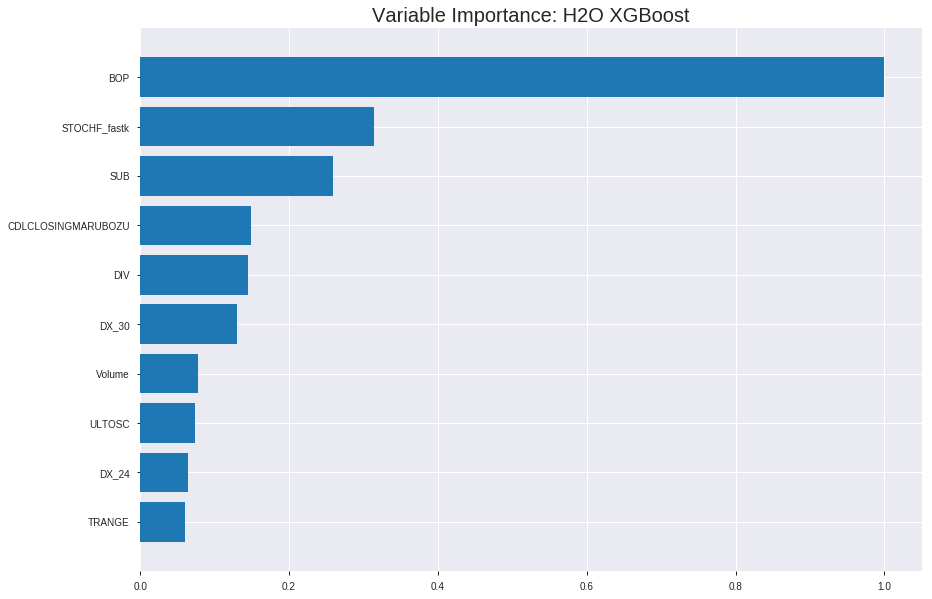

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190903_023256


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12706787943975267
RMSE: 0.35646581805238026
LogLoss: 0.42075887624667563
Mean Per-Class Error: 0.1412454183735472
AUC: 0.9440345753542797
pr_auc: 0.9536031066809852
Gini: 0.8880691507085594
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4787857085466385: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      631  184   0.2258   (184.0/815.0)
1      68   871   0.0724   (68.0/939.0)
Total  699  1055  0.1437   (252.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.478786     0.873621  215
max f2                       0.385735     0.918941  256
max f0point5                 0.624363     0.896942  144
max accuracy                 0.532624     0.859179  193
max precision                0.917447     1         0
max recall                   0.209546     1         341
max specificity              0.917447     1         0
max absolute_mcc             0.51069      0.717459  203
max min_per_class_accuracy   0.545346     0.851534  185
max mean_per_class_accuracy  0.587339     0.858755  165

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 53.34 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.878235           1.86794    1.86794            1                0.893786  1                           0.893786            0.0191693       0.0191693                  86.7945   86.7945
    2        0.0205245                   0.869574           1.86794    1.86794            1                0.874143  1                           0.883965            0.0191693       0.0383387                  86.7945   86.7945
    3        0.0302166                   0.862302           1.86794    1.86794            1                0.865025  1                           0.87789             0.0181044       0.056443                   86.7945   86.7945
    4        0.0404789                   0.854846           1.86794    1.86794            1                0.85853   1                           0.872982            0.0191693       0.0756124                  86.7945   86.7945
    5        0.050171                    0.847321           1.86794    1.86794            1                0.851627  1                           0.868856            0.0181044       0.0937167                  86.7945   86.7945
    6        0.100342                    0.812159           1.86794    1.86794            1                0.829054  1                           0.848955            0.0937167       0.187433                   86.7945   86.7945
    7        0.149943                    0.78332            1.86794    1.86794            1                0.796807  1                           0.831705            0.0926518       0.280085                   86.7945   86.7945
    8        0.200114                    0.759586           1.86794    1.86794            1                0.771814  1                           0.816689            0.0937167       0.373802                   86.7945   86.7945
    9        0.299886                    0.698556           1.81457    1.85019            0.971429         0.730571  0.990494                    0.788038            0.181044        0.554846                   81.4575   85.0188
    10       0.400228                    0.640992           1.58138    1.7828             0.846591         0.669753  0.954416                    0.758382            0.158679        0.713525                   58.1385   78.2796
    11       0.5                         0.570773           1.16346    1.65921            0.622857         0.603916  0.888255                    0.72756             0.116081        0.829606                   16.3463   65.9212
    12       0.599772                    0.478984           0.971331   1.54478            0.52             0.52671   0.826996                    0.694148            0.0969116       0.926518                   -2.86688  54.4783
    13       0.700114                    0.384854           0.488213   1.39335            0.261364         0.434398  0.745928                    0.65692             0.0489883       0.975506                   -51.1787  39.3353
    14       0.799886                    0.293428           0.170784   1.24086            0.0914286        0.343648  0.664291                    0.617845            0.0170394       0.992545                   -82.9216  24.0858
    15       0.899658                    0.198653           0.0747178  1.11153            0.04             0.247456  0.595057                    0.576769            0.00745474      1                          -92.5282  11.1534
    16       1                           0.0676665          0          1                  0                0.145026  0.535348                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2098928597290434
RMSE: 0.4581406549620361
LogLoss: 0.606330605741221
Mean Per-Class Error: 0.3382588938144494
AUC: 0.7275926720371164
pr_auc: 0.7137514075449692
Gini: 0.45518534407423283
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37739138305187225: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      102  141  0.5802   (141.0/243.0)
1      25   234  0.0965   (25.0/259.0)
Total  127  375  0.3307   (166.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.377391     0.73817   289
max f2                       0.262802     0.856071  338
max f0point5                 0.581615     0.669895  178
max accuracy                 0.381639     0.669323  288
max precision                0.899057     1         0
max recall                   0.131247     1         391
max specificity              0.899057     1         0
max absolute_mcc             0.377391     0.371573  289
max min_per_class_accuracy   0.571086     0.654321  185
max mean_per_class_accuracy  0.381639     0.661741  288

Gains/Lift Table: Avg response rate: 51.59 %, avg score: 52.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.86039            1.93822   1.93822            1                0.876842  1                           0.876842            0.023166        0.023166                   93.8224   93.8224
    2        0.0219124                   0.845766           0.77529   1.40962            0.4              0.849061  0.727273                    0.864214            0.00772201      0.030888                   -22.471   40.9617
    3        0.0318725                   0.830877           1.55058   1.45367            0.8              0.832939  0.75                        0.854441            0.015444        0.046332                   55.0579   45.3668
    4        0.0418327                   0.817031           1.55058   1.47674            0.8              0.824998  0.761905                    0.84743             0.015444        0.0617761                  55.0579   47.6742
    5        0.0517928                   0.810174           1.93822   1.56549            1                0.813056  0.807692                    0.84082             0.019305        0.0810811                  93.8224   56.5489
    6        0.101594                    0.765929           1.62811   1.59618            0.84             0.785253  0.823529                    0.813581            0.0810811       0.162162                   62.8108   59.6184
    7        0.151394                    0.736607           1.47305   1.55568            0.76             0.751531  0.802632                    0.79317             0.0733591       0.235521                   47.305    55.568
    8        0.201195                    0.714184           1.70564   1.5928             0.88             0.724585  0.821782                    0.776193            0.0849421       0.320463                   70.5637   59.2798
    9        0.300797                    0.669334           1.16293   1.45046            0.6              0.692411  0.748344                    0.748451            0.11583         0.436293                   16.2934   45.0459
    10       0.400398                    0.61461            1.08541   1.35965            0.56             0.64143   0.701493                    0.721829            0.108108        0.544402                   8.54054   35.965
    11       0.5                         0.574443           1.04664   1.2973             0.54             0.597044  0.669323                    0.696971            0.104247        0.648649                   4.66409   29.7297
    12       0.599602                    0.502145           0.969112  1.24278            0.5              0.53399   0.641196                    0.669898            0.0965251       0.745174                   -3.0888   24.2781
    13       0.699203                    0.414823           1.04664   1.21484            0.54             0.461572  0.626781                    0.640222            0.104247        0.849421                   4.66409   21.4841
    14       0.798805                    0.318479           0.77529   1.16003            0.4              0.371246  0.598504                    0.606684            0.0772201       0.926641                   -22.471   16.0034
    15       0.898406                    0.219036           0.465174  1.083              0.24             0.271349  0.558758                    0.569507            0.046332        0.972973                   -53.4826  8.29987
    16       1                           0.0604119          0.266031  1                  0.137255         0.166762  0.515936                    0.528591           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:33:10  0.008 sec   0                  0.5              0.693147            0.5             0                  1                0.464652                         0.5                0.693147              0.5               0                    1                  0.484064
    2019-09-03 02:33:11  1.241 sec   5                  0.473657         0.641595            0.847595        0.846704           1.86794          0.238312                         0.485144           0.663736              0.7179            0.704312             1.61519            0.332669
    2019-09-03 02:33:12  1.494 sec   10                 0.453101         0.602414            0.860529        0.871274           1.86794          0.230331                         0.477049           0.647597              0.709686          0.705419             1.93822            0.354582
    2019-09-03 02:33:12  1.758 sec   15                 0.436206         0.570448            0.8733          0.887802           1.86794          0.223489                         0.471371           0.635991              0.713682          0.706925             1.61519            0.38247
    2019-09-03 02:33:12  2.005 sec   20                 0.423753         0.546604            0.879443        0.8932             1.86794          0.221209                         0.465835           0.62458               0.722071          0.716203             1.93822            0.35259
    2019-09-03 02:33:12  2.252 sec   25                 0.411561         0.523646            0.894172        0.909386           1.86794          0.204675                         0.461687           0.615859              0.73108           0.732654             1.93822            0.356574
    2019-09-03 02:33:13  2.504 sec   30                 0.401126         0.503813            0.903881        0.918612           1.86794          0.179019                         0.460546           0.613004              0.728657          0.723721             1.93822            0.354582
    2019-09-03 02:33:13  2.746 sec   35                 0.393049         0.488438            0.911116        0.925408           1.86794          0.176739                         0.459662           0.610914              0.727386          0.720557             1.61519            0.348606
    2019-09-03 02:33:13  2.997 sec   40                 0.384833         0.472697            0.917394        0.930462           1.86794          0.177879                         0.4575             0.606266              0.73313           0.724717             1.61519            0.350598
    2019-09-03 02:33:13  3.238 sec   45                 0.378181         0.460399            0.924678        0.936794           1.86794          0.169327                         0.456819           0.604461              0.734751          0.726585             1.93822            0.334661
    2019-09-03 02:33:14  3.471 sec   50                 0.373302         0.451011            0.927945        0.939657           1.86794          0.160205                         0.456442           0.603504              0.734568          0.723788             1.93822            0.336653
    2019-09-03 02:33:14  3.704 sec   55                 0.366967         0.439612            0.935014        0.945826           1.86794          0.148803                         0.45775            0.605854              0.729841          0.7

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ---------------------
BOP                      1730.3245849609375     1.0                     0.18802884059858702
STOCHF_fastk             543.7642822265625      0.3142556529293249      0.05908912607185292
SUB                      448.5227355957031      0.25921306296750596     0.048739531697788684
CDLCLOSINGMARUBOZU       257.6939697265625      0.14892810976986726     0.02800277981256724
DIV                      249.87025451660156     0.14440657937148968     0.027152601694029038
---                      ---                    ---                     ---
ROCP_12                  0.9448604583740234     0.0005460596622080324   0.0001026749651826324
Close                    0.6465263366699219     0.0003736445417751013   7.025594998596261e-05
BBANDS_lowerband_24_1_5  0.6197052001953125     0.00035814390293096513  6.734138283556226e-05
aroonup_20               0.4903106689453125     0.000283363406615633    5.328049281400345e-05
CMO_12                   0.17401504516601562    0.0001005678626302036   1.890965861183515e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7211155378486056)

('F1', 0.7579617834394905)

('auc', 0.7789560579121158)

('logloss', 0.5629421956257141)

('mean_per_class_error', 0.2798768097536195)

('rmse', 0.4373788120518569)

('mse', 0.19130022523189355)

xgboost prediction progress: |████████████████████████████████████████████| 100%


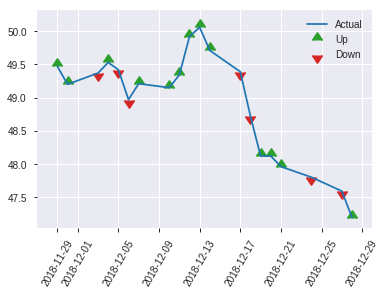


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19130022523189355
RMSE: 0.4373788120518569
LogLoss: 0.5629421956257141
Mean Per-Class Error: 0.2798768097536195
AUC: 0.7789560579121158
pr_auc: 0.7646064232519327
Gini: 0.5579121158242315
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3594858646392822: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      56   68   0.5484   (68.0/124.0)
1      8    119  0.063    (8.0/127.0)
Total  64   187  0.3028   (76.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.359486     0.757962  186
max f2                       0.336167     0.869873  198
max f0point5                 0.496285     0.713287  146
max accuracy                 0.496285     0.721116  146
max precision                0.856827     1         0
max recall                   0.214523     1         223
max specificity              0.856827     1         0
max absolute_mcc             0.496285     0.446821  146
max min_per_class_accuracy   0.547144     0.685039  125
max mean_per_class_accuracy  0.496285     0.720123  146

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 51.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.832919           1.97638   1.97638            1                0.847914  1                           0.847914            0.023622        0.023622                   97.6378   97.6378
    2        0.0239044                   0.82313            1.97638   1.97638            1                0.827927  1                           0.83792             0.023622        0.0472441                  97.6378   97.6378
    3        0.0318725                   0.814906           1.97638   1.97638            1                0.818025  1                           0.832946            0.015748        0.0629921                  97.6378   97.6378
    4        0.0438247                   0.792594           1.97638   1.97638            1                0.80197   1                           0.824498            0.023622        0.0866142                  97.6378   97.6378
    5        0.0517928                   0.776871           1.97638   1.97638            1                0.778878  1                           0.81748             0.015748        0.102362                   97.6378   97.6378
    6        0.103586                    0.754398           1.52029   1.74833            0.769231         0.765418  0.884615                    0.791449            0.0787402       0.181102                   52.0291   74.8334
    7        0.151394                    0.725784           1.81168   1.76834            0.916667         0.737433  0.894737                    0.774391            0.0866142       0.267717                   81.168    76.8338
    8        0.203187                    0.70408            1.36826   1.66636            0.692308         0.714761  0.843137                    0.759191            0.0708661       0.338583                   36.8262   66.6358
    9        0.302789                    0.653714           1.26488   1.53429            0.64             0.67763   0.776316                    0.732362            0.125984        0.464567                   26.4882   53.4293
    10       0.40239                     0.596672           0.948661  1.38933            0.48             0.624123  0.70297                     0.70557             0.0944882       0.559055                   -5.13386  38.9335
    11       0.501992                    0.547144           1.26488   1.36464            0.64             0.573102  0.690476                    0.679287            0.125984        0.685039                   26.4882   36.4642
    12       0.601594                    0.478449           1.18583   1.33504            0.6              0.514042  0.675497                    0.651928            0.11811         0.80315                    18.5827   33.5037
    13       0.701195                    0.394434           0.948661  1.28015            0.48             0.433803  0.647727                    0.620945            0.0944882       0.897638                   -5.13386  28.0154
    14       0.800797                    0.325267           0.711496  1.20943            0.36             0.358879  0.61194                     0.58835             0.0708661       0.968504                   -28.8504  20.9425
    15       0.900398                    0.209025           0.31622   1.11062            0.16             0.261452  0.561947                    0.552188            0.0314961       1                          -68.378   11.0619
    16       1                           0.0512007          0         1                  0                0.144865  0.505976                    0.511618         

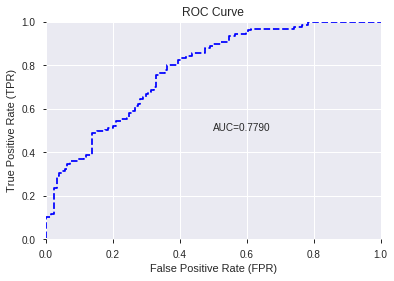

This function is available for GLM models only


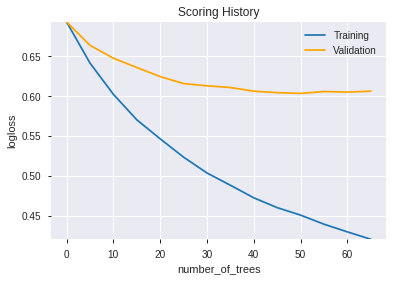

--2019-09-03 02:34:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.130.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.130.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190903_023256',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190903_023256',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_83a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_83a1',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_023406_model_7  0.777242  0.583708              0.273051  0.447171  0.199962
1  DeepLearning_grid_1_AutoML_20190903_023406_model_9  0.774194  0.573519              0.285052  0.441863  0.195243
2  DeepLearning_grid_1_AutoML_20190903_023406_model_6  0.762954  0.571613              0.305785  0.441707  0.195105
3  DeepLearning_grid_1_AutoML_20190903_023406_model_5  0.757176  0.637241              0.305404  0.471734  0.222533
4  DeepLearning_grid_1_AutoML_20190903_023406_model_8  0.746698  0.584056              0.293021  0.448605  0.201246
5  DeepLearning_grid_1_AutoML_20190903_023406_model_3  0.732410  0.703412              0.349759  0.490759  0.240844
6               DeepLearning_1_AutoML_20190903_023406  0.732347  0.643106              0.333534  0.464901  0.216133
7  DeepLearning_grid_1_AutoML_20190903_023406_model_2  0.724981  0.840881              0.341408  0.510953  0.261073
8  DeepLearning_grid_1_AutoML_20190903_023406_model_1  0.713805  0.913885              0.362141  0.519315  0.269688
9  DeepLearning_grid_1_AutoML_20190903_023406_model_4  0.685865  1.134254              0.430880  0.556656  0.309866

variable  relative_importance  scaled_importance  percentage
0    CDLCLOSINGMARUBOZU             1.000000           1.000000    0.022325
1                   BOP             0.975409           0.975409    0.021776
2             CDLINNECK             0.942573           0.942573    0.021043
3    CDLMORNINGDOJISTAR             0.942046           0.942046    0.021031
4           CDLLONGLINE             0.940865           0.940865    0.021005
5             dayofweek             0.934432           0.934432    0.020861
6                Volume             0.924485           0.924485    0.020639
7          STOCHF_fastk             0.920239           0.920239    0.020544
8                  TANH             0.919856           0.919856    0.020536
9               BETA_12             0.919447           0.919447    0.020527
10          HT_DCPERIOD             0.918701           0.918701    0.020510
11            CDLHAMMER             0.916537           0.916537    0.020462
12       CDLMORNINGSTAR             0.912659           0.912659    0.020375
13                  SUB             0.910879           0.910879    0.020335
14       CDLSPINNINGTOP             0.910356           0.910356    0.020324
15                  SIN             0.906957           0.906957    0.020248
16            dayofyear             0.902434           0.902434    0.020147
17         weekday_name             0.902398           0.902398    0.020146
18               ULTOSC             0.900164           0.900164    0.020096
19                  DIV             0.899820           0.899820    0.020088
20           aroonup_20             0.898809           0.898809    0.020066
21        days_in_month             0.898554           0.898554    0.020060
22       STOCHRSI_fastk             0.895555           0.895555    0.019993
23       STOCHRSI_fastd             0.895160           0.895160    0.019984
24    CDLLONGLEGGEDDOJI             0.894724           0.894724    0.019975
25                  day             0.894097           0.894097    0.019961
26   CDLEVENINGDOJISTAR             0.893706           0.893706    0.019952
27               BETA_8             0.892233           0.892233    0.019919
28     CDLDRAGONFLYDOJI             0.891670           0.891670    0.019907
29               TRANGE             0.890633           0.890633    0.019883
30         aroondown_30             0.888288           0.888288    0.019831
31                MFI_8             0.886406           0.886406    0.019789
32              WILLR_8             0.886350           0.886350    0.019788
33          aroondown_8             0.884841           0.884841    0.019754
34            CDLTAKURI             0.882870           0.882870    0.019710
35  CDLGAPSIDESIDEWHITE             0.880319           0.880319    0.019653
36            aroonup_8             0.880270           0.880270    0.019652
37                CCI_8             0.878846           0.878846    0.019620
38                  OBV             0.876778           0.876778    0.019574
39           aroonup_14             0.876543           0.876543    0.019569
40      CDLLADDERBOTTOM             0.875725           0.875725    0.019551
41           AROONOSC_8             0.873278           0.873278    0.019496
42              quarter             0.869454           0.869454    0.019411
43              weekday             0.861940           0.861940    0.019243
44         HT_TRENDMODE             0.852552           0.852552    0.019033
45                ADOSC             0.849769           0.849769    0.018971
46                 week             0.839765           0.839765    0.018748
47       CDLRICKSHAWMAN             0.836484           0.836484    0.018674
48                  COS             0.834906           0.834906    0.018639
49       CDL3LINESTRIKE             0.832125           0.832125    0.018577

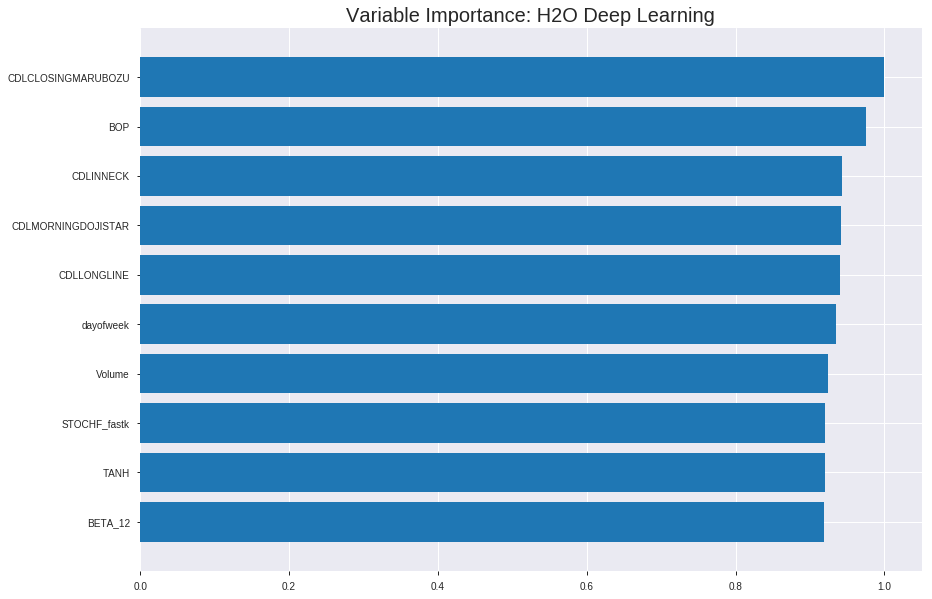

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_023406_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.17816213686238297
RMSE: 0.422092569067951
LogLoss: 0.5291367866440645
Mean Per-Class Error: 0.2603337318776665
AUC: 0.8078670037959714
pr_auc: 0.8192278854901387
Gini: 0.6157340075919429
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42555892880947116: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      476  339   0.416    (339.0/815.0)
1      128  811   0.1363   (128.0/939.0)
Total  604  1150  0.2662   (467.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.425559     0.776448  246
max f2                       0.135292     0.870298  351
max f0point5                 0.504642     0.756655  210
max accuracy                 0.496028     0.742303  214
max precision                0.997804     1         0
max recall                   0.0419328    1         384
max specificity              0.997804     1         0
max absolute_mcc             0.496028     0.48081   214
max min_per_class_accuracy   0.534185     0.733759  198
max mean_per_class_accuracy  0.504642     0.739666  210

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 53.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.989762           1.86794   1.86794            1                0.99409    1                           0.99409             0.0191693       0.0191693                  86.7945   86.7945
    2        0.0205245                   0.981342           1.76417   1.81606            0.944444         0.985615   0.972222                    0.989853            0.0181044       0.0372737                  76.417    81.6057
    3        0.0302166                   0.972722           1.86794   1.8327             1                0.976671   0.981132                    0.985625            0.0181044       0.0553781                  86.7945   83.27
    4        0.0404789                   0.965275           1.76417   1.81533            0.944444         0.968719   0.971831                    0.981339            0.0181044       0.0734824                  76.417    81.5326
    5        0.050171                    0.95668            1.75807   1.80426            0.941176         0.960655   0.965909                    0.977343            0.0170394       0.0905218                  75.8066   80.4265
    6        0.100342                    0.908235           1.74058   1.77242            0.931818         0.930687   0.948864                    0.954015            0.0873269       0.177849                   74.0585   77.2425
    7        0.149943                    0.859177           1.58883   1.71169            0.850575         0.882308   0.91635                     0.930295            0.0788072       0.256656                   58.8826   71.1691
    8        0.200114                    0.813005           1.40096   1.63379            0.75             0.835711   0.874644                    0.906581            0.0702875       0.326944                   40.0958   63.3786
    9        0.299886                    0.717085           1.36627   1.54478            0.731429         0.766232   0.826996                    0.859887            0.136315        0.463259                   36.6268   54.4783
    10       0.400228                    0.633173           1.2736    1.47679            0.681818         0.673768   0.790598                    0.813225            0.127796        0.591054                   27.3599   47.6794
    11       0.5                         0.546008           1.22751   1.42705            0.657143         0.586892   0.763968                    0.768062            0.122471        0.713525                   22.7506   42.705
    12       0.599772                    0.462338           1.01403   1.35834            0.542857         0.503465   0.727186                    0.724046            0.101171        0.814696                   1.40271   35.8344
    13       0.700114                    0.386841           0.764159  1.27318            0.409091         0.427375   0.681596                    0.681526            0.0766773       0.891374                   -23.5841  27.3184
    14       0.799886                    0.286459           0.576394  1.18627            0.308571         0.335429   0.635068                    0.638357            0.057508        0.948882                   -42.3606  18.6271
    15       0.899658                    0.138799           0.384263  1.09733            0.205714         0.215879   0.587452                    0.591504            0.0383387       0.98722                    -61.5737  9.73287
    16       1                           0.00148788         0.12736   1                  0.0681818        0.0668401  0.535348                    0.



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.22280200205362896
RMSE: 0.47201906958684303
LogLoss: 0.6499633489438661
Mean Per-Class Error: 0.32481688037243595
AUC: 0.7155806600251045
pr_auc: 0.6989157612102826
Gini: 0.4311613200502089
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3008990350444478: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      100  143  0.5885   (143.0/243.0)
1      31   228  0.1197   (31.0/259.0)
Total  131  371  0.3466   (174.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.300899     0.72381   292
max f2                       0.0489736    0.853821  375
max f0point5                 0.437446     0.682303  230
max accuracy                 0.437446     0.677291  230
max precision                0.993351     1         0
max recall                   0.022093     1         388
max specificity              0.993351     1         0
max absolute_mcc             0.437446     0.353847  230
max min_per_class_accuracy   0.489385     0.666667  206
max mean_per_class_accuracy  0.437446     0.675183  230

Gains/Lift Table: Avg response rate: 51.59 %, avg score: 48.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.981101           1.29215   1.29215            0.666667         0.987167   0.666667                    0.987167            0.015444        0.015444                   29.2149   29.2149
    2        0.0219124                   0.965845           1.93822   1.58582            1                0.972614   0.818182                    0.980552            0.019305        0.034749                   93.8224   58.582
    3        0.0318725                   0.952514           1.55058   1.57481            0.8              0.96013    0.8125                      0.97417             0.015444        0.0501931                  55.0579   57.4807
    4        0.0418327                   0.933876           1.93822   1.66133            1                0.942393   0.857143                    0.966604            0.019305        0.0694981                  93.8224   66.1335
    5        0.0517928                   0.925983           1.93822   1.71458            1                0.930163   0.884615                    0.959596            0.019305        0.0888031                  93.8224   71.4583
    6        0.101594                    0.87072            1.39552   1.55818            0.72             0.903783   0.803922                    0.932237            0.0694981       0.158301                   39.5521   55.818
    7        0.151394                    0.806227           1.47305   1.53018            0.76             0.837321   0.789474                    0.901015            0.0733591       0.23166                    47.305    53.0177
    8        0.201195                    0.750409           1.39552   1.49685            0.72             0.776508   0.772277                    0.870196            0.0694981       0.301158                   39.5521   49.6846
    9        0.300797                    0.64934            1.00788   1.33494            0.52             0.710199   0.688742                    0.817217            0.100386        0.401544                   0.787645  33.4936
    10       0.400398                    0.559939           1.27923   1.32108            0.66             0.595741   0.681592                    0.762123            0.127413        0.528958                   27.9228   32.1078
    11       0.5                         0.493062           1.27923   1.31274            0.66             0.526383   0.677291                    0.715163            0.127413        0.656371                   27.9228   31.2741
    12       0.599602                    0.417804           1.08541   1.27498            0.56             0.452778   0.657807                    0.671578            0.108108        0.764479                   8.54054   27.4978
    13       0.699203                    0.333579           0.736525  1.19828            0.38             0.37176    0.618234                    0.628869            0.0733591       0.837838                   -26.3475  19.8275
    14       0.798805                    0.219823           0.736525  1.1407             0.38             0.28306    0.588529                    0.58575             0.0733591       0.911197                   -26.3475  14.07
    15       0.898406                    0.0970492          0.620232  1.083              0.32             0.158731   0.558758                    0.538409            0.0617761       0.972973                   -37.9768  8.29987
    16       1                           0.00232114         0.266031  1                  0.137255         0.0404633  0.515936                    0.4


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:38:05  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 02:38:10  5.898 sec         231 obs/sec       0.659065  1             1156       0.543735         1.07837             -0.18853       0.70757         0.69887            1.6604           0.3626                           0.544187           1.07781               -0.185764        0.655497          0.626396             1.61519            0.368526
    2019-09-03 02:38:20  15.955 sec        478 obs/sec       3.86716   6             6783       0.422093         0.529137            0.283772       0.807867        0.819228           1.86794          0.266249                         0.472019           0.649963              0.107886         0.715581          0.698916             1.29215            0.346614
    2019-09-03 02:38:29  24.901 sec        561 obs/sec       7.12543   11            12498      0.470523         0.668182            0.109985       0.835448        0.847419           1.86794          0.264538                         0.53717            0.938558              -0.155379        0.719942          0.695338             1.61519            0.350598
    2019-09-03 02:38:38  33.603 sec        604 obs/sec       10.3877   16            18220      0.384124         0.454881            0.406829       0.879257        0.853595           1.86794          0.212087                         0.498954           0.823705              0.00316682       0.689142          0.647258             1.61519            0.342629
    2019-09-03 02:38:47  42.366 sec        629 obs/sec       13.6517   21            23945      0.340221         0.364701            0.534674       0.919589        0.894274           1.86794          0.159065                         0.523508           0.954058              -0.0973568       0.678909          0.64586              1.29215            0.38247
    2019-09-03 02:38:55  50.873 sec        646 obs/sec       16.8586   26            29570      0.314321         0.323284            0.602824       0.938975        0.88722            1.86794          0.124857                         0.51833            1.01319               -0.0757551       0.6813            0.640897             1.29215            0.36255
    2019-09-03 02:39:04  59.326 sec        661 obs/sec       20.1021   31            35259      0.297966         0.284617            0.643081       0.955402        0.841231           1.86794          0.120867                         0.527166           1.11447               -0.112747        0.685002          0.636027             1.29215            0.398406
    2019-09-03 02:39:04  1 min  0.239 sec  660 obs/sec       20.1021   31            35259      0.422093         0.529137            0.283772       0.807867        0.819228           1.86794          0.266249                         0.472019           0.649963              0.107886         0.715581          0.698916             1.29215            0.346614

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.022324962032783714
BOP                 0.9754093885421753     0.9754093885421753   0.02177597756562484
CDLINNECK           0.9425725936889648     0.9425725936889648   0.021042897367248608
CDLMORNINGDOJISTAR  0.9420462250709534     0.9420462250709534   0.021031146207836252
CDLLONGLINE         0.9408647418022156     0.9408647418022156   0.021004769638719313
---                 ---                    ---                  ---
ADOSC               0.849768877029419      0.849768877029419    0.018971057916323027
week                0.8397648334503174     0.8397648334503174   0.018747718023245274
CDLRICKSHAWMAN      0.836484432220459      0.836484432220459    0.018674483190336388
COS                 0.8349056839942932     0.8349056839942932   0.01863923769612791
CDL3LINESTRIKE      0.8321250081062317     0.8321250081062317   0.01857715921250146


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7290836653386454)

('F1', 0.7718120805369129)

('auc', 0.7772415544831089)

('logloss', 0.5837076251914294)

('mean_per_class_error', 0.27305054610109225)

('rmse', 0.44717099313576236)

('mse', 0.19996189710202403)

deeplearning prediction progress: |███████████████████████████████████████| 100%


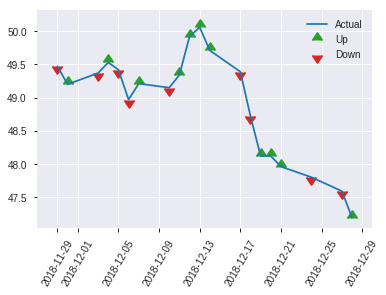


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19996189710202403
RMSE: 0.44717099313576236
LogLoss: 0.5837076251914294
Mean Per-Class Error: 0.27305054610109225
AUC: 0.7772415544831089
pr_auc: 0.7300629922616367
Gini: 0.5544831089662179
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2733903809195105: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      68   56   0.4516   (56.0/124.0)
1      12   115  0.0945   (12.0/127.0)
Total  80   171  0.2709   (68.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.27339      0.771812  170
max f2                       0.0721415    0.867486  223
max f0point5                 0.436279     0.729685  118
max accuracy                 0.27339      0.729084  170
max precision                0.83724      0.888889  17
max recall                   0.0721415    1         223
max specificity              0.985376     0.991935  0
max absolute_mcc             0.27339      0.487     170
max min_per_class_accuracy   0.421825     0.708661  124
max mean_per_class_accuracy  0.27339      0.726949  170

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 42.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.957938           1.31759   1.31759            0.666667         0.9795    0.666667                    0.9795              0.015748        0.015748                   31.7585   31.7585
    2        0.0239044                   0.913438           1.97638   1.64698            1                0.933676  0.833333                    0.956588            0.023622        0.0393701                  97.6378   64.6982
    3        0.0318725                   0.890179           0.988189  1.48228            0.5              0.901726  0.75                        0.942873            0.00787402      0.0472441                  -1.1811   48.2283
    4        0.0438247                   0.871668           1.97638   1.61704            1                0.877008  0.818182                    0.92491             0.023622        0.0708661                  97.6378   61.7037
    5        0.0517928                   0.86828            1.97638   1.67232            1                0.869251  0.846154                    0.916347            0.015748        0.0866142                  97.6378   67.232
    6        0.103586                    0.759225           1.36826   1.52029            0.692308         0.814808  0.769231                    0.865577            0.0708661       0.15748                    36.8262   52.0291
    7        0.151394                    0.692194           1.81168   1.61231            0.916667         0.724933  0.815789                    0.821163            0.0866142       0.244094                   81.168    61.2308
    8        0.203187                    0.654082           1.21623   1.51135            0.615385         0.670985  0.764706                    0.782883            0.0629921       0.307087                   21.6233   51.1348
    9        0.302789                    0.577905           1.50205   1.50829            0.76             0.615819  0.763158                    0.727927            0.149606        0.456693                   50.2047   50.8288
    10       0.40239                     0.501812           1.26488   1.44804            0.64             0.549215  0.732673                    0.683692            0.125984        0.582677                   26.4882   44.8039
    11       0.501992                    0.406626           1.26488   1.4117             0.64             0.453478  0.714286                    0.638014            0.125984        0.708661                   26.4882   41.1699
    12       0.601594                    0.35721            1.02772   1.34813            0.52             0.377711  0.682119                    0.594918            0.102362        0.811024                   2.77165   34.8125
    13       0.701195                    0.251559           1.02772   1.30261            0.52             0.302002  0.659091                    0.55331             0.102362        0.913386                   2.77165   30.2613
    14       0.800797                    0.141684           0.395276  1.18976            0.2              0.205943  0.60199                     0.510105            0.0393701       0.952756                   -60.4724  18.976
    15       0.900398                    0.0637684          0.474331  1.11062            0.24             0.101952  0.561947                    0.464956            0.0472441       1                          -52.5669  11.0619
    16       1                           0.00280418         0         1                  0                0.030784  0.505976                    0.421712           

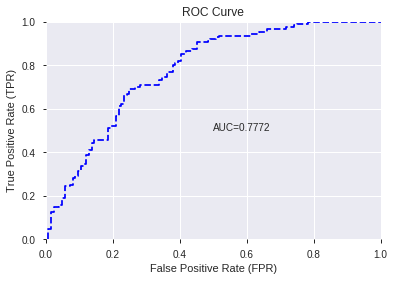

This function is available for GLM models only


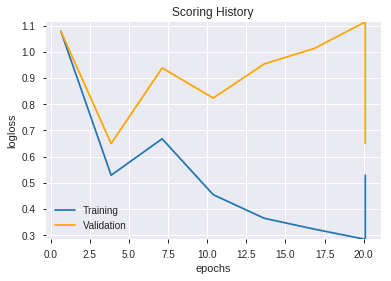

--2019-09-03 02:40:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.108
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.108|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_023406_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_023406_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_83a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'BOP',
 'CDLINNECK',
 'CDLMORNINGDOJISTAR',
 'CDLLONGLINE',
 'dayofweek',
 'Volume',
 'STOCHF_fastk',
 'TANH',
 'BETA_12',
 'HT_DCPERIOD',
 'CDLHAMMER',
 'CDLMORNINGSTAR',
 'SUB',
 'CDLSPINNINGTOP',
 'SIN',
 'dayofyear',
 'weekday_name',
 'ULTOSC',
 'DIV',
 'aroonup_20',
 'days_in_month',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'CDLLONGLEGGEDDOJI',
 'day',
 'CDLEVENINGDOJISTAR',
 'BETA_8',
 'CDLDRAGONFLYDOJI',
 'TRANGE',
 'aroondown_30',
 'MFI_8',
 'WILLR_8',
 'aroondown_8',
 'CDLTAKURI',
 'CDLGAPSIDESIDEWHITE',
 'aroonup_8',
 'CCI_8',
 'OBV',
 'aroonup_14',
 'CDLLADDERBOTTOM',
 'AROONOSC_8',
 'quarter',
 'weekday',
 'HT_TRENDMODE',
 'ADOSC',
 'week',
 'CDLRICKSHAWMAN',
 'COS',
 'CDL3LINESTRIKE']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_024102_model_1  0.77159  0.574914               0.28918  0.442634  0.195925

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.424293           1.000000    0.096637
1                 CCI_8             0.311864           0.735019    0.071030
2          STOCHF_fastk             0.266651           0.628459    0.060732
3    CDLCLOSINGMARUBOZU             0.255998           0.603352    0.058306
4               WILLR_8             0.219004           0.516162    0.049880
5                 MFI_8             0.205466           0.484255    0.046797
6   CDLGAPSIDESIDEWHITE             0.203268           0.479075    0.046296
7                ULTOSC             0.193693           0.456508    0.044116
8                   DIV             0.151848           0.357884    0.034585
9        STOCHRSI_fastd             0.138960           0.327509    0.031649
10            CDLHAMMER             0.117617           0.277207    0.026788
11               TRANGE             0.115497           0.272211    0.026306
12       CDLSPINNINGTOP             0.115228           0.271577    0.026244
13                  SUB             0.113195           0.266785    0.025781
14         aroondown_30             0.108738           0.256279    0.024766
15      CDLLADDERBOTTOM             0.088420           0.208394    0.020139
16   CDLMORNINGDOJISTAR             0.086825           0.204635    0.019775
17           aroonup_14             0.082258           0.193872    0.018735
18                  day             0.075359           0.177610    0.017164
19                 TANH             0.070451           0.166043    0.016046
20          CDLLONGLINE             0.067396           0.158844    0.015350
21       CDL3LINESTRIKE             0.067045           0.158017    0.015270
22                 week             0.066484           0.156694    0.015142
23                  SIN             0.062268           0.146756    0.014182
24                  COS             0.059289           0.139736    0.013504
25         HT_TRENDMODE             0.055973           0.131920    0.012748
26     CDLDRAGONFLYDOJI             0.054328           0.128043    0.012374
27            CDLTAKURI             0.054170           0.127672    0.012338
28   CDLEVENINGDOJISTAR             0.054126           0.127566    0.012328
29              BETA_12             0.049434           0.116508    0.011259
30          aroondown_8             0.046455           0.109487    0.010580
31          HT_DCPERIOD             0.043803           0.103238    0.009977
32       STOCHRSI_fastk             0.043349           0.102168    0.009873
33                  OBV             0.042445           0.100036    0.009667
34              quarter             0.042055           0.099118    0.009578
35                ADOSC             0.040579           0.095639    0.009242
36        days_in_month             0.025626           0.060396    0.005836
37    CDLLONGLEGGEDDOJI             0.025542           0.060199    0.005818
38           AROONOSC_8             0.024580           0.057930    0.005598
39       CDLMORNINGSTAR             0.024340           0.057366    0.005544
40            CDLINNECK             0.022685           0.053466    0.005167
41       CDLRICKSHAWMAN             0.021006           0.049507    0.004784
42               Volume             0.014945           0.035223    0.003404
43           aroonup_20             0.013353           0.031471    0.003041
44         weekday_name             0.007899           0.018617    0.001799
45            dayofyear             0.007159           0.016873    0.001631
46            dayofweek             0.003569           0.008411    0.000813
47              weekday             0.003477           0.008196    0.000792
48            aroonup_8             0.002364           0.005571    0.000538
49               BETA_8             0.000210           0.000494    0.000048

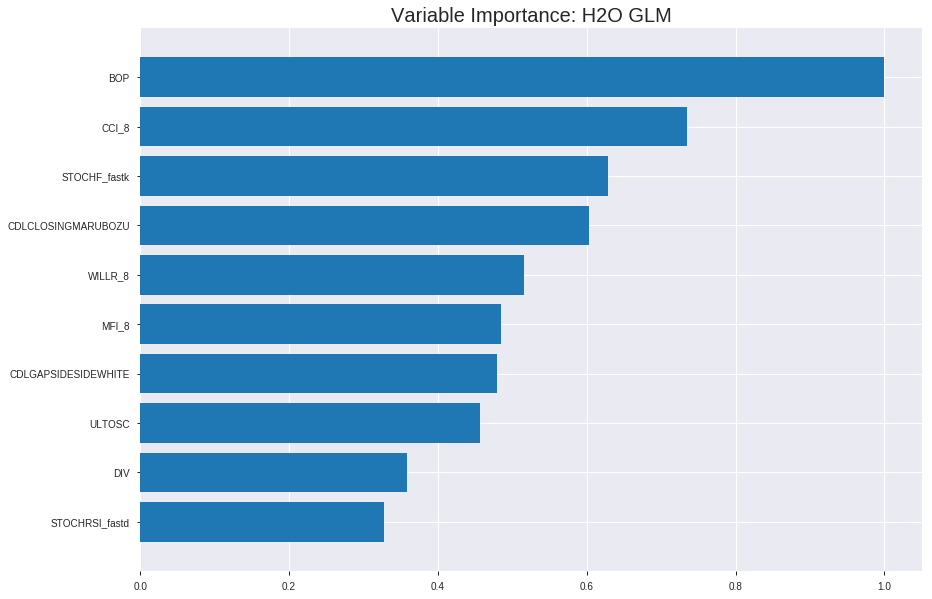

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_024102_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.19535533944312744
RMSE: 0.4419902028813845
LogLoss: 0.5733445062162127
Null degrees of freedom: 1753
Residual degrees of freedom: 1703
Null deviance: 2422.786744110176
Residual deviance: 2011.292527806474
AIC: 2113.292527806474
AUC: 0.7682941649189517
pr_auc: 0.7786364815525052
Gini: 0.5365883298379035
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3938372611656771: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      362  453   0.5558   (453.0/815.0)
1      105  834   0.1118   (105.0/939.0)
Total  467  1287  0.3181   (558.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.393837     0.749326  267
max f2                       0.179335     0.86108   358
max f0point5                 0.515488     0.731834  203
max accuracy                 0.515488     0.715507  203
max precision                0.993907     1         0
max recall                   0.0646728    1         391
max specificity              0.993907     1         0
max absolute_mcc             0.515488     0.427109  203
max min_per_class_accuracy   0.539154     0.70184   191
max mean_per_class_accuracy  0.515488     0.712985  203

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 53.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.932421           1.86794   1.86794            1                0.958638  1                           0.958638            0.0191693       0.0191693                  86.7945   86.7945
    2        0.0205245                   0.920019           1.6604    1.76417            0.888889         0.925202  0.944444                    0.94192             0.0170394       0.0362087                  66.0395   76.417
    3        0.0302166                   0.895643           1.64819   1.72697            0.882353         0.904275  0.924528                    0.929845            0.0159744       0.0521832                  64.8186   72.6968
    4        0.0404789                   0.880038           1.76417   1.7364             0.944444         0.886861  0.929577                    0.918948            0.0181044       0.0702875                  76.417    73.6399
    5        0.050171                    0.867559           1.53831   1.69813            0.823529         0.876057  0.909091                    0.910662            0.0149095       0.085197                   53.8307   69.8131
    6        0.100342                    0.809484           1.52832   1.61322            0.818182         0.839214  0.863636                    0.874938            0.0766773       0.161874                   52.8318   61.3225
    7        0.149943                    0.76868            1.52441   1.58385            0.816092         0.787547  0.847909                    0.846029            0.0756124       0.237487                   52.4415   58.3847
    8        0.200114                    0.732801           1.48587   1.55928            0.795455         0.750833  0.834758                    0.822162            0.0745474       0.312034                   48.5865   55.9281
    9        0.299886                    0.664981           1.35559   1.49151            0.725714         0.699917  0.798479                    0.781491            0.13525         0.447284                   35.5594   49.1515
    10       0.400228                    0.613514           1.2736    1.43688            0.681818         0.639121  0.769231                    0.745797            0.127796        0.57508                    27.3599   43.688
    11       0.5                         0.547984           1.14211   1.37806            0.611429         0.579387  0.737742                    0.712591            0.113951        0.689031                   14.2115   37.8062
    12       0.599772                    0.485381           0.960657  1.30863            0.514286         0.516018  0.70057                     0.679891            0.0958466       0.784878                   -3.93428  30.8627
    13       0.700114                    0.413214           0.753546  1.22907            0.403409         0.44828   0.65798                     0.646696            0.0756124       0.86049                    -24.6454  22.9071
    14       0.799886                    0.343349           0.587068  1.14899            0.314286         0.379574  0.61511                     0.613377            0.0585729       0.919063                   -41.2932  14.8992
    15       0.899658                    0.231808           0.56572   1.08431            0.302857         0.294134  0.580482                    0.577973            0.056443        0.975506                   -43.428   8.43075
    16       1                           0.0218079          0.244106  1                  0.130682         0.15317   0.535348                    0.535348           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.21129130519033396
RMSE: 0.45966433969836507
LogLoss: 0.610542484635181
Null degrees of freedom: 501
Residual degrees of freedom: 451
Null deviance: 696.1689483589155
Residual deviance: 612.9846545737216
AIC: 714.9846545737216
AUC: 0.7254397254397255
pr_auc: 0.7076309796196912
Gini: 0.4508794508794509
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2893801402632463: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      71   172  0.7078   (172.0/243.0)
1      13   246  0.0502   (13.0/259.0)
Total  84   418  0.3685   (185.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.28938      0.726736  330
max f2                       0.161927     0.853254  370
max f0point5                 0.5009       0.689278  220
max accuracy                 0.5009       0.683267  220
max precision                0.835934     0.866667  27
max recall                   0.090122     1         390
max specificity              0.945384     0.995885  0
max absolute_mcc             0.5009       0.36541   220
max min_per_class_accuracy   0.541246     0.671815  199
max mean_per_class_accuracy  0.5009       0.681737  220

Gains/Lift Table: Avg response rate: 51.59 %, avg score: 52.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.914148           1.61519   1.61519            0.833333         0.932052  0.833333                    0.932052            0.019305        0.019305                   61.5187   61.5187
    2        0.0219124                   0.893234           1.16293   1.40962            0.6              0.898327  0.727273                    0.916722            0.011583        0.030888                   16.2934   40.9617
    3        0.0318725                   0.881419           1.93822   1.57481            1                0.886889  0.8125                      0.907399            0.019305        0.0501931                  93.8224   57.4807
    4        0.0418327                   0.87055            1.93822   1.66133            1                0.877013  0.857143                    0.900165            0.019305        0.0694981                  93.8224   66.1335
    5        0.0517928                   0.848822           1.55058   1.64004            0.8              0.857706  0.846154                    0.891999            0.015444        0.0849421                  55.0579   64.0036
    6        0.101594                    0.79588            1.31799   1.48217            0.68             0.816081  0.764706                    0.854784            0.0656371       0.150579                   31.7992   48.2171
    7        0.151394                    0.755564           1.78317   1.58118            0.92             0.773842  0.815789                    0.828159            0.0888031       0.239382                   78.3166   58.1183
    8        0.201195                    0.724141           1.31799   1.51604            0.68             0.737929  0.782178                    0.805825            0.0656371       0.305019                   31.7992   51.6037
    9        0.300797                    0.656019           1.2017    1.41195            0.62             0.69421   0.728477                    0.768866            0.119691        0.42471                    20.1699   41.1951
    10       0.400398                    0.599041           1.27923   1.37894            0.66             0.628136  0.711443                    0.733859            0.127413        0.552124                   27.9228   37.8935
    11       0.5                         0.543835           1.16293   1.33591            0.6              0.57021   0.689243                    0.701259            0.11583         0.667954                   16.2934   33.5907
    12       0.599602                    0.473265           0.852819  1.25566            0.44             0.506367  0.647841                    0.668885            0.0849421       0.752896                   -14.7181  25.566
    13       0.699203                    0.409369           0.891583  1.2038             0.46             0.441717  0.621083                    0.636525            0.0888031       0.841699                   -10.8417  20.3797
    14       0.798805                    0.315967           0.658996  1.13587            0.34             0.365128  0.586035                    0.602685            0.0656371       0.907336                   -34.1004  13.5867
    15       0.898406                    0.218672           0.620232  1.0787             0.32             0.270161  0.556541                    0.56582             0.0617761       0.969112                   -37.9768  7.87011
    16       1                           0.00274708         0.304035  1                  0.156863         0.138062  0.515936                    0.522362          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-03 02:41:03  0.000 sec   2            18        51            1.3664            1.37309
    2019-09-03 02:41:03  0.015 sec   4            11        51            1.35844           1.36582
    2019-09-03 02:41:03  0.029 sec   6            6.9       51            1.34701           1.35547
    2019-09-03 02:41:03  0.050 sec   8            4.3       51            1.33148           1.34158
    2019-09-03 02:41:03  0.063 sec   10           2.7       51            1.31167           1.32424
    2019-09-03 02:41:03  0.074 sec   12           1.7       51            1.28822           1.30437
    2019-09-03 02:41:03  0.089 sec   14           1         51            1.26273           1.28379
    2019-09-03 02:41:03  0.101 sec   16           0.64      51            1.2373            1.26463
    2019-09-03 02:41:03  0.118 sec   18           0.4       51            1.21397           1.24866
    2019-09-03 02:41:03  0.138 sec   20           0.25      51            1.19413           1.23682
    2019-09-03 02:41:03  0.152 sec   22           0.15      51            1.17832           1.22899
    2019-09-03 02:41:03  0.172 sec   24           0.095     51            1.16633           1.22441
    2019-09-03 02:41:03  0.186 sec   26           0.059     51            1.15753           1.22205
    2019-09-03 02:41:03  0.199 sec   28           0.037     51            1.15119           1.22109
    2019-09-03 02:41:03  0.214 sec   30           0.023     51            1.14669           1.22108
    2019-09-03 02:41:03  0.227 sec   32           0.014     51            1.14358           1.22186
    2019-09-03 02:41:03  0.243 sec   34           0.0088    51            1.14153           1.22332
    2019-09-03 02:41:03  0.255 sec   36           0.0054    51            1.14025           1.22541
    2019-09-03 02:41:03  0.275 sec   38           0.0034    51            1.1395            1.22793
    2019-09-03 02:41:03  0.284 sec   39           0.0021    51            1.13909           1.23033

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7211155378486056)

('F1', 0.7615894039735098)

('auc', 0.7715900431800864)

('logloss', 0.5749140052626974)

('mean_per_class_error', 0.2806388112776226)

('rmse', 0.44263429115707653)

('mse', 0.19592511570812762)

glm prediction progress: |████████████████████████████████████████████████| 100%


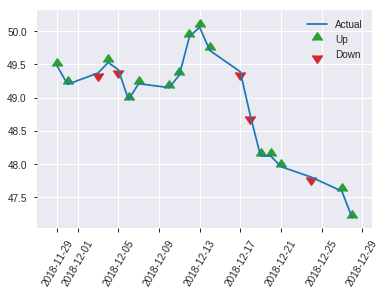


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19592511570812762
RMSE: 0.44263429115707653
LogLoss: 0.5749140052626974
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 348.7926110092956
Residual deviance: 288.6068306418741
AIC: 390.6068306418741
AUC: 0.7715900431800864
pr_auc: 0.7319532647409223
Gini: 0.5431800863601728
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36786398810723203: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   60   0.4839   (60.0/124.0)
1      12   115  0.0945   (12.0/127.0)
Total  76   175  0.2869   (72.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.367864     0.761589  174
max f2                       0.247026     0.866852  212
max f0point5                 0.528406     0.716878  105
max accuracy                 0.391474     0.721116  162
max precision                0.928787     1         0
max recall                   0.127034     1         238
max specificity              0.928787     1         0
max absolute_mcc             0.388588     0.461979  164
max min_per_class_accuracy   0.492551     0.692913  125
max mean_per_class_accuracy  0.391474     0.719361  162

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 48.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.907206           1.31759   1.31759            0.666667         0.920571  0.666667                    0.920571            0.015748        0.015748                   31.7585   31.7585
    2        0.0239044                   0.878453           1.97638   1.64698            1                0.895369  0.833333                    0.90797             0.023622        0.0393701                  97.6378   64.6982
    3        0.0318725                   0.852084           0.988189  1.48228            0.5              0.857723  0.75                        0.895408            0.00787402      0.0472441                  -1.1811   48.2283
    4        0.0438247                   0.82315            1.97638   1.61704            1                0.834842  0.818182                    0.87889             0.023622        0.0708661                  97.6378   61.7037
    5        0.0517928                   0.81041            1.97638   1.67232            1                0.813103  0.846154                    0.868769            0.015748        0.0866142                  97.6378   67.232
    6        0.103586                    0.7498             1.82435   1.74833            0.923077         0.775824  0.884615                    0.822296            0.0944882       0.181102                   82.4349   74.8334
    7        0.151394                    0.70403            1.31759   1.61231            0.666667         0.721406  0.815789                    0.790436            0.0629921       0.244094                   31.7585   61.2308
    8        0.203187                    0.667712           1.36826   1.5501             0.692308         0.683149  0.784314                    0.763088            0.0708661       0.314961                   36.8262   55.01
    9        0.302789                    0.609653           1.18583   1.43027            0.6              0.64221   0.723684                    0.723326            0.11811         0.433071                   18.5827   43.0274
    10       0.40239                     0.541721           1.66016   1.48718            0.84             0.578469  0.752475                    0.68747             0.165354        0.598425                   66.0157   48.7175
    11       0.501992                    0.492551           0.948661  1.38033            0.48             0.514876  0.698413                    0.653225            0.0944882       0.692913                   -5.13386  38.0327
    12       0.601594                    0.416515           1.10677   1.33504            0.56             0.450621  0.675497                    0.619681            0.110236        0.80315                    10.6772   33.5037
    13       0.701195                    0.367122           1.02772   1.29138            0.52             0.388404  0.653409                    0.58683             0.102362        0.905512                   2.77165   29.1383
    14       0.800797                    0.287244           0.553386  1.19959            0.28             0.318009  0.606965                    0.553394            0.0551181       0.96063                    -44.6614  19.9593
    15       0.900398                    0.203103           0.237165  1.09313            0.12             0.238454  0.553097                    0.518556            0.023622        0.984252                   -76.2835  9.31294
    16       1                           0.0708751          0.15811   1                  0.08             0.137719  0.505976                    0.480624            

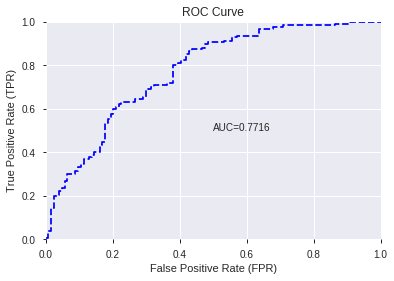

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


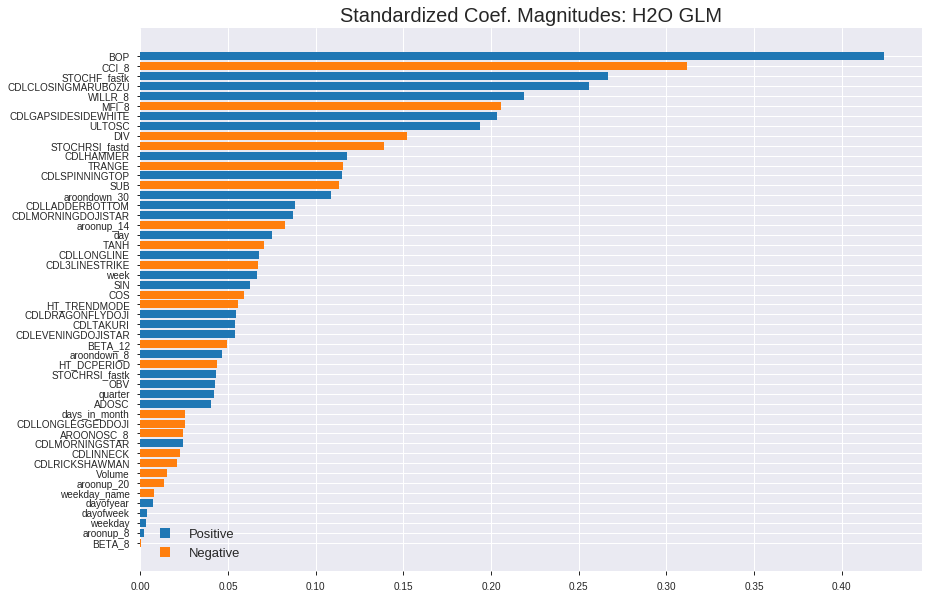

'log_likelihood'
--2019-09-03 02:41:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.16.208
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.16.208|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_024102_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_024102_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_83a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'CCI_8',
 'STOCHF_fastk',
 'CDLCLOSINGMARUBOZU',
 'WILLR_8',
 'MFI_8',
 'CDLGAPSIDESIDEWHITE',
 'ULTOSC',
 'DIV',
 'STOCHRSI_fastd',
 'CDLHAMMER',
 'TRANGE',
 'CDLSPINNINGTOP',
 'SUB',
 'aroondown_30',
 'CDLLADDERBOTTOM',
 'CDLMORNINGDOJISTAR',
 'aroonup_14',
 'day',
 'TANH',
 'CDLLONGLINE',
 'CDL3LINESTRIKE',
 'week',
 'SIN',
 'COS',
 'HT_TRENDMODE',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLEVENINGDOJISTAR',
 'BETA_12',
 'aroondown_8',
 'HT_DCPERIOD',
 'STOCHRSI_fastk',
 'OBV',
 'quarter',
 'ADOSC',
 'days_in_month',
 'CDLLONGLEGGEDDOJI',
 'AROONOSC_8',
 'CDLMORNINGSTAR',
 'CDLINNECK',
 'CDLRICKSHAWMAN',
 'Volume',
 'aroonup_20',
 'weekday_name',
 'dayofyear',
 'dayofweek',
 'weekday',
 'aroonup_8',
 'BETA_8']

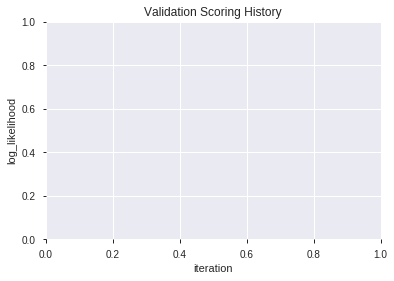

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_024114_model_3  0.769050  0.573371              0.264510  0.442061  0.195418
1  XGBoost_grid_1_AutoML_20190903_024114_model_1  0.767399  0.574725              0.268733  0.441861  0.195241
2               XGBoost_2_AutoML_20190903_024114  0.766891  0.578510              0.280925  0.444185  0.197301
3  XGBoost_grid_1_AutoML_20190903_024114_model_4  0.764605  0.581935              0.284195  0.445780  0.198720
4  XGBoost_grid_1_AutoML_20190903_024114_model_2  0.763081  0.583666              0.268637  0.446376  0.199252
5               XGBoost_1_AutoML_20190903_024114  0.762954  0.578809              0.346488  0.444576  0.197648
6  XGBoost_grid_1_AutoML_20190903_024114_model_6  0.761557  0.581345              0.292831  0.445433  0.198410
7               XGBoost_3_AutoML_20190903_024114  0.760859  0.584845              0.284957  0.446626  0.199475
8  XGBoost_grid_1_AutoML_20190903_024114_model_7  0.758001  0.588266              0.338233  0.449273  0.201847
9  XGBoost_grid_1_AutoML_20190903_024114_model_5  0.746126  0.592619              0.313468  0.451171  0.203555

variable  relative_importance  scaled_importance  percentage
0                  BOP          1433.014771           1.000000    0.195325
1         STOCHF_fastk           579.243713           0.404213    0.078953
2                  SUB           357.680511           0.249600    0.048753
3                CCI_8           339.188873           0.236696    0.046233
4                  DIV           308.461365           0.215253    0.042044
5                  SIN           285.030121           0.198902    0.038851
6                MFI_8           282.237915           0.196954    0.038470
7               TRANGE           257.060547           0.179384    0.035038
8               Volume           251.544235           0.175535    0.034286
9              WILLR_8           250.291962           0.174661    0.034116
10           dayofyear           230.080475           0.160557    0.031361
11              ULTOSC           225.047302           0.157045    0.030675
12      STOCHRSI_fastd           213.412659           0.148926    0.029089
13              BETA_8           211.886887           0.147861    0.028881
14                 OBV           173.608643           0.121149    0.023664
15                 COS           164.406281           0.114728    0.022409
16                 day           155.410385           0.108450    0.021183
17  CDLCLOSINGMARUBOZU           148.251251           0.103454    0.020207
18         HT_DCPERIOD           145.403885           0.101467    0.019819
19                week           143.791763           0.100342    0.019599
20             BETA_12           140.181198           0.097823    0.019107
21           aroonup_8           139.572906           0.097398    0.019024
22               ADOSC           128.672775           0.089792    0.017539
23          aroonup_14           117.925919           0.082292    0.016074
24          aroonup_20           100.381424           0.070049    0.013682
25        aroondown_30            95.274773           0.066486    0.012986
26      STOCHRSI_fastk            81.435852           0.056828    0.011100
27                TANH            65.503853           0.045711    0.008928
28           dayofweek            59.802212           0.041732    0.008151
29         aroondown_8            51.380535           0.035855    0.007003
30        weekday_name            50.601791           0.035311    0.006897
31          AROONOSC_8            38.810234           0.027083    0.005290
32         CDLLONGLINE            32.113377           0.022410    0.004377
33      CDLSPINNINGTOP            26.537224           0.018518    0.003617
34             weekday            14.632991           0.010211    0.001995
35   CDLLONGLEGGEDDOJI            12.596386           0.008790    0.001717
36       days_in_month            12.326703           0.008602    0.001680
37             quarter             4.958988           0.003461    0.000676
38      CDLRICKSHAWMAN             4.347961           0.003034    0.000593
39           CDLHAMMER             3.848647           0.002686    0.000525
40        HT_TRENDMODE             0.591343           0.000413    0.000081

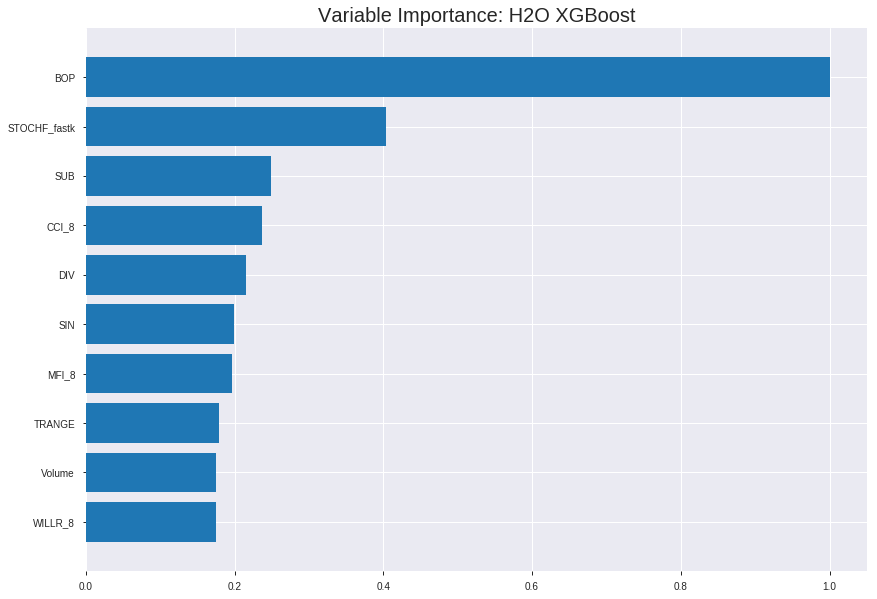

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_024114_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14543998385736023
RMSE: 0.38136594480545877
LogLoss: 0.4607514029677421
Mean Per-Class Error: 0.17984933717503937
AUC: 0.9019776945843706
pr_auc: 0.9134447384668558
Gini: 0.8039553891687412
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5364307463169098: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      653  162  0.1988   (162.0/815.0)
1      156  783  0.1661   (156.0/939.0)
Total  809  945  0.1813   (318.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.536431     0.83121   192
max f2                       0.355682     0.900236  275
max f0point5                 0.587106     0.845371  166
max accuracy                 0.550267     0.81984   184
max precision                0.917931     1         0
max recall                   0.176352     1         360
max specificity              0.917931     1         0
max absolute_mcc             0.550267     0.639125  184
max min_per_class_accuracy   0.548612     0.817891  185
max mean_per_class_accuracy  0.550267     0.820151  184

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 53.53 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.883942           1.86794    1.86794            1                0.898244  1                           0.898244            0.0191693       0.0191693                  86.7945   86.7945
    2        0.0205245                   0.872336           1.86794    1.86794            1                0.878809  1                           0.888526            0.0191693       0.0383387                  86.7945   86.7945
    3        0.0302166                   0.863114           1.86794    1.86794            1                0.867567  1                           0.881803            0.0181044       0.056443                   86.7945   86.7945
    4        0.0404789                   0.85509            1.86794    1.86794            1                0.859092  1                           0.876046            0.0191693       0.0756124                  86.7945   86.7945
    5        0.050171                    0.846912           1.86794    1.86794            1                0.851415  1                           0.871287            0.0181044       0.0937167                  86.7945   86.7945
    6        0.100342                    0.814587           1.86794    1.86794            1                0.830904  1                           0.851095            0.0937167       0.187433                   86.7945   86.7945
    7        0.149943                    0.77789            1.80353    1.84664            0.965517         0.796355  0.988593                    0.832988            0.0894569       0.27689                    80.3533   84.6637
    8        0.200114                    0.747121           1.74058    1.82005            0.931818         0.760888  0.974359                    0.814911            0.0873269       0.364217                   74.0585   82.0049
    9        0.299886                    0.689231           1.62244    1.75431            0.868571         0.720002  0.939163                    0.783335            0.161874        0.526092                   62.2443   75.4305
    10       0.400228                    0.632569           1.45403    1.67902            0.778409         0.659631  0.89886                     0.752321            0.1459          0.671991                   45.4025   67.9021
    11       0.5                         0.563582           1.21683    1.58679            0.651429         0.597785  0.849487                    0.721484            0.121406        0.793397                   21.6832   58.6794
    12       0.599772                    0.486961           0.843244   1.4631             0.451429         0.526277  0.78327                     0.689012            0.0841321       0.877529                   -15.6756  46.3105
    13       0.700114                    0.406724           0.753546   1.36141            0.403409         0.447881  0.728827                    0.654452            0.0756124       0.953142                   -24.6454  36.1409
    14       0.799886                    0.313124           0.277523   1.22621            0.148571         0.36053   0.65645                     0.61779             0.027689        0.980831                   -72.2477  22.6213
    15       0.899658                    0.20869            0.181457   1.11035            0.0971429        0.262256  0.594423                    0.578362            0.0181044       0.998935                   -81.8543  11.035
    16       1                           0.0506834          0.0106133  1                  0.00568182       0.148916  0.535348                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2029648800038948
RMSE: 0.4505162372255797
LogLoss: 0.5923404781883148
Mean Per-Class Error: 0.2967729634396301
AUC: 0.7474379141045807
pr_auc: 0.7239248395855554
Gini: 0.49487582820916143
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4176505506038666: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      125  118  0.4856   (118.0/243.0)
1      32   227  0.1236   (32.0/259.0)
Total  157  345  0.2988   (150.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.417651     0.751656  267
max f2                       0.187878     0.856096  364
max f0point5                 0.572206     0.713066  173
max accuracy                 0.503527     0.705179  218
max precision                0.920554     1         0
max recall                   0.140412     1         387
max specificity              0.920554     1         0
max absolute_mcc             0.417651     0.421313  267
max min_per_class_accuracy   0.544851     0.699588  196
max mean_per_class_accuracy  0.503527     0.703227  218

Gains/Lift Table: Avg response rate: 51.59 %, avg score: 52.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.892981           1.61519   1.61519            0.833333         0.902347  0.833333                    0.902347            0.019305        0.019305                   61.5187   61.5187
    2        0.0219124                   0.866844           1.93822   1.76202            1                0.87818   0.909091                    0.891362            0.019305        0.03861                    93.8224   76.2022
    3        0.0318725                   0.85103            1.16293   1.57481            0.6              0.855754  0.8125                      0.880234            0.011583        0.0501931                  16.2934   57.4807
    4        0.0418327                   0.845664           1.55058   1.56904            0.8              0.847147  0.809524                    0.872357            0.015444        0.0656371                  55.0579   56.9038
    5        0.0517928                   0.83927            1.55058   1.56549            0.8              0.841223  0.807692                    0.866369            0.015444        0.0810811                  55.0579   56.5489
    6        0.101594                    0.797151           1.55058   1.55818            0.8              0.816979  0.803922                    0.842158            0.0772201       0.158301                   55.0579   55.818
    7        0.151394                    0.758276           1.70564   1.60669            0.88             0.776647  0.828947                    0.820609            0.0849421       0.243243                   70.5637   60.6686
    8        0.201195                    0.72396            1.16293   1.49685            0.6              0.739804  0.772277                    0.800608            0.0579151       0.301158                   16.2934   49.6846
    9        0.300797                    0.65697            1.16293   1.38628            0.6              0.68725   0.715232                    0.763072            0.11583         0.416988                   16.2934   38.6279
    10       0.400398                    0.604358           1.35676   1.37894            0.7              0.632373  0.711443                    0.73056             0.135135        0.552124                   35.6757   37.8935
    11       0.5                         0.546576           1.43429   1.38996            0.74             0.575165  0.717131                    0.699605            0.142857        0.694981                   43.4286   38.9961
    12       0.599602                    0.484699           0.969112  1.32005            0.5              0.516911  0.681063                    0.669257            0.0965251       0.791506                   -3.0888   32.0053
    13       0.699203                    0.412161           0.891583  1.25902            0.46             0.444279  0.649573                    0.637209            0.0888031       0.880309                   -10.8417  25.9017
    14       0.798805                    0.312927           0.426409  1.1552             0.22             0.363294  0.59601                     0.603055            0.042471        0.92278                    -57.3591  15.5201
    15       0.898406                    0.212431           0.465174  1.0787             0.24             0.262662  0.556541                    0.565317            0.046332        0.969112                   -53.4826  7.87011
    16       1                           0.0816232          0.304035  1                  0.156863         0.159945  0.515936                    0.524134          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:41:22  2.246 sec   0                  0.5              0.693147            0.5             0                  1                0.464652                         0.5                0.693147              0.5               0                    1                  0.484064
    2019-09-03 02:41:22  2.417 sec   5                  0.476987         0.647942            0.816133        0.830797           1.86794          0.254846                         0.483904           0.661319              0.741686          0.716487             1.61519            0.320717
    2019-09-03 02:41:22  2.492 sec   10                 0.458573         0.612421            0.833272        0.84918            1.86794          0.253136                         0.472272           0.638402              0.745468          0.724177             1.93822            0.318725
    2019-09-03 02:41:22  2.568 sec   15                 0.444481         0.58509             0.838942        0.85615            1.86794          0.253136                         0.464602           0.622997              0.747875          0.733151             1.93822            0.310757
    2019-09-03 02:41:22  2.645 sec   20                 0.433529         0.563511            0.845963        0.864693           1.86794          0.256556                         0.459032           0.611449              0.748248          0.73189              1.93822            0.316733
    2019-09-03 02:41:22  2.721 sec   25                 0.424733         0.546106            0.853121        0.870547           1.86794          0.255416                         0.457123           0.607367              0.747565          0.732298             1.93822            0.324701
    2019-09-03 02:41:22  2.804 sec   30                 0.416307         0.529557            0.862523        0.880079           1.86794          0.238883                         0.455146           0.603119              0.746246          0.728305             1.93822            0.334661
    2019-09-03 02:41:22  2.891 sec   35                 0.409578         0.516011            0.869406        0.886825           1.86794          0.217788                         0.451918           0.596197              0.751013          0.738038             1.93822            0.284861
    2019-09-03 02:41:22  2.981 sec   40                 0.403546         0.503974            0.875442        0.891684           1.86794          0.224629                         0.451113           0.594311              0.751744          0.737046             1.93822            0.324701
    2019-09-03 02:41:23  3.070 sec   45                 0.39957          0.496132            0.879769        0.895115           1.86794          0.216078                         0.451493           0.594674              0.747827          0.730977             1.61519            0.316733
    2019-09-03 02:41:23  3.148 sec   50                 0.39565          0.48816             0.883836        0.898122           1.86794          0.211517                         0.449828           0.591279              0.751076          0.732569             1.61519            0.312749
    2019-09-03 02:41:23  3.239 sec   55                 0.389735         0.477384            0.893769        0.907011           1.86794          0.199544                         0.450205           0.591792              0.748264          0

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ---------------------
BOP             1433.0147705078125     1.0                    0.19532541133139256
STOCHF_fastk    579.2437133789062      0.4042133586478258     0.07895314054353028
SUB             357.6805114746094      0.2496000172753693     0.0487532260426342
CCI_8           339.1888732910156      0.2366960063997236     0.04623274481052393
DIV             308.46136474609375     0.21525344406379382    0.042044467502259424
---             ---                    ---                    ---
days_in_month   12.326703071594238     0.008601937206289972   0.0016801769230653984
quarter         4.958988189697266      0.0034605283153780514  0.0006759291166251488
CDLRICKSHAWMAN  4.347960948944092      0.0030341354732884712  0.00059264375935524
CDLHAMMER       3.848647117614746      0.0026856995453374945  0.0005245853684055801
HT_TRENDMODE    0.5913429260253906     0.000412656546321458   8.060230964883062e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7370517928286853)

('F1', 0.769230769230769)

('auc', 0.7690500381000762)

('logloss', 0.5733709799653963)

('mean_per_class_error', 0.2645097790195581)

('rmse', 0.44206144352394905)

('mse', 0.19541831985047758)

xgboost prediction progress: |████████████████████████████████████████████| 100%


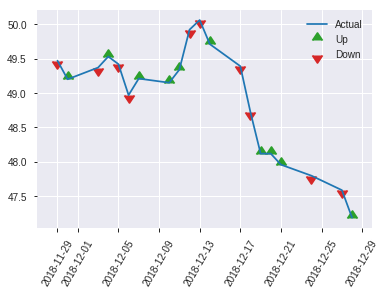


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19541831985047758
RMSE: 0.44206144352394905
LogLoss: 0.5733709799653963
Mean Per-Class Error: 0.2645097790195581
AUC: 0.7690500381000762
pr_auc: 0.7322940613396095
Gini: 0.5381000762001524
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4222472906112671: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      75   49   0.3952   (49.0/124.0)
1      17   110  0.1339   (17.0/127.0)
Total  92   159  0.2629   (66.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.422247     0.769231  158
max f2                       0.275845     0.869565  204
max f0point5                 0.422247     0.720839  158
max accuracy                 0.422247     0.737052  158
max precision                0.886603     1         0
max recall                   0.15859      1         236
max specificity              0.886603     1         0
max absolute_mcc             0.422247     0.488678  158
max min_per_class_accuracy   0.503637     0.693548  126
max mean_per_class_accuracy  0.422247     0.73549   158

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 49.54 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.862348           1.97638    1.97638            1                0.878411  1                           0.878411            0.023622        0.023622                   97.6378   97.6378
    2        0.0239044                   0.844482           1.97638    1.97638            1                0.849868  1                           0.86414             0.023622        0.0472441                  97.6378   97.6378
    3        0.0318725                   0.822238           1.97638    1.97638            1                0.831812  1                           0.856058            0.015748        0.0629921                  97.6378   97.6378
    4        0.0438247                   0.818782           1.31759    1.79671            0.666667         0.82055   0.909091                    0.846374            0.015748        0.0787402                  31.7585   79.6707
    5        0.0517928                   0.817091           0.988189   1.67232            0.5              0.817394  0.846154                    0.841915            0.00787402      0.0866142                  -1.1811   67.232
    6        0.103586                    0.756684           1.21623    1.44428            0.615385         0.78639   0.730769                    0.814153            0.0629921       0.149606                   21.6233   44.4276
    7        0.151394                    0.726423           1.64698    1.50829            0.833333         0.741156  0.763158                    0.791101            0.0787402       0.228346                   64.6982   50.8288
    8        0.203187                    0.703514           1.82435    1.58885            0.923077         0.716119  0.803922                    0.771988            0.0944882       0.322835                   82.4349   58.8853
    9        0.302789                    0.629802           1.26488    1.48228            0.64             0.66513   0.75                        0.736837            0.125984        0.448819                   26.4882   48.2283
    10       0.40239                     0.556165           1.10677    1.38933            0.56             0.600282  0.70297                     0.703037            0.110236        0.559055                   10.6772   38.9335
    11       0.501992                    0.507005           1.34394    1.38033            0.68             0.531551  0.698413                    0.669012            0.133858        0.692913                   34.3937   38.0327
    12       0.601594                    0.440514           1.26488    1.36121            0.64             0.472892  0.688742                    0.636542            0.125984        0.818898                   26.4882   36.1214
    13       0.701195                    0.379622           0.790551   1.28015            0.4              0.41072   0.647727                    0.604465            0.0787402       0.897638                   -20.9449  28.0154
    14       0.800797                    0.287401           0.553386   1.18976            0.28             0.333596  0.60199                     0.570774            0.0551181       0.952756                   -44.6614  18.976
    15       0.900398                    0.194286           0.395276   1.10187            0.2              0.239086  0.557522                    0.534083            0.0393701       0.992126                   -60.4724  10.1874
    16       1                           0.0879307          0.0790551  1                  0.04             0.145363  0.505976                    0

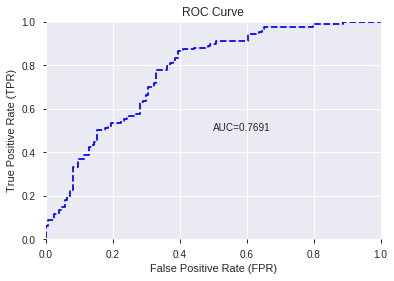

This function is available for GLM models only


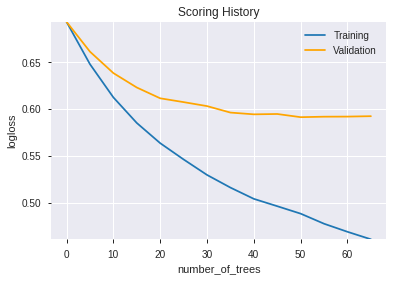

--2019-09-03 02:41:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_024114_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_024114_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_83a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'SUB',
 'CCI_8',
 'DIV',
 'SIN',
 'MFI_8',
 'TRANGE',
 'Volume',
 'WILLR_8',
 'dayofyear',
 'ULTOSC',
 'STOCHRSI_fastd',
 'BETA_8',
 'OBV',
 'COS',
 'day',
 'CDLCLOSINGMARUBOZU',
 'HT_DCPERIOD',
 'week',
 'BETA_12',
 'aroonup_8',
 'ADOSC',
 'aroonup_14',
 'aroonup_20',
 'aroondown_30',
 'STOCHRSI_fastk',
 'TANH',
 'dayofweek',
 'aroondown_8',
 'weekday_name',
 'AROONOSC_8',
 'CDLLONGLINE',
 'CDLSPINNINGTOP',
 'weekday',
 'CDLLONGLEGGEDDOJI',
 'days_in_month',
 'quarter',
 'CDLRICKSHAWMAN',
 'CDLHAMMER',
 'HT_TRENDMODE']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [892] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


26

['Volume',
 'BOP',
 'CCI_8',
 'CMO_8',
 'RSI_8',
 'WILLR_8',
 'WILLR_12',
 'WILLR_14',
 'WILLR_20',
 'WILLR_24',
 'STOCH_slowk',
 'STOCHF_fastk',
 'STOCHF_fastd',
 'STOCHRSI_fastk',
 'ULTOSC',
 'ADOSC',
 'TRANGE',
 'CDLBELTHOLD',
 'CDLCLOSINGMARUBOZU',
 'CDLENGULFING',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'CDLSPINNINGTOP',
 'DIV',
 'SUB']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_024143_model_9  0.784227  0.557182              0.289180  0.434542  0.188827
1  DeepLearning_grid_1_AutoML_20190903_024143_model_1  0.778194  0.640079              0.292926  0.458420  0.210149
2  DeepLearning_grid_1_AutoML_20190903_024143_model_3  0.778004  0.649510              0.309436  0.467804  0.218841
3  DeepLearning_grid_1_AutoML_20190903_024143_model_6  0.776797  0.569914              0.289180  0.443372  0.196579
4  DeepLearning_grid_1_AutoML_20190903_024143_model_5  0.776162  0.562968              0.289180  0.437419  0.191335
5  DeepLearning_grid_1_AutoML_20190903_024143_model_8  0.774448  0.563895              0.305785  0.438438  0.192228
6  DeepLearning_grid_1_AutoML_20190903_024143_model_2  0.774257  0.583306              0.297149  0.443113  0.196349
7  DeepLearning_grid_1_AutoML_20190903_024143_model_7  0.762764  0.608908              0.276226  0.456213  0.208131
8  DeepLearning_grid_1_AutoML_20190903_024143_model_4  0.747523  0.629642              0.284004  0.461880  0.213333
9               DeepLearning_1_AutoML_20190903_024143  0.719964  0.653903              0.394685  0.474765  0.225402

variable  relative_importance  scaled_importance  percentage
0   CDLCLOSINGMARUBOZU             1.000000           1.000000    0.093461
1                  BOP             0.637964           0.637964    0.059625
2          CDLLONGLINE             0.591318           0.591318    0.055265
3                CCI_8             0.551892           0.551892    0.051580
4                  SUB             0.510366           0.510366    0.047699
5          CDLMARUBOZU             0.482535           0.482535    0.045098
6         STOCHF_fastk             0.481183           0.481183    0.044972
7         CDLSHORTLINE             0.473693           0.473693    0.044272
8               TRANGE             0.446089           0.446089    0.041692
9                  DIV             0.424055           0.424055    0.039632
10      CDLSPINNINGTOP             0.409398           0.409398    0.038263
11               RSI_8             0.369813           0.369813    0.034563
12              ULTOSC             0.358152           0.358152    0.033473
13               CMO_8             0.358023           0.358023    0.033461
14             WILLR_8             0.335859           0.335859    0.031390
15         CDLBELTHOLD             0.328025           0.328025    0.030657
16        CDLENGULFING             0.325881           0.325881    0.030457
17               ADOSC             0.311033           0.311033    0.029069
18              Volume             0.302116           0.302116    0.028236
19      STOCHRSI_fastk             0.300328           0.300328    0.028069
20        STOCHF_fastd             0.298122           0.298122    0.027863
21         STOCH_slowk             0.289218           0.289218    0.027030
22            WILLR_12             0.288264           0.288264    0.026941
23            WILLR_20             0.287157           0.287157    0.026838
24            WILLR_24             0.275652           0.275652    0.025763
25            WILLR_14             0.263554           0.263554    0.024632

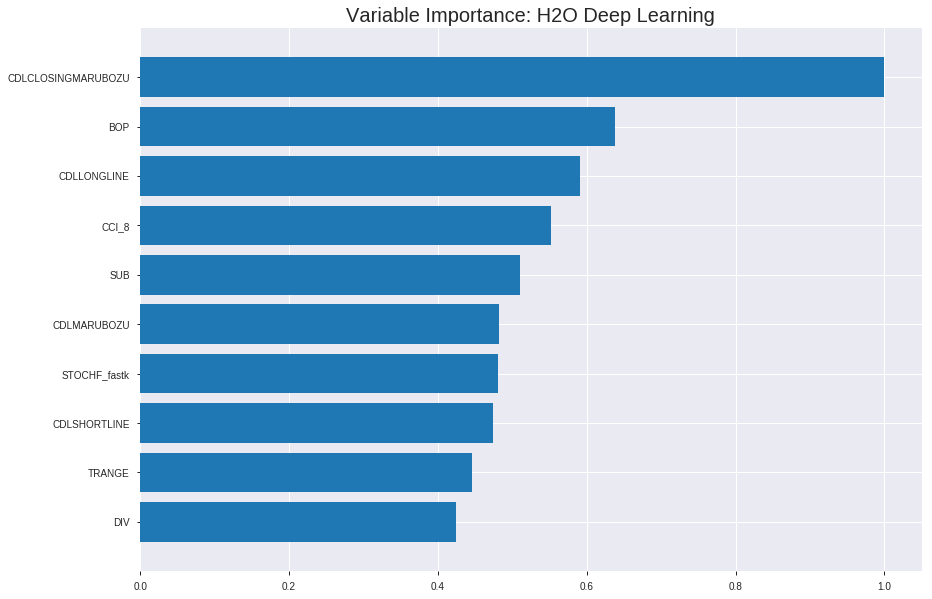

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_024143_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20130504181860148
RMSE: 0.44867030414169545
LogLoss: 0.5883427786004676
Mean Per-Class Error: 0.30797938023089433
AUC: 0.7510038743735994
pr_auc: 0.7556859668698198
Gini: 0.5020077487471988
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3191322975075165: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      280  535   0.6564   (535.0/815.0)
1      65   874   0.0692   (65.0/939.0)
Total  345  1409  0.3421   (600.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.319132     0.744463  304
max f2                       0.238141     0.860286  342
max f0point5                 0.566067     0.717587  183
max accuracy                 0.496893     0.693843  226
max precision                0.945021     1         0
max recall                   0.133266     1         390
max specificity              0.945021     1         0
max absolute_mcc             0.496893     0.384352  226
max min_per_class_accuracy   0.54478      0.68589   194
max mean_per_class_accuracy  0.566067     0.692021  183

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 54.67 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.929524           1.86794   1.86794            1                0.934665  1                           0.934665            0.0191693       0.0191693                  86.7945   86.7945
    2        0.0205245                   0.923423           1.45285   1.6604             0.777778         0.926234  0.888889                    0.93045             0.0149095       0.0340788                  45.2846   66.0395
    3        0.0302166                   0.872382           1.53831   1.62123            0.823529         0.899279  0.867925                    0.920452            0.0149095       0.0489883                  53.8307   62.1235
    4        0.0404789                   0.861409           1.76417   1.65747            0.944444         0.866505  0.887324                    0.906775            0.0181044       0.0670927                  76.417    65.7472
    5        0.050171                    0.84468            1.53831   1.63445            0.823529         0.855073  0.875                       0.896787            0.0149095       0.0820021                  53.8307   63.4452
    6        0.100342                    0.792902           1.50709   1.57077            0.806818         0.81337   0.840909                    0.855079            0.0756124       0.157614                   50.7092   57.0772
    7        0.149943                    0.76964            1.46      1.53413            0.781609         0.781182  0.821293                    0.830634            0.0724175       0.230032                   46.0003   53.4129
    8        0.200114                    0.733365           1.37973   1.49542            0.738636         0.753199  0.80057                     0.81122             0.0692226       0.299255                   37.9732   49.542
    9        0.299886                    0.693324           1.39829   1.4631             0.748571         0.71206   0.78327                     0.778229            0.13951         0.438765                   39.829    46.3105
    10       0.400228                    0.64428            1.23115   1.40495            0.659091         0.672406  0.752137                    0.751698            0.123536        0.5623                     23.1145   40.495
    11       0.5                         0.551579           1.11009   1.34611            0.594286         0.595676  0.720639                    0.720565            0.110756        0.673056                   11.0093   34.6113
    12       0.599772                    0.520433           0.917961  1.27489            0.491429         0.534686  0.68251                     0.689644            0.0915868       0.764643                   -8.20386  27.489
    13       0.700114                    0.450329           0.880906  1.21842            0.471591         0.489649  0.65228                     0.66098             0.0883919       0.853035                   -11.9094  21.8423
    14       0.799886                    0.322044           0.72583   1.15698            0.388571         0.384853  0.619387                    0.626538            0.0724175       0.925453                   -27.417   15.6981
    15       0.899658                    0.229032           0.501677  1.08431            0.268571         0.273552  0.580482                    0.587392            0.0500532       0.975506                   -49.8323  8.43075
    16       1                           0.0992847          0.244106  1                  0.130682         0.181417  0.535348                    0.546656            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.20738169276639012
RMSE: 0.45539180138249097
LogLoss: 0.6017703320403183
Mean Per-Class Error: 0.3154424265535376
AUC: 0.736800292355848
pr_auc: 0.7272593280573455
Gini: 0.47360058471169597
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4123222797879094: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      119  124  0.5103   (124.0/243.0)
1      39   220  0.1506   (39.0/259.0)
Total  158  344  0.3247   (163.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.412322     0.729685  269
max f2                       0.221935     0.851279  352
max f0point5                 0.550487     0.695029  185
max accuracy                 0.524709     0.685259  207
max precision                0.936447     1         0
max recall                   0.146345     1         390
max specificity              0.936447     1         0
max absolute_mcc             0.524709     0.369503  207
max min_per_class_accuracy   0.532103     0.671815  199
max mean_per_class_accuracy  0.524709     0.684558  207

Gains/Lift Table: Avg response rate: 51.59 %, avg score: 52.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.920162           1.61519   1.61519            0.833333         0.929703  0.833333                    0.929703            0.019305        0.019305                   61.5187   61.5187
    2        0.0219124                   0.89858            1.55058   1.58582            0.8              0.909835  0.818182                    0.920672            0.015444        0.034749                   55.0579   58.582
    3        0.0318725                   0.866121           1.93822   1.69595            1                0.871182  0.875                       0.905206            0.019305        0.0540541                  93.8224   69.5946
    4        0.0418327                   0.85195            1.93822   1.75363            1                0.856774  0.904762                    0.893675            0.019305        0.0733591                  93.8224   75.3631
    5        0.0517928                   0.836073           1.93822   1.78913            1                0.84369   0.923077                    0.884062            0.019305        0.0926641                  93.8224   78.913
    6        0.101594                    0.784441           1.39552   1.59618            0.72             0.802561  0.823529                    0.844111            0.0694981       0.162162                   39.5521   59.6184
    7        0.151394                    0.766287           1.78317   1.65769            0.92             0.774964  0.855263                    0.821365            0.0888031       0.250965                   78.3166   65.7692
    8        0.201195                    0.72705            1.24046   1.55442            0.64             0.748607  0.80198                     0.803356            0.0617761       0.312741                   24.0463   55.4417
    9        0.300797                    0.686604           1.08541   1.39912            0.56             0.703775  0.721854                    0.770382            0.108108        0.420849                   8.54054   39.9115
    10       0.400398                    0.630901           1.27923   1.36929            0.66             0.665238  0.706468                    0.744227            0.127413        0.548263                   27.9228   36.9293
    11       0.5                         0.533689           1.2017    1.33591            0.62             0.570721  0.689243                    0.709664            0.119691        0.667954                   20.1699   33.5907
    12       0.599602                    0.483979           0.969112  1.27498            0.5              0.512595  0.657807                    0.676928            0.0965251       0.764479                   -3.0888   27.4978
    13       0.699203                    0.401268           0.930347  1.22589            0.48             0.447406  0.632479                    0.644233            0.0926641       0.857143                   -6.96525  22.5885
    14       0.798805                    0.285941           0.620232  1.15037            0.32             0.344052  0.593516                    0.606804            0.0617761       0.918919                   -37.9768  15.0367
    15       0.898406                    0.216294           0.581467  1.0873             0.3              0.255179  0.560976                    0.567821            0.0579151       0.976834                   -41.8533  8.72964
    16       1                           0.0717308          0.228026  1                  0.117647         0.171849  0.515936                    0.527593           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:47:05  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 02:47:07  1 min 53.528 sec  617 obs/sec       0.767959  1             1347       0.476109         0.684647            0.0887261      0.730763        0.735714           1.76417          0.339225                         0.469749           0.660736              0.116447         0.742433          0.736849             1.61519            0.322709
    2019-09-03 02:47:15  2 min  1.841 sec  967 obs/sec       5.33352   7             9355       0.456138         0.602555            0.163571       0.740229        0.748423           1.6604           0.341505                         0.457506           0.604797              0.1619           0.738             0.729236             1.61519            0.310757
    2019-09-03 02:47:23  2 min 10.051 sec  1170 obs/sec      11.4076   15            20009      0.454052         0.599823            0.171205       0.744069        0.749135           1.6604           0.328392                         0.457522           0.606536              0.161844         0.734814          0.729879             1.29215            0.358566
    2019-09-03 02:47:31  2 min 17.975 sec  1314 obs/sec      18.1534   24            31841      0.452494         0.596375            0.176882       0.746158        0.753172           1.86794          0.338655                         0.456628           0.604748              0.165116         0.73545           0.725394             1.61519            0.334661
    2019-09-03 02:47:39  2 min 25.953 sec  1434 obs/sec      25.7041   34            45085      0.456273         0.606803            0.163078       0.749191        0.754972           1.86794          0.3187                           0.462995           0.620189              0.141671         0.733487          0.726684             1.61519            0.340637
    2019-09-03 02:47:48  2 min 34.179 sec  1533 obs/sec      33.9949   45            59627      0.44867          0.588343            0.190735       0.751004        0.755686           1.86794          0.342075                         0.455392           0.60177               0.16963          0.7368            0.727259             1.61519            0.324701
    2019-09-03 02:47:56  2 min 42.180 sec  1610 obs/sec      42.2999   56            74194      0.450359         0.597819            0.184631       0.755343        0.758045           1.86794          0.324971                         0.462114           0.621717              0.144934         0.731374          0.725082             1.61519            0.348606
    2019-09-03 02:47:56  2 min 43.000 sec  1609 obs/sec      42.2999   56            74194      0.44867          0.588343            0.190735       0.751004        0.755686           1.86794          0.342075                         0.455392           0.60177               0.16963          0.7368            0.727259             1.61519            0.324701

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLCLOSINGMARUBOZU  1.0                    1.0                  0.09346063383860484
BOP                 0.6379639506340027     0.6379639506340027   0.0596245151924343
CDLLONGLINE         0.5913183093070984     0.5913183093070984   0.055264983988213605
CCI_8               0.5518924593925476     0.5518924593925476   0.05158021906557399
SUB                 0.5103663802146912     0.5103663802146912   0.04769916538477943
---                 ---                    ---                  ---
STOCH_slowk         0.2892177700996399     0.2892177700996399   0.02703047611090024
WILLR_12            0.28826388716697693    0.28826388716697693  0.026941325607405732
WILLR_20            0.2871568500995636     0.2871568500995636   0.026837861221402453
WILLR_24            0.2756524085998535     0.2756524085998535   0.0257626488268804
WILLR_14            0.263553649187088      0.263553649187088    0.024631891103502546


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7250996015936255)

('F1', 0.7615894039735098)

('auc', 0.7842265684531369)

('logloss', 0.5571820727611413)

('mean_per_class_error', 0.2750825501651003)

('rmse', 0.43454201865520714)

('mse', 0.1888267659769424)

deeplearning prediction progress: |███████████████████████████████████████| 100%


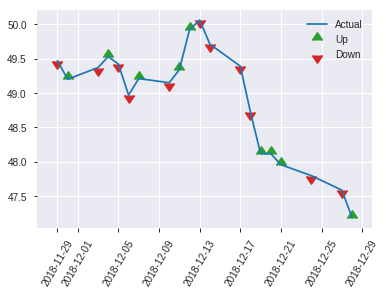


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.1888267659769424
RMSE: 0.43454201865520714
LogLoss: 0.5571820727611413
Mean Per-Class Error: 0.2750825501651003
AUC: 0.7842265684531369
pr_auc: 0.7588403479733046
Gini: 0.5684531369062737
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37253704955622274: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      64   60   0.4839   (60.0/124.0)
1      12   115  0.0945   (12.0/127.0)
Total  76   175  0.2869   (72.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.372537     0.761589  174
max f2                       0.235832     0.874656  217
max f0point5                 0.510566     0.72643   129
max accuracy                 0.510566     0.7251    129
max precision                0.933019     1         0
max recall                   0.235832     1         217
max specificity              0.933019     1         0
max absolute_mcc             0.372537     0.458806  174
max min_per_class_accuracy   0.518847     0.709677  126
max mean_per_class_accuracy  0.510566     0.724917  129

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 50.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.918356           1.97638   1.97638            1                0.927788  1                           0.927788            0.023622        0.023622                   97.6378   97.6378
    2        0.0239044                   0.8638             1.97638   1.97638            1                0.882446  1                           0.905117            0.023622        0.0472441                  97.6378   97.6378
    3        0.0318725                   0.838375           1.97638   1.97638            1                0.846595  1                           0.890486            0.015748        0.0629921                  97.6378   97.6378
    4        0.0438247                   0.812074           1.31759   1.79671            0.666667         0.824705  0.909091                    0.872546            0.015748        0.0787402                  31.7585   79.6707
    5        0.0517928                   0.802047           1.97638   1.82435            1                0.809912  0.923077                    0.86291             0.015748        0.0944882                  97.6378   82.4349
    6        0.103586                    0.772748           1.36826   1.59631            0.692308         0.783159  0.807692                    0.823035            0.0708661       0.165354                   36.8262   59.6305
    7        0.151394                    0.737768           1.64698   1.61231            0.833333         0.755688  0.815789                    0.801767            0.0787402       0.244094                   64.6982   61.2308
    8        0.203187                    0.71145            1.67232   1.62761            0.846154         0.724083  0.823529                    0.781965            0.0866142       0.330709                   67.232    62.7605
    9        0.302789                    0.652429           1.26488   1.50829            0.64             0.678052  0.763158                    0.747783            0.125984        0.456693                   26.4882   50.8288
    10       0.40239                     0.574345           1.26488   1.44804            0.64             0.611085  0.732673                    0.713947            0.125984        0.582677                   26.4882   44.8039
    11       0.501992                    0.524071           1.26488   1.4117             0.64             0.545338  0.714286                    0.680493            0.125984        0.708661                   26.4882   41.1699
    12       0.601594                    0.4555             1.02772   1.34813            0.52             0.488304  0.682119                    0.648673            0.102362        0.811024                   2.77165   34.8125
    13       0.701195                    0.351474           0.948661  1.29138            0.48             0.40883   0.653409                    0.614605            0.0944882       0.905512                   -5.13386  29.1383
    14       0.800797                    0.266254           0.553386  1.19959            0.28             0.304035  0.606965                    0.575977            0.0551181       0.96063                    -44.6614  19.9593
    15       0.900398                    0.202354           0.395276  1.11062            0.2              0.240297  0.561947                    0.538844            0.0393701       1                          -60.4724  11.0619
    16       1                           0.0951312          0         1                  0                0.159713  0.505976                    0.501082         

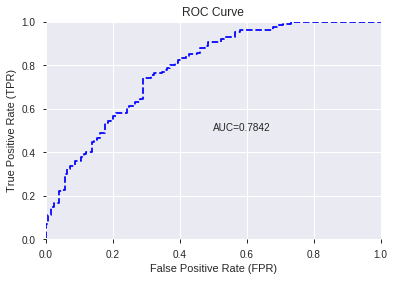

This function is available for GLM models only


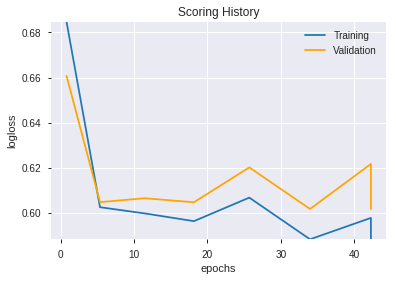

--2019-09-03 02:48:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.146.59
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.146.59|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_024143_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_024143_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_83a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLCLOSINGMARUBOZU',
 'BOP',
 'CDLLONGLINE',
 'CCI_8',
 'SUB',
 'CDLMARUBOZU',
 'STOCHF_fastk',
 'CDLSHORTLINE',
 'TRANGE',
 'DIV',
 'CDLSPINNINGTOP',
 'RSI_8',
 'ULTOSC',
 'CMO_8',
 'WILLR_8',
 'CDLBELTHOLD',
 'CDLENGULFING',
 'ADOSC',
 'Volume',
 'STOCHRSI_fastk',
 'STOCHF_fastd',
 'STOCH_slowk',
 'WILLR_12',
 'WILLR_20',
 'WILLR_24',
 'WILLR_14']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_024809_model_1  0.762764  0.577287              0.342266  0.444551  0.197626

variable  relative_importance  scaled_importance  percentage
0                  BOP             0.452832           1.000000    0.121516
1                CCI_8             0.443415           0.979204    0.118989
2         STOCHF_fastk             0.410088           0.905607    0.110046
3   CDLCLOSINGMARUBOZU             0.282713           0.624321    0.075865
4              WILLR_8             0.255194           0.563552    0.068481
5                CMO_8             0.246212           0.543715    0.066070
6                RSI_8             0.244967           0.540966    0.065736
7               ULTOSC             0.210189           0.464165    0.056404
8             WILLR_20             0.186460           0.411765    0.050036
9                  SUB             0.146965           0.324546    0.039438
10                 DIV             0.121119           0.267471    0.032502
11              TRANGE             0.112982           0.249500    0.030318
12      CDLSPINNINGTOP             0.110823           0.244732    0.029739
13            WILLR_12             0.077180           0.170437    0.020711
14        STOCHF_fastd             0.076258           0.168401    0.020463
15         STOCH_slowk             0.076010           0.167856    0.020397
16         CDLLONGLINE             0.075787           0.167362    0.020337
17         CDLMARUBOZU             0.053872           0.118968    0.014457
18        CDLSHORTLINE             0.041088           0.090735    0.011026
19      STOCHRSI_fastk             0.040230           0.088840    0.010796
20         CDLBELTHOLD             0.033483           0.073942    0.008985
21            WILLR_14             0.009302           0.020543    0.002496
22            WILLR_24             0.008699           0.019210    0.002334
23               ADOSC             0.006559           0.014485    0.001760
24        CDLENGULFING             0.003062           0.006761    0.000822
25              Volume             0.001031           0.002276    0.000277

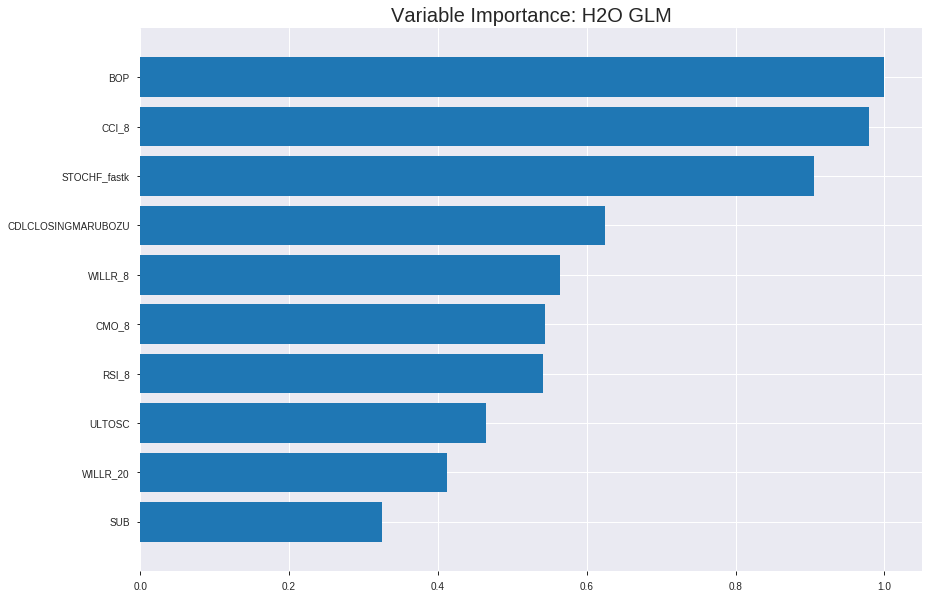

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_024809_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.20035580208536755
RMSE: 0.44761121755980104
LogLoss: 0.584990961864939
Null degrees of freedom: 1753
Residual degrees of freedom: 1727
Null deviance: 2422.786744110176
Residual deviance: 2052.148294222206
AIC: 2106.148294222206
AUC: 0.7537858444893079
pr_auc: 0.7604978056288828
Gini: 0.5075716889786157
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37019152396928534: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      304  511   0.627    (511.0/815.0)
1      78   861   0.0831   (78.0/939.0)
Total  382  1372  0.3358   (589.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.370192     0.745132  282
max f2                       0.223149     0.863645  344
max f0point5                 0.56836      0.718479  174
max accuracy                 0.511263     0.690992  202
max precision                0.901756     0.96      11
max recall                   0.0795787    1         389
max specificity              0.942238     0.998773  0
max absolute_mcc             0.56836      0.383863  174
max min_per_class_accuracy   0.539414     0.68589   188
max mean_per_class_accuracy  0.56836      0.692136  174

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 53.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.910908           1.76417   1.76417            0.944444         0.92015   0.944444                    0.92015             0.0181044       0.0181044                  76.417    76.417
    2        0.0205245                   0.892244           1.6604    1.71228            0.888889         0.899175  0.916667                    0.909662            0.0170394       0.0351438                  66.0395   71.2283
    3        0.0302166                   0.879774           1.53831   1.65648            0.823529         0.884253  0.886792                    0.901512            0.0149095       0.0500532                  53.8307   65.6479
    4        0.0404789                   0.869658           1.76417   1.68378            0.944444         0.875262  0.901408                    0.894857            0.0181044       0.0681576                  76.417    68.3781
    5        0.050171                    0.85619            1.53831   1.65568            0.823529         0.864147  0.886364                    0.888924            0.0149095       0.0830671                  53.8307   65.5678
    6        0.100342                    0.790975           1.52832   1.592              0.818182         0.821513  0.852273                    0.855219            0.0766773       0.159744                   52.8318   59.1998
    7        0.149943                    0.756057           1.37412   1.51992            0.735632         0.772987  0.813688                    0.828017            0.0681576       0.227902                   37.412    51.9925
    8        0.200114                    0.726523           1.54954   1.52735            0.829545         0.740982  0.817664                    0.806196            0.0777423       0.305644                   54.9545   52.7351
    9        0.299886                    0.669901           1.43031   1.49507            0.765714         0.697773  0.80038                     0.770124            0.142705        0.448349                   43.0312   49.5066
    10       0.400228                    0.612079           1.18869   1.41825            0.636364         0.640293  0.759259                    0.737573            0.119276        0.567625                   18.8692   41.8254
    11       0.5                         0.547043           1.05672   1.34611            0.565714         0.582231  0.720639                    0.706576            0.105431        0.673056                   5.6723    34.6113
    12       0.599772                    0.483306           0.875265  1.26779            0.468571         0.515689  0.678707                    0.674822            0.0873269       0.760383                   -12.4735  26.7788
    13       0.700114                    0.423976           0.870292  1.21082            0.465909         0.451738  0.648208                    0.642849            0.0873269       0.84771                    -12.9708  21.0818
    14       0.799886                    0.356411           0.789874  1.15831            0.422857         0.388826  0.6201                      0.611164            0.0788072       0.926518                   -21.0126  15.8312
    15       0.899658                    0.251809           0.523024  1.08786            0.28             0.303616  0.582383                    0.577057            0.0521832       0.978701                   -47.6976  8.78588
    16       1                           0.0143054          0.212266  1                  0.113636         0.161389  0.535348                    0.535348          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2029127003571
RMSE: 0.45045832255281953
LogLoss: 0.5901389787626948
Null degrees of freedom: 501
Residual degrees of freedom: 475
Null deviance: 696.1689483589155
Residual deviance: 592.4995346777457
AIC: 646.4995346777457
AUC: 0.7479304701526924
pr_auc: 0.7493557464688124
Gini: 0.49586094030538486
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3909076475199111: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      119  124  0.5103   (124.0/243.0)
1      34   225  0.1313   (34.0/259.0)
Total  153  349  0.3147   (158.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.390908     0.740132  271
max f2                       0.148777     0.852611  376
max f0point5                 0.512545     0.707584  199
max accuracy                 0.512545     0.697211  199
max precision                0.933495     1         0
max recall                   0.080891     1         392
max specificity              0.933495     1         0
max absolute_mcc             0.478232     0.394584  223
max min_per_class_accuracy   0.512545     0.695473  199
max mean_per_class_accuracy  0.512545     0.697157  199

Gains/Lift Table: Avg response rate: 51.59 %, avg score: 50.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.893173           1.93822   1.93822            1                0.91395   1                           0.91395             0.023166        0.023166                   93.8224   93.8224
    2        0.0219124                   0.869927           1.55058   1.76202            0.8              0.880975  0.909091                    0.898961            0.015444        0.03861                    55.0579   76.2022
    3        0.0318725                   0.854929           1.93822   1.81708            1                0.862521  0.9375                      0.887574            0.019305        0.0579151                  93.8224   81.7085
    4        0.0418327                   0.840348           1.93822   1.84593            1                0.847226  0.952381                    0.877967            0.019305        0.0772201                  93.8224   84.5928
    5        0.0517928                   0.824476           1.55058   1.78913            0.8              0.833498  0.923077                    0.869415            0.015444        0.0926641                  55.0579   78.913
    6        0.101594                    0.766658           1.62811   1.7102             0.84             0.788985  0.882353                    0.829989            0.0810811       0.173745                   62.8108   71.0198
    7        0.151394                    0.720819           1.39552   1.60669            0.72             0.740666  0.828947                    0.800606            0.0694981       0.243243                   39.5521   60.6686
    8        0.201195                    0.702782           1.39552   1.55442            0.72             0.713099  0.80198                     0.778946            0.0694981       0.312741                   39.5521   55.4417
    9        0.300797                    0.654218           1.27923   1.46329            0.66             0.679253  0.754967                    0.745935            0.127413        0.440154                   27.9228   46.3295
    10       0.400398                    0.600601           1.12417   1.37894            0.58             0.627321  0.711443                    0.716429            0.111969        0.552124                   12.417    37.8935
    11       0.5                         0.514879           1.31799   1.3668             0.68             0.558566  0.705179                    0.684982            0.131274        0.683398                   31.7992   36.6795
    12       0.599602                    0.461676           0.969112  1.30074            0.5              0.491806  0.671096                    0.652893            0.0965251       0.779923                   -3.0888   30.0735
    13       0.699203                    0.385266           0.891583  1.24245            0.46             0.423063  0.641026                    0.620154            0.0888031       0.868726                   -10.8417  24.2451
    14       0.798805                    0.306282           0.387645  1.13587            0.2              0.350905  0.586035                    0.586582            0.03861         0.907336                   -61.2355  13.5867
    15       0.898406                    0.220808           0.620232  1.0787             0.32             0.266297  0.556541                    0.551073            0.0617761       0.969112                   -37.9768  7.87011
    16       1                           0.00160587         0.304035  1                  0.156863         0.140247  0.515936                    0.509336          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-09-03 02:48:09  0.000 sec   2            .18E2     27            1.364199775936176   1.369191745654856
     2019-09-03 02:48:09  0.006 sec   4            .11E2     27            1.355900758393957   1.3606227368146657
     2019-09-03 02:48:09  0.012 sec   6            .69E1     27            1.3447897822669856  1.3491278412663528
     2019-09-03 02:48:09  0.018 sec   8            .43E1     27            1.3308177207800047  1.3346427598815493
     2019-09-03 02:48:09  0.026 sec   10           .27E1     27            1.3142227881607613  1.3174296495340043
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-09-03 02:48:09  0.100 sec   34           .88E-2    27            1.1674694497660283  1.1803336321387983
     2019-09-03 02:48:09  0.108 sec   36           .54E-2    27            1.1658999517181443  1.181230486128582
     2019-09-03 02:48:09  0.114 sec   38           .34E-2    27            1.164964367219284   1.1824326635572335
     2019-09-03 02:48:09  0.125 sec   40           .21E-2    27            1.1644280980599095  1.1836420407577566
     2019-09-03 02:48:09  0.129 sec   41           .13E-2    27            1.1641409387355373  1.1846132072709163


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.701195219123506)

('F1', 0.7416413373860182)

('auc', 0.7627635255270511)

('logloss', 0.5772870161708163)

('mean_per_class_error', 0.2984188468376936)

('rmse', 0.444551279887992)

('mse', 0.19762584045005177)

glm prediction progress: |████████████████████████████████████████████████| 100%


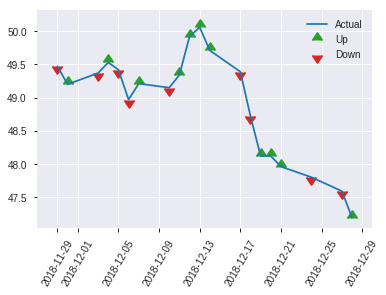


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19762584045005177
RMSE: 0.444551279887992
LogLoss: 0.5772870161708163
Null degrees of freedom: 250
Residual degrees of freedom: 224
Null deviance: 348.7926110092956
Residual deviance: 289.7980821177498
AIC: 343.7980821177498
AUC: 0.7627635255270511
pr_auc: 0.7336082742738363
Gini: 0.5255270510541021
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2973204108420719: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      44   80   0.6452   (80.0/124.0)
1      5    122  0.0394   (5.0/127.0)
Total  49   202  0.3386   (85.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.29732      0.741641  201
max f2                       0.220069     0.863946  226
max f0point5                 0.5237       0.709516  117
max accuracy                 0.5237       0.701195  117
max precision                0.909714     1         0
max recall                   0.220069     1         226
max specificity              0.909714     1         0
max absolute_mcc             0.5237       0.403855  117
max min_per_class_accuracy   0.50548      0.692913  125
max mean_per_class_accuracy  0.5237       0.701581  117

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 49.01 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.878974           1.31759    1.31759            0.666667         0.897079  0.666667                    0.897079            0.015748        0.015748                   31.7585   31.7585
    2        0.0239044                   0.862838           1.97638    1.64698            1                0.8672    0.833333                    0.88214             0.023622        0.0393701                  97.6378   64.6982
    3        0.0318725                   0.840814           1.97638    1.72933            1                0.842404  0.875                       0.872206            0.015748        0.0551181                  97.6378   72.9331
    4        0.0438247                   0.815503           1.97638    1.79671            1                0.83151   0.909091                    0.861107            0.023622        0.0787402                  97.6378   79.6707
    5        0.0517928                   0.792295           1.97638    1.82435            1                0.799017  0.923077                    0.851555            0.015748        0.0944882                  97.6378   82.4349
    6        0.103586                    0.731063           1.67232    1.74833            0.846154         0.754043  0.884615                    0.802799            0.0866142       0.181102                   67.232    74.8334
    7        0.151394                    0.695974           0.988189   1.50829            0.5              0.714799  0.763158                    0.775009            0.0472441       0.228346                   -1.1811   50.8288
    8        0.203187                    0.673154           1.52029    1.51135            0.769231         0.685538  0.764706                    0.752203            0.0787402       0.307087                   52.0291   51.1348
    9        0.302789                    0.624459           1.50205    1.50829            0.76             0.651065  0.763158                    0.718934            0.149606        0.456693                   50.2047   50.8288
    10       0.40239                     0.56775            1.18583    1.42847            0.6              0.59355   0.722772                    0.687898            0.11811         0.574803                   18.5827   42.8471
    11       0.501992                    0.50548            1.18583    1.38033            0.6              0.534715  0.698413                    0.657505            0.11811         0.692913                   18.5827   38.0327
    12       0.601594                    0.433301           0.948661   1.30886            0.48             0.465782  0.662252                    0.625763            0.0944882       0.787402                   -5.13386  30.886
    13       0.701195                    0.367198           0.869606   1.24647            0.44             0.39852   0.630682                    0.593484            0.0866142       0.874016                   -13.0394  24.6466
    14       0.800797                    0.298237           0.790551   1.18976            0.4              0.332158  0.60199                     0.560981            0.0787402       0.952756                   -20.9449  18.976
    15       0.900398                    0.220924           0.395276   1.10187            0.2              0.265425  0.557522                    0.528286            0.0393701       0.992126                   -60.4724  10.1874
    16       1                           0.0544809          0.0790551  1                  0.04             0.145394  0.505976                    0

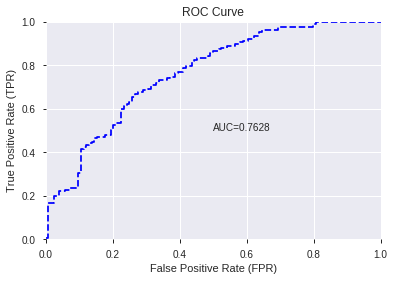

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


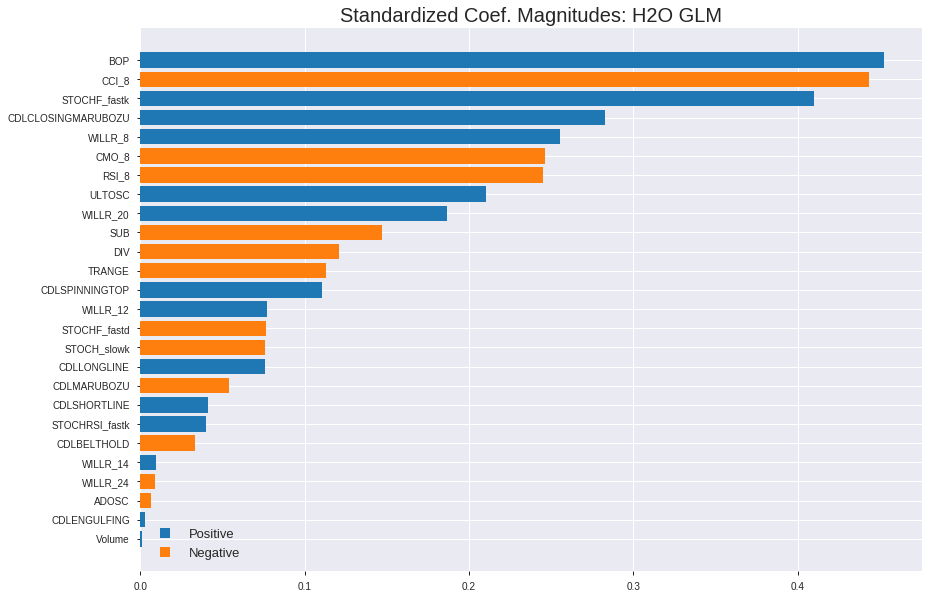

'log_likelihood'
--2019-09-03 02:48:14--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_024809_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_024809_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_83a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'CCI_8',
 'STOCHF_fastk',
 'CDLCLOSINGMARUBOZU',
 'WILLR_8',
 'CMO_8',
 'RSI_8',
 'ULTOSC',
 'WILLR_20',
 'SUB',
 'DIV',
 'TRANGE',
 'CDLSPINNINGTOP',
 'WILLR_12',
 'STOCHF_fastd',
 'STOCH_slowk',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLSHORTLINE',
 'STOCHRSI_fastk',
 'CDLBELTHOLD',
 'WILLR_14',
 'WILLR_24',
 'ADOSC',
 'CDLENGULFING',
 'Volume']

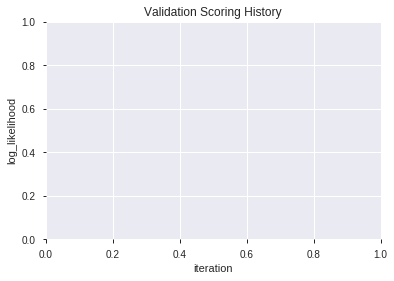

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_024819_model_1  0.759906  0.570523              0.301181  0.442450  0.195762
1               XGBoost_2_AutoML_20190903_024819  0.757557  0.579673              0.322200  0.445879  0.198808
2  XGBoost_grid_1_AutoML_20190903_024819_model_6  0.756287  0.580645              0.342647  0.446298  0.199182
3  XGBoost_grid_1_AutoML_20190903_024819_model_4  0.756287  0.587905              0.284481  0.449026  0.201624
4               XGBoost_1_AutoML_20190903_024819  0.752350  0.580716              0.342551  0.447644  0.200385
5  XGBoost_grid_1_AutoML_20190903_024819_model_2  0.751969  0.590456              0.342361  0.450288  0.202759
6  XGBoost_grid_1_AutoML_20190903_024819_model_7  0.747142  0.585691              0.300800  0.449946  0.202452
7  XGBoost_grid_1_AutoML_20190903_024819_model_3  0.747015  0.588364              0.313087  0.450583  0.203025
8               XGBoost_3_AutoML_20190903_024819  0.746888  0.581250              0.330074  0.447961  0.200669
9  XGBoost_grid_1_AutoML_20190903_024819_model_5  0.736093  0.595899              0.354267  0.455965  0.207904

variable  relative_importance  scaled_importance  percentage
0                  BOP          2358.013672           1.000000    0.321624
1         STOCHF_fastk           837.511169           0.355177    0.114233
2                  SUB           732.641602           0.310703    0.099929
3                CCI_8           603.155457           0.255790    0.082268
4               TRANGE           392.823395           0.166591    0.053580
5               Volume           274.233978           0.116299    0.037404
6                  DIV           259.768005           0.110164    0.035431
7                CMO_8           246.576569           0.104570    0.033632
8   CDLCLOSINGMARUBOZU           244.842377           0.103834    0.033396
9          STOCH_slowk           237.723267           0.100815    0.032425
10             WILLR_8           195.029327           0.082709    0.026601
11              ULTOSC           181.657745           0.077038    0.024777
12            WILLR_12           131.143967           0.055616    0.017888
13            WILLR_24           107.675552           0.045664    0.014687
14               ADOSC            98.807396           0.041903    0.013477
15      STOCHRSI_fastk            98.391106           0.041726    0.013420
16               RSI_8            86.975113           0.036885    0.011863
17            WILLR_14            75.689613           0.032099    0.010324
18            WILLR_20            60.420208           0.025623    0.008241
19        STOCHF_fastd            43.609550           0.018494    0.005948
20        CDLSHORTLINE            31.402689           0.013317    0.004283
21         CDLBELTHOLD            17.888723           0.007586    0.002440
22      CDLSPINNINGTOP            13.850523           0.005874    0.001889
23         CDLLONGLINE             1.758011           0.000746    0.000240

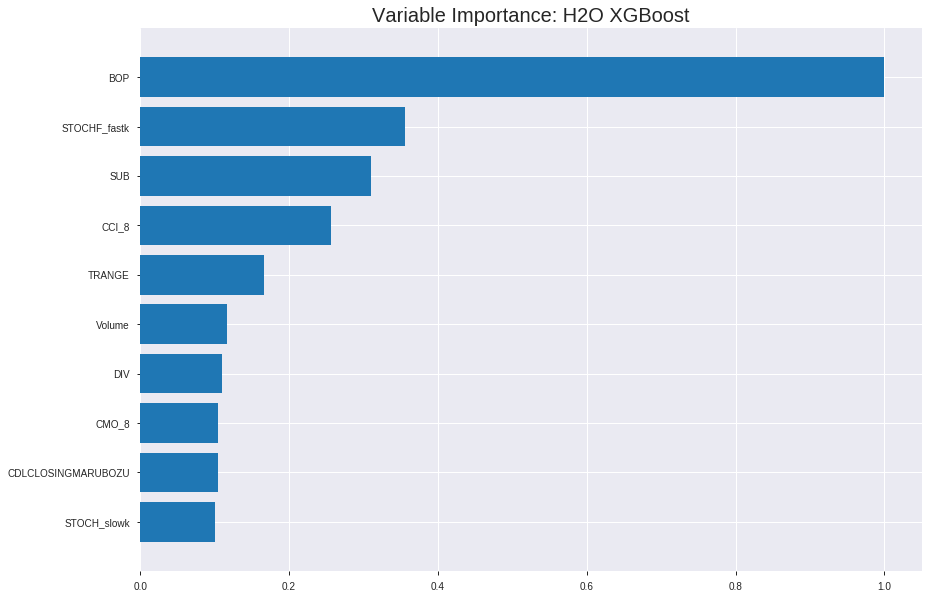

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_024819_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15762046438870508
RMSE: 0.39701443851414914
LogLoss: 0.4871433384748074
Mean Per-Class Error: 0.21493430552016568
AUC: 0.874178247319626
pr_auc: 0.8906182903457543
Gini: 0.748356494639252
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46949703246355057: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      547  268   0.3288   (268.0/815.0)
1      115  824   0.1225   (115.0/939.0)
Total  662  1092  0.2184   (383.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.469497     0.811423  228
max f2                       0.329542     0.886957  294
max f0point5                 0.645847     0.816007  137
max accuracy                 0.510824     0.787913  208
max precision                0.919642     1         0
max recall                   0.138429     1         367
max specificity              0.919642     1         0
max absolute_mcc             0.510824     0.572905  208
max min_per_class_accuracy   0.540498     0.779141  194
max mean_per_class_accuracy  0.510824     0.785066  208

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 53.36 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0108324                   0.892917           1.86794    1.86794            1                0.90455   1                           0.90455             0.0202343       0.0202343                  86.7945   86.7945
    2        0.0205245                   0.876889           1.86794    1.86794            1                0.883313  1                           0.894522            0.0181044       0.0383387                  86.7945   86.7945
    3        0.0302166                   0.864027           1.86794    1.86794            1                0.868805  1                           0.886273            0.0181044       0.056443                   86.7945   86.7945
    4        0.0404789                   0.851304           1.86794    1.86794            1                0.857603  1                           0.879005            0.0191693       0.0756124                  86.7945   86.7945
    5        0.050171                    0.840769           1.75807    1.84672            0.941176         0.846587  0.988636                    0.872742            0.0170394       0.0926518                  75.8066   84.6718
    6        0.100342                    0.803824           1.86794    1.85733            1                0.820629  0.994318                    0.846685            0.0937167       0.186368                   86.7945   85.7331
    7        0.149943                    0.763356           1.76059    1.82533            0.942529         0.783112  0.977186                    0.825655            0.0873269       0.273695                   76.0591   82.533
    8        0.200114                    0.734772           1.65568    1.7828             0.886364         0.749704  0.954416                    0.806613            0.0830671       0.356763                   65.5678   78.2796
    9        0.299886                    0.681723           1.6011     1.72234            0.857143         0.706976  0.922053                    0.773464            0.159744        0.516507                   60.1095   72.2344
    10       0.400228                    0.625194           1.30544    1.61782            0.698864         0.654311  0.866097                    0.743591            0.13099         0.647497                   30.5439   61.7821
    11       0.5                         0.55587            1.07807    1.51012            0.577143         0.591451  0.808438                    0.713232            0.107561        0.755059                   7.80709   51.0117
    12       0.599772                    0.483874           1.01403    1.42759            0.542857         0.517999  0.764259                    0.680755            0.101171        0.85623                    1.40271   42.7593
    13       0.700114                    0.424686           0.700479   1.32338            0.375            0.453454  0.708469                    0.648178            0.0702875       0.926518                   -29.9521  32.3381
    14       0.799886                    0.334399           0.469655   1.21689            0.251429         0.380564  0.651461                    0.614798            0.0468584       0.973376                   -53.0345  21.6893
    15       0.899658                    0.216042           0.245501   1.10917            0.131429         0.279504  0.59379                     0.577614            0.0244941       0.99787                    -75.4499  10.9166
    16       1                           0.047618           0.0212266  1                  0.0113636        0.13937   0.535348                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2029616040249497
RMSE: 0.45051260140527666
LogLoss: 0.5933061831645502
Mean Per-Class Error: 0.2918950696728475
AUC: 0.7468420801754135
pr_auc: 0.7277791019096062
Gini: 0.4936841603508271
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3347558081150055: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      89   154  0.6337   (154.0/243.0)
1      16   243  0.0618   (16.0/259.0)
Total  105  397  0.3386   (170.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.334756     0.740854  301
max f2                       0.219888     0.848608  338
max f0point5                 0.546577     0.714841  192
max accuracy                 0.526305     0.709163  203
max precision                0.921615     1         0
max recall                   0.0578807    1         397
max specificity              0.921615     1         0
max absolute_mcc             0.526305     0.417325  203
max min_per_class_accuracy   0.550942     0.699588  191
max mean_per_class_accuracy  0.526305     0.708105  203

Gains/Lift Table: Avg response rate: 51.59 %, avg score: 51.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.888308           1.93822   1.93822            1                0.900919  1                           0.900919            0.023166        0.023166                   93.8224   93.8224
    2        0.0219124                   0.86339            1.16293   1.58582            0.6              0.86986   0.818182                    0.886801            0.011583        0.034749                   16.2934   58.582
    3        0.0318725                   0.854243           1.55058   1.57481            0.8              0.856153  0.8125                      0.877224            0.015444        0.0501931                  55.0579   57.4807
    4        0.0418327                   0.844527           1.93822   1.66133            1                0.849315  0.857143                    0.870579            0.019305        0.0694981                  93.8224   66.1335
    5        0.0517928                   0.833418           1.16293   1.56549            0.6              0.836582  0.807692                    0.864041            0.011583        0.0810811                  16.2934   56.5489
    6        0.101594                    0.784325           1.62811   1.59618            0.84             0.809813  0.823529                    0.837459            0.0810811       0.162162                   62.8108   59.6184
    7        0.151394                    0.750074           1.39552   1.53018            0.72             0.764514  0.789474                    0.813464            0.0694981       0.23166                    39.5521   53.0177
    8        0.201195                    0.714422           1.55058   1.53523            0.8              0.732181  0.792079                    0.793344            0.0772201       0.30888                    55.0579   53.5227
    9        0.300797                    0.648989           1.27923   1.45046            0.66             0.67773   0.748344                    0.755061            0.127413        0.436293                   27.9228   45.0459
    10       0.400398                    0.589959           1.2017    1.38858            0.62             0.620547  0.716418                    0.7216              0.119691        0.555985                   20.1699   38.8578
    11       0.5                         0.552537           1.31799   1.37452            0.68             0.572033  0.709163                    0.691806            0.131274        0.687259                   31.7992   37.4517
    12       0.599602                    0.490289           0.969112  1.30717            0.5              0.522892  0.674419                    0.663747            0.0965251       0.783784                   -3.0888   30.7174
    13       0.699203                    0.412975           0.814054  1.23693            0.42             0.450265  0.638177                    0.633336            0.0810811       0.864865                   -18.5946  23.6929
    14       0.798805                    0.321807           0.736525  1.17453            0.38             0.371911  0.605985                    0.60074             0.0733591       0.938224                   -26.3475  17.4535
    15       0.898406                    0.184588           0.271351  1.0744             0.14             0.246597  0.554324                    0.561478            0.027027        0.965251                   -72.8649  7.44035
    16       1                           0.0485478          0.34204   1                  0.176471         0.124103  0.515936                    0.517043          


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:48:23  0.021 sec   0                  0.5              0.693147            0.5             0                  1                0.464652                         0.5                0.693147              0.5               0                    1                  0.484064
    2019-09-03 02:48:23  0.110 sec   5                  0.474711         0.643502            0.807128        0.827851           1.86794          0.27309                          0.482367           0.658274              0.730048          0.711923             1.45367            0.36255
    2019-09-03 02:48:23  0.172 sec   10                 0.456778         0.60873             0.819328        0.834333           1.76417          0.267959                         0.46953            0.63292               0.747581          0.738455             1.61519            0.316733
    2019-09-03 02:48:24  0.235 sec   15                 0.443591         0.582914            0.828321        0.844417           1.76417          0.276511                         0.462015           0.617784              0.751672          0.745451             1.93822            0.310757
    2019-09-03 02:48:24  0.300 sec   20                 0.433618         0.562844            0.834462        0.852127           1.86794          0.265678                         0.457043           0.607357              0.752483          0.746558             1.93822            0.312749
    2019-09-03 02:48:24  0.361 sec   25                 0.425591         0.54651             0.841884        0.85992            1.86794          0.267389                         0.454345           0.601446              0.750655          0.742661             1.93822            0.320717
    2019-09-03 02:48:24  0.423 sec   30                 0.418488         0.531941            0.850195        0.869749           1.86794          0.255986                         0.452638           0.597669              0.749654          0.736109             1.93822            0.320717
    2019-09-03 02:48:24  0.485 sec   35                 0.413129         0.520918            0.855515        0.87382            1.86794          0.259407                         0.451493           0.595024              0.749837          0.736921             1.93822            0.324701
    2019-09-03 02:48:24  0.568 sec   40                 0.409876         0.513633            0.857425        0.875118           1.86794          0.255986                         0.451079           0.594113              0.74917           0.73543              1.93822            0.324701
    2019-09-03 02:48:24  0.637 sec   45                 0.406956         0.507218            0.860506        0.878437           1.86794          0.253706                         0.450513           0.592996              0.749519          0.733174             1.93822            0.334661
    2019-09-03 02:48:24  0.714 sec   50                 0.402562         0.498592            0.867673        0.885102           1.86794          0.230901                         0.450065           0.592176              0.750203          0.732221             1.93822            0.316733
    2019-09-03 02:48:24  0.785 sec   55                 0.399822         0.49286             0.870789        0.887864           1.86794          0.22691                          0.450363           0.592988              0.748884          0.

Variable Importances: 


variable        relative_importance    scaled_importance      percentage
--------------  ---------------------  ---------------------  ----------------------
BOP             2358.013671875         1.0                    0.32162382086635616
STOCHF_fastk    837.5111694335938      0.3551765536489183     0.11423324026670945
SUB             732.6416015625         0.3107028641525781     0.09992944232287257
CCI_8           603.1554565429688      0.25578963503776597    0.08226803975885708
TRANGE          392.8233947753906      0.16659080456604514    0.05357957108573185
---             ---                    ---                    ---
STOCHF_fastd    43.60955047607422      0.01849418898466251    0.0059481717250716324
CDLSHORTLINE    31.40268898010254      0.013317432954123779   0.004283203670836814
CDLBELTHOLD     17.888723373413086     0.007586352694549338   0.002439951740060735
CDLSPINNINGTOP  13.850522994995117     0.005873809452504881   0.0018891570391555393
CDLLONGLINE     1.7580113410949707     0.0007455475606708713  0.00023978585510055713


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.701195219123506)

('F1', 0.7524752475247524)

('auc', 0.7599060198120396)

('logloss', 0.570523290087575)

('mean_per_class_error', 0.30108585217170436)

('rmse', 0.44245032610975443)

('mse', 0.19576229107462803)

xgboost prediction progress: |████████████████████████████████████████████| 100%


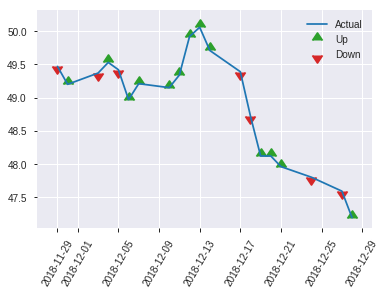


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19576229107462803
RMSE: 0.44245032610975443
LogLoss: 0.570523290087575
Mean Per-Class Error: 0.30108585217170436
AUC: 0.7599060198120396
pr_auc: 0.7274674292619249
Gini: 0.5198120396240793
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4046986699104309: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      62   62   0.5      (62.0/124.0)
1      13   114  0.1024   (13.0/127.0)
Total  75   176  0.2988   (75.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.404699     0.752475  175
max f2                       0.24874      0.877437  209
max f0point5                 0.542768     0.704809  118
max accuracy                 0.40804      0.701195  173
max precision                0.926017     1         0
max recall                   0.138531     1         229
max specificity              0.926017     1         0
max absolute_mcc             0.404699     0.434324  175
max min_per_class_accuracy   0.52578      0.685484  126
max mean_per_class_accuracy  0.40804      0.698914  173

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 49.98 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.893644           1.31759    1.31759            0.666667         0.905647  0.666667                    0.905647            0.015748        0.015748                   31.7585   31.7585
    2        0.0239044                   0.858857           1.97638    1.64698            1                0.870979  0.833333                    0.888313            0.023622        0.0393701                  97.6378   64.6982
    3        0.0318725                   0.82644            1.97638    1.72933            1                0.843569  0.875                       0.877127            0.015748        0.0551181                  97.6378   72.9331
    4        0.0438247                   0.817235           1.97638    1.79671            1                0.821156  0.909091                    0.861862            0.023622        0.0787402                  97.6378   79.6707
    5        0.0517928                   0.809927           0.988189   1.67232            0.5              0.815914  0.846154                    0.854793            0.00787402      0.0866142                  -1.1811   67.232
    6        0.103586                    0.749238           1.67232    1.67232            0.846154         0.772787  0.846154                    0.81379             0.0866142       0.173228                   67.232    67.232
    7        0.151394                    0.723748           1.31759    1.5603             0.666667         0.735633  0.789474                    0.789109            0.0629921       0.23622                    31.7585   56.0298
    8        0.203187                    0.69261            1.52029    1.5501             0.769231         0.709693  0.784314                    0.768866            0.0787402       0.314961                   52.0291   55.01
    9        0.302789                    0.632821           1.26488    1.45628            0.64             0.65968   0.736842                    0.732949            0.125984        0.440945                   26.4882   45.6278
    10       0.40239                     0.582408           1.26488    1.4089             0.64             0.608422  0.712871                    0.702126            0.125984        0.566929                   26.4882   40.8903
    11       0.501992                    0.52739            1.18583    1.36464            0.6              0.554788  0.690476                    0.672892            0.11811         0.685039                   18.5827   36.4642
    12       0.601594                    0.461437           1.02772    1.30886            0.52             0.501617  0.662252                    0.644535            0.102362        0.787402                   2.77165   30.886
    13       0.701195                    0.404699           1.10677    1.28015            0.56             0.429692  0.647727                    0.614018            0.110236        0.897638                   10.6772   28.0154
    14       0.800797                    0.294549           0.553386   1.18976            0.28             0.363446  0.60199                     0.582852            0.0551181       0.952756                   -44.6614  18.976
    15       0.900398                    0.152077           0.395276   1.10187            0.2              0.230488  0.557522                    0.543874            0.0393701       0.992126                   -60.4724  10.1874
    16       1                           0.0500286          0.0790551  1                  0.04             0.101344  0.505976                    0.499

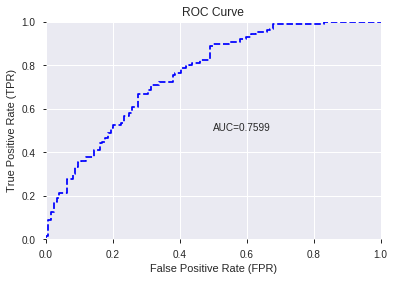

This function is available for GLM models only


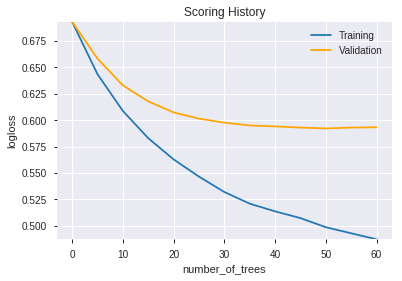

--2019-09-03 02:48:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.80.128
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.80.128|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_024819_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_024819_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_83a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'SUB',
 'CCI_8',
 'TRANGE',
 'Volume',
 'DIV',
 'CMO_8',
 'CDLCLOSINGMARUBOZU',
 'STOCH_slowk',
 'WILLR_8',
 'ULTOSC',
 'WILLR_12',
 'WILLR_24',
 'ADOSC',
 'STOCHRSI_fastk',
 'RSI_8',
 'WILLR_14',
 'WILLR_20',
 'STOCHF_fastd',
 'CDLSHORTLINE',
 'CDLBELTHOLD',
 'CDLSPINNINGTOP',
 'CDLLONGLINE']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

120

['BBANDS_upperband_14_6_4',
 'BBANDS_lowerband_14_6_4',
 'BBANDS_lowerband_14_6_5',
 'BBANDS_upperband_14_7_3',
 'BBANDS_upperband_14_7_4',
 'BBANDS_middleband_14_7_4',
 'BBANDS_lowerband_14_7_4',
 'SMA_20',
 'BBANDS_lowerband_20_0_3',
 'BBANDS_middleband_20_0_4',
 'BBANDS_lowerband_20_0_4',
 'BBANDS_lowerband_20_1_2',
 'BBANDS_upperband_20_1_4',
 'BBANDS_lowerband_20_1_4',
 'BBANDS_upperband_20_2_3',
 'MAVP_20_3',
 'BBANDS_lowerband_20_6_4',
 'BBANDS_lowerband_20_6_5',
 'BBANDS_middleband_20_7_2',
 'BBANDS_lowerband_24_2_3',
 'BBANDS_upperband_24_3_3',
 'BBANDS_lowerband_24_3_5',
 'BBANDS_upperband_24_6_4',
 'BBANDS_lowerband_30_5_2',
 'BOP',
 'CMO_8',
 'MACDFIX_hist_8',
 'MINUS_DI_8',
 'PLUS_DI_8',
 'PLUS_DM_8',
 'ROC_8',
 'ROCP_8',
 'ROCR100_8',
 'RSI_8',
 'WILLR_8',
 'ADX_12',
 'aroondown_12',
 'AROONOSC_12',
 'CCI_12',
 'CMO_12',
 'MFI_12',
 'PLUS_DM_12',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'WILLR_12',
 'ADX_14',
 'aroondown_14',
 'aroonup_14',
 'AROONOSC_14',
 'CCI

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190903_024949_model_9  0.783401  0.594939              0.285528  0.451497  0.203850
1  DeepLearning_grid_1_AutoML_20190903_024949_model_8  0.769177  0.565482              0.318453  0.440465  0.194009
2  DeepLearning_grid_1_AutoML_20190903_024949_model_5  0.759208  0.582453              0.309817  0.447703  0.200438
3  DeepLearning_grid_1_AutoML_20190903_024949_model_7  0.754699  0.616821              0.316834  0.456348  0.208253
4  DeepLearning_grid_1_AutoML_20190903_024949_model_4  0.745047  0.644113              0.317691  0.467568  0.218620
5  DeepLearning_grid_1_AutoML_20190903_024949_model_3  0.739903  0.720493              0.342266  0.481750  0.232083
6  DeepLearning_grid_1_AutoML_20190903_024949_model_6  0.739713  0.612087              0.322295  0.460774  0.212313
7  DeepLearning_grid_1_AutoML_20190903_024949_model_1  0.738189  0.801243              0.362236  0.497189  0.247197
8  DeepLearning_grid_1_AutoML_20190903_024949_model_2  0.726441  0.686381              0.345250  0.480943  0.231306
9               DeepLearning_1_AutoML_20190903_024949  0.572644  0.721347              0.500000  0.509435  0.259524

variable  relative_importance  scaled_importance  percentage
0                        BOP             1.000000           1.000000    0.018339
1         CDLCLOSINGMARUBOZU             0.752899           0.752899    0.013807
2                     TRANGE             0.631087           0.631087    0.011573
3               STOCHF_fastk             0.508663           0.508663    0.009328
4             CDLSPINNINGTOP             0.498000           0.498000    0.009133
..                       ...                  ...                ...         ...
115             aroondown_14             0.419220           0.419220    0.007688
116               CDLHIKKAKE             0.418913           0.418913    0.007682
117  BBANDS_lowerband_14_7_4             0.417445           0.417445    0.007655
118                   ADX_12             0.417440           0.417440    0.007655
119                    RSI_8             0.417274           0.417274    0.007652

[120 rows x 4 columns]

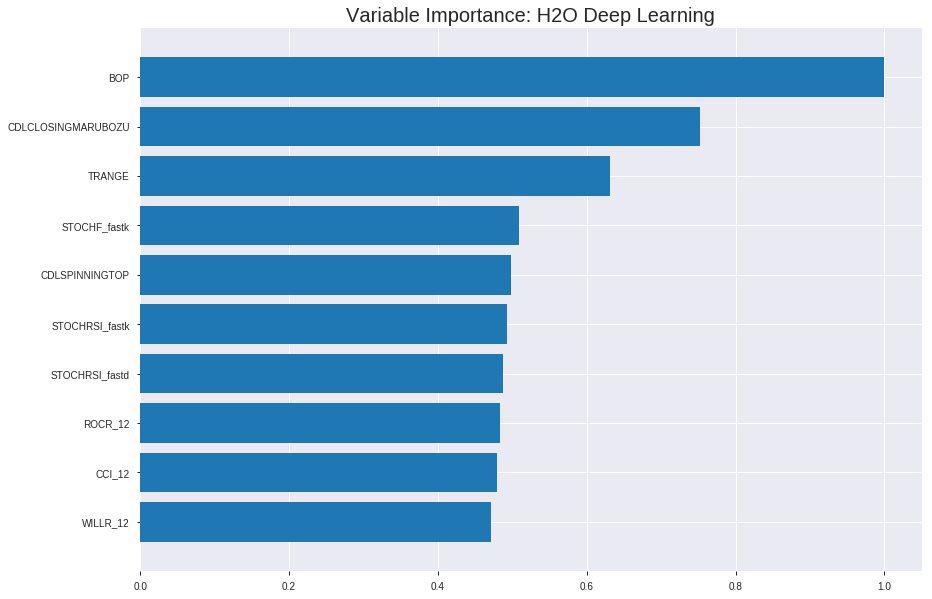

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190903_024949_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20249718528649469
RMSE: 0.4499968725296818
LogLoss: 0.5909916574860054
Mean Per-Class Error: 0.3069372848023939
AUC: 0.7565299202257982
pr_auc: 0.7582587626797613
Gini: 0.5130598404515965
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4242193627517106: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      385  430   0.5276   (430.0/815.0)
1      111  828   0.1182   (111.0/939.0)
Total  496  1258  0.3084   (541.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.424219     0.753755  247
max f2                       0.264747     0.861616  327
max f0point5                 0.547243     0.718681  165
max accuracy                 0.437469     0.695553  238
max precision                0.837999     1         0
max recall                   0.0668359    1         393
max specificity              0.837999     1         0
max absolute_mcc             0.437469     0.39508   238
max min_per_class_accuracy   0.518203     0.692025  185
max mean_per_class_accuracy  0.519504     0.693063  184

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 50.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.820399           1.76417   1.76417            0.944444         0.826632  0.944444                    0.826632            0.0181044       0.0181044                  76.417    76.417
    2        0.0205245                   0.80316            1.6604    1.71228            0.888889         0.810525  0.916667                    0.818579            0.0170394       0.0351438                  66.0395   71.2283
    3        0.0302166                   0.7956             1.53831   1.65648            0.823529         0.799857  0.886792                    0.812574            0.0149095       0.0500532                  53.8307   65.6479
    4        0.0404789                   0.786343           1.6604    1.65747            0.888889         0.789874  0.887324                    0.806819            0.0170394       0.0670927                  66.0395   65.7472
    5        0.050171                    0.770133           1.64819   1.65568            0.882353         0.778719  0.886364                    0.80139             0.0159744       0.0830671                  64.8186   65.5678
    6        0.100342                    0.713695           1.52832   1.592              0.818182         0.740112  0.852273                    0.770751            0.0766773       0.159744                   52.8318   59.1998
    7        0.149943                    0.687715           1.41706   1.53413            0.758621         0.700634  0.821293                    0.747557            0.0702875       0.230032                   41.7061   53.4129
    8        0.200114                    0.665066           1.37973   1.49542            0.738636         0.67599   0.80057                     0.729614            0.0692226       0.299255                   37.9732   49.542
    9        0.299886                    0.61543            1.36627   1.45245            0.731429         0.640155  0.777567                    0.699851            0.136315        0.43557                    36.6268   45.2451
    10       0.400228                    0.563239           1.28421   1.41027            0.6875           0.588708  0.754986                    0.671986            0.12886         0.56443                    28.4212   41.0272
    11       0.5                         0.523202           1.12077   1.3525             0.6              0.543963  0.724059                    0.64644             0.111821        0.676251                   12.0767   35.2503
    12       0.599772                    0.48371            0.928635  1.28199            0.497143         0.503406  0.686312                    0.622646            0.0926518       0.768903                   -7.13647  28.1992
    13       0.700114                    0.432356           0.976426  1.2382             0.522727         0.456203  0.662866                    0.598791            0.0979766       0.86688                    -2.35744  23.8198
    14       0.799886                    0.371639           0.651112  1.16497            0.348571         0.403691  0.623664                    0.574456            0.0649627       0.931842                   -34.8888  16.4969
    15       0.899658                    0.262704           0.469655  1.08786            0.251429         0.321229  0.582383                    0.546373            0.0468584       0.978701                   -53.0345  8.78588
    16       1                           0.0508117          0.212266  1                  0.113636         0.163871  0.535348                    0.507992           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.21647789764834863
RMSE: 0.4652718534882038
LogLoss: 0.621191522825642
Mean Per-Class Error: 0.32403037958593517
AUC: 0.7211973878640545
pr_auc: 0.728211187852821
Gini: 0.44239477572810904
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46449857479408074: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      114  129  0.5309   (129.0/243.0)
1      42   217  0.1622   (42.0/259.0)
Total  156  346  0.3406   (171.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.464499     0.717355  253
max f2                       0.189809     0.853659  378
max f0point5                 0.55454      0.685373  151
max accuracy                 0.496275     0.679283  220
max precision                0.676125     0.962963  24
max recall                   0.189809     1         378
max specificity              0.780555     0.995885  0
max absolute_mcc             0.494696     0.360936  222
max min_per_class_accuracy   0.526678     0.65251   183
max mean_per_class_accuracy  0.496275     0.67597   220

Gains/Lift Table: Avg response rate: 51.59 %, avg score: 49.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.746724           1.61519   1.61519            0.833333         0.760112  0.833333                    0.760112            0.019305        0.019305                   61.5187   61.5187
    2        0.0219124                   0.729929           1.93822   1.76202            1                0.737032  0.909091                    0.749621            0.019305        0.03861                    93.8224   76.2022
    3        0.0318725                   0.709312           1.93822   1.81708            1                0.71361   0.9375                      0.738368            0.019305        0.0579151                  93.8224   81.7085
    4        0.0418327                   0.691369           1.93822   1.84593            1                0.696004  0.952381                    0.728281            0.019305        0.0772201                  93.8224   84.5928
    5        0.0517928                   0.679789           1.93822   1.86368            1                0.682635  0.961538                    0.719503            0.019305        0.0965251                  93.8224   86.3677
    6        0.101594                    0.639122           1.70564   1.78621            0.88             0.658028  0.921569                    0.689368            0.0849421       0.181467                   70.5637   78.6206
    7        0.151394                    0.617258           1.47305   1.68319            0.76             0.626635  0.868421                    0.668732            0.0733591       0.254826                   47.305    68.3194
    8        0.201195                    0.60401            1.00788   1.51604            0.52             0.611093  0.782178                    0.654465            0.0501931       0.305019                   0.787645  51.6037
    9        0.300797                    0.577033           1.00788   1.34777            0.52             0.590541  0.695364                    0.633298            0.100386        0.405405                   0.787645  34.7772
    10       0.400398                    0.557564           1.51181   1.38858            0.78             0.566593  0.716418                    0.616705            0.150579        0.555985                   51.1815   38.8578
    11       0.5                         0.526016           0.969112  1.30502            0.5              0.543566  0.673307                    0.602135            0.0965251       0.65251                    -3.0888   30.5019
    12       0.599602                    0.497298           1.12417   1.27498            0.58             0.51298   0.657807                    0.587325            0.111969        0.764479                   12.417    27.4978
    13       0.699203                    0.459386           0.77529   1.2038             0.4              0.479119  0.621083                    0.571911            0.0772201       0.841699                   -22.471   20.3797
    14       0.798805                    0.39763            0.620232  1.13103            0.32             0.432019  0.583541                    0.554469            0.0617761       0.903475                   -37.9768  13.1033
    15       0.898406                    0.298491           0.620232  1.0744             0.32             0.354531  0.554324                    0.532302            0.0617761       0.965251                   -37.9768  7.44035
    16       1                           0.063264           0.34204   1                  0.176471         0.199212  0.515936                    0.498463         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:56:31  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-03 02:56:33  2 min 25.921 sec  462 obs/sec       0.563284  1             988        0.585914         1.17275             -0.38008       0.625196        0.647574           1.6604           0.436716                         0.492292           0.685145              0.0296097        0.644597          0.640398             1.29215            0.454183
    2019-09-03 02:56:45  2 min 37.510 sec  770 obs/sec       5.58153   10            9790       0.449997         0.590992            0.185943       0.75653         0.758259           1.76417          0.308438                         0.465272           0.621192              0.133208         0.721197          0.728211             1.61519            0.340637
    2019-09-03 02:56:56  2 min 48.257 sec  911 obs/sec       11.6591   21            20450      0.452631         0.599298            0.176383       0.760707        0.758551           1.76417          0.308438                         0.480138           0.651759              0.0769311        0.703322          0.715892             1.93822            0.394422
    2019-09-03 02:57:06  2 min 59.006 sec  1000 obs/sec      18.3415   33            32171      0.446227         0.583791            0.199526       0.775697        0.777333           1.6604           0.302166                         0.468754           0.627235              0.120183         0.698151          0.70598              1.93822            0.384462
    2019-09-03 02:57:17  3 min  9.658 sec  1072 obs/sec      25.5348   46            44788      0.438163         0.567092            0.228196       0.779539        0.781785           1.76417          0.297605                         0.479878           0.650184              0.077933         0.696101          0.710137             1.61519            0.40239
    2019-09-03 02:57:27  3 min 20.035 sec  1141 obs/sec      33.2474   60            58316      0.432095         0.553175            0.249426       0.787655        0.790232           1.76417          0.284493                         0.484538           0.661984              0.0599366        0.700288          0.713182             1.61519            0.396414
    2019-09-03 02:57:38  3 min 30.733 sec  1199 obs/sec      41.5616   75            72899      0.433536         0.557324            0.244411       0.793033        0.796776           1.76417          0.294185                         0.50774            0.721932              -0.0322492       0.666555          0.688827             1.93822            0.40239
    2019-09-03 02:57:39  3 min 31.808 sec  1198 obs/sec      41.5616   75            72899      0.449997         0.590992            0.185943       0.75653         0.758259           1.76417          0.308438                         0.465272           0.621192              0.133208         0.721197          0.728211             1.61519            0.340637

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
BOP                      1.0                    1.0                  0.018338539211993583
CDLCLOSINGMARUBOZU       0.7528988122940063     0.7528988122940063   0.013807064391917033
TRANGE                   0.631087064743042      0.631087064743042    0.01157321488297221
STOCHF_fastk             0.5086629390716553     0.5086629390716553   0.009328135253853453
CDLSPINNINGTOP           0.49799999594688416    0.49799999594688416  0.009132592453244581
---                      ---                    ---                  ---
aroondown_14             0.4192195236682892     0.4192195236682892   0.007687873673224194
CDLHIKKAKE               0.4189133942127228     0.4189133942127228   0.007682259706199342
BBANDS_lowerband_14_7_4  0.4174453318119049     0.4174453318119049   0.007655337586296291
ADX_12                   0.417439728975296      0.417439728975296    0.00765523483845744
RSI_8                    0.41727393865585327    0.41727393865585327  0.007652194486183371


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7171314741035857)

('F1', 0.7702265372168285)

('auc', 0.7834010668021336)

('logloss', 0.5949394069681342)

('mean_per_class_error', 0.28552832105664216)

('rmse', 0.4514973166006459)

('mse', 0.2038498268975839)

deeplearning prediction progress: |███████████████████████████████████████| 100%


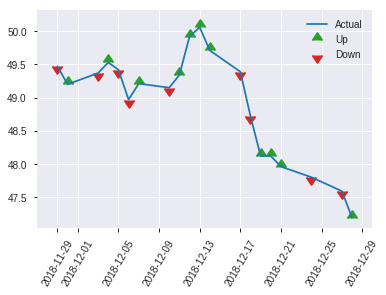


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2038498268975839
RMSE: 0.4514973166006459
LogLoss: 0.5949394069681342
Mean Per-Class Error: 0.28552832105664216
AUC: 0.7834010668021336
pr_auc: 0.7507886188242929
Gini: 0.5668021336042672
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.446600165321928: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      61   63   0.5081   (63.0/124.0)
1      8    119  0.063    (8.0/127.0)
Total  69   182  0.2829   (71.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.4466       0.770227  181
max f2                       0.378892     0.878661  208
max f0point5                 0.549312     0.720251  87
max accuracy                 0.4466       0.717131  181
max precision                0.756751     1         0
max recall                   0.334289     1         223
max specificity              0.756751     1         0
max absolute_mcc             0.4466       0.480344  181
max min_per_class_accuracy   0.514447     0.701613  126
max mean_per_class_accuracy  0.4466       0.714472  181

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 49.11 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.742028           1.97638   1.97638            1                0.748526  1                           0.748526            0.023622        0.023622                   97.6378   97.6378
    2        0.0239044                   0.708014           1.31759   1.64698            0.666667         0.718851  0.833333                    0.733689            0.015748        0.0393701                  31.7585   64.6982
    3        0.0318725                   0.694196           1.97638   1.72933            1                0.704185  0.875                       0.726313            0.015748        0.0551181                  97.6378   72.9331
    4        0.0438247                   0.653956           1.97638   1.79671            1                0.673365  0.909091                    0.711872            0.023622        0.0787402                  97.6378   79.6707
    5        0.0517928                   0.643082           0.988189  1.67232            0.5              0.650888  0.846154                    0.70249             0.00787402      0.0866142                  -1.1811   67.232
    6        0.103586                    0.609439           1.82435   1.74833            0.923077         0.621883  0.884615                    0.662186            0.0944882       0.181102                   82.4349   74.8334
    7        0.151394                    0.599848           1.15289   1.5603             0.583333         0.603737  0.789474                    0.643729            0.0551181       0.23622                    15.2887   56.0298
    8        0.203187                    0.585604           1.36826   1.51135            0.692308         0.591335  0.764706                    0.630374            0.0708661       0.307087                   36.8262   51.1348
    9        0.302789                    0.560682           1.5811    1.53429            0.8              0.572324  0.776316                    0.611278            0.15748         0.464567                   58.1102   53.4293
    10       0.40239                     0.534996           1.26488   1.46761            0.64             0.546885  0.742574                    0.595339            0.125984        0.590551                   26.4882   46.7607
    11       0.501992                    0.51558            1.10677   1.39601            0.56             0.523969  0.706349                    0.581179            0.110236        0.700787                   10.6772   39.6013
    12       0.601594                    0.495035           0.948661  1.32195            0.48             0.506242  0.668874                    0.568772            0.0944882       0.795276                   -5.13386  32.1948
    13       0.701195                    0.460882           1.02772   1.28015            0.52             0.476699  0.647727                    0.555693            0.102362        0.897638                   2.77165   28.0154
    14       0.800797                    0.39965            0.790551  1.21926            0.4              0.433452  0.616915                    0.540489            0.0787402       0.976378                   -20.9449  21.9258
    15       0.900398                    0.312637           0.237165  1.11062            0.12             0.363712  0.561947                    0.520934            0.023622        1                          -76.2835  11.0619
    16       1                           0.0775255          0         1                  0                0.221194  0.505976                    0.49108           

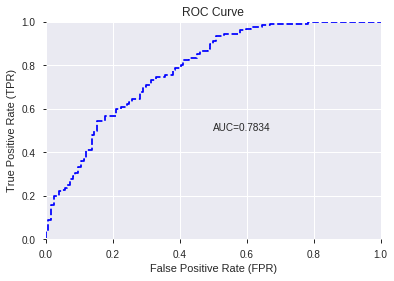

This function is available for GLM models only


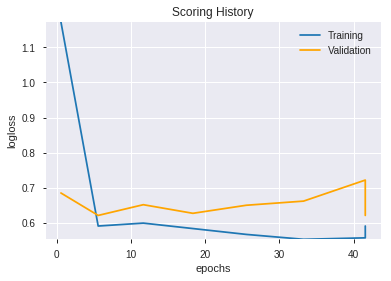

--2019-09-03 02:57:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.121.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.121.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190903_024949_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190903_024949_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_83a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'TRANGE',
 'STOCHF_fastk',
 'CDLSPINNINGTOP',
 'STOCHRSI_fastk',
 'STOCHRSI_fastd',
 'ROCR_12',
 'CCI_12',
 'WILLR_12',
 'aroonup_14',
 'MINUS_DM_30',
 'WILLR_8',
 'TYPPRICE',
 'VAR_14',
 'MFI_24',
 'ROC_20',
 'PLUS_DM_8',
 'PLUS_DI_8',
 'DX_24',
 'BBANDS_lowerband_20_1_2',
 'ROC_8',
 'MFI_30',
 'MACDEXT',
 'LINEARREG_ANGLE_12',
 'MINUS_DI_8',
 'MFI_12',
 'aroondown_12',
 'MOM_24',
 'MACDFIX_hist_8',
 'BETA_8',
 'DX_20',
 'CMO_14',
 'PLUS_DI_20',
 'MINUS_DI_24',
 'PLUS_DM_12',
 'BBANDS_upperband_14_7_4',
 'NATR_12',
 'VAR_12',
 'AROONOSC_24',
 'ADX_24',
 'MACDFIX_signal_14',
 'VAR_8',
 'WILLR_20',
 'BBANDS_lowerband_24_2_3',
 'LINEARREG_ANGLE_8',
 'BBANDS_lowerband_24_3_5',
 'BBANDS_lowerband_20_0_3',
 'BBANDS_middleband_20_7_2',
 'VAR_20',
 'CCI_14',
 'NATR_24',
 'WILLR_30',
 'BETA_20',
 'ROCR_24',
 'aroonup_24',
 'ROC_12',
 'CDLLONGLEGGEDDOJI',
 'CDLENGULFING',
 'MOM_14',
 'HT_PHASOR_quadrature',
 'CMO_8',
 'BBANDS_upperband_24_6_4',
 'STDDEV_20',
 'RO

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190903_025751_model_1  0.761684  0.576982              0.318167  0.445206  0.198209

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.403033           1.000000    0.076634
1                TRANGE             0.332588           0.825212    0.063239
2    CDLCLOSINGMARUBOZU             0.251942           0.625116    0.047905
3          STOCHF_fastk             0.222202           0.551325    0.042250
4              WILLR_20             0.149129           0.370018    0.028356
..                  ...                  ...                ...         ...
115              SMA_20             0.001437           0.003567    0.000273
116  LINEARREG_SLOPE_20             0.001290           0.003201    0.000245
117           MAVP_20_3             0.001222           0.003033    0.000232
118  LINEARREG_ANGLE_14             0.001212           0.003008    0.000231
119        LINEARREG_12             0.000940           0.002332    0.000179

[120 rows x 4 columns]

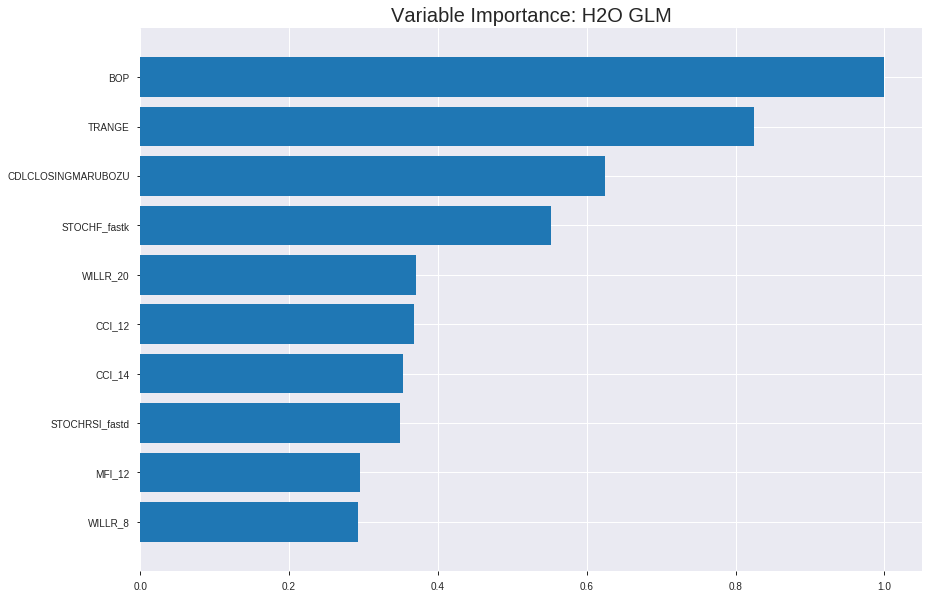

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190903_025751_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1975022784330651
RMSE: 0.4444122842958609
LogLoss: 0.5789038826929009
Null degrees of freedom: 1753
Residual degrees of freedom: 1633
Null deviance: 2422.786744110176
Residual deviance: 2030.7948204866964
AIC: 2272.794820486696
AUC: 0.7640369274191967
pr_auc: 0.7701764886395505
Gini: 0.5280738548383934
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39964138951807177: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      352  463   0.5681   (463.0/815.0)
1      87   852   0.0927   (87.0/939.0)
Total  439  1315  0.3136   (550.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.399641     0.755989  272
max f2                       0.290553     0.861289  323
max f0point5                 0.524674     0.723386  196
max accuracy                 0.524674     0.702395  196
max precision                0.937055     1         0
max recall                   0.0953161    1         387
max specificity              0.937055     1         0
max absolute_mcc             0.524674     0.402641  196
max min_per_class_accuracy   0.533449     0.695706  191
max mean_per_class_accuracy  0.524674     0.701548  196

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 53.53 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.900008           1.86794   1.86794            1                0.910222  1                           0.910222            0.0191693       0.0191693                  86.7945   86.7945
    2        0.0205245                   0.883666           1.86794   1.86794            1                0.892985  1                           0.901604            0.0191693       0.0383387                  86.7945   86.7945
    3        0.0302166                   0.866851           1.53831   1.76221            0.823529         0.874226  0.943396                    0.892822            0.0149095       0.0532481                  53.8307   76.2212
    4        0.0404789                   0.856498           1.55662   1.71009            0.833333         0.86067   0.915493                    0.884671            0.0159744       0.0692226                  55.6621   71.009
    5        0.050171                    0.836867           1.75807   1.71936            0.941176         0.845394  0.920455                    0.877083            0.0170394       0.086262                   75.8066   71.9358
    6        0.100342                    0.78401            1.37973   1.54954            0.738636         0.807812  0.829545                    0.842448            0.0692226       0.155485                   37.9732   54.9545
    7        0.149943                    0.743922           1.54589   1.54833            0.827586         0.762189  0.828897                    0.815898            0.0766773       0.232162                   54.5885   54.8334
    8        0.200114                    0.717538           1.54954   1.54864            0.829545         0.730411  0.82906                     0.794465            0.0777423       0.309904                   54.9545   54.8638
    9        0.299886                    0.665401           1.36627   1.48796            0.731429         0.69139   0.796578                    0.760172            0.136315        0.446219                   36.6268   48.7963
    10       0.400228                    0.606471           1.25237   1.4289             0.670455         0.637559  0.764957                    0.729432            0.125666        0.571885                   25.2372   42.8898
    11       0.5                         0.542508           1.08874   1.36102            0.582857         0.57528   0.72862                     0.698672            0.108626        0.680511                   8.87449   36.1022
    12       0.599772                    0.481764           0.982005  1.29797            0.525714         0.509877  0.694867                    0.667266            0.0979766       0.778488                   -1.79948  29.7973
    13       0.700114                    0.424942           0.817226  1.22907            0.4375           0.453386  0.65798                     0.636612            0.0820021       0.86049                    -18.2774  22.9071
    14       0.799886                    0.36546            0.72583   1.1663             0.388571         0.397021  0.624376                    0.606727            0.0724175       0.932907                   -27.417   16.63
    15       0.899658                    0.272424           0.426959  1.08431            0.228571         0.322926  0.580482                    0.575254            0.0425985       0.975506                   -57.3041  8.43075
    16       1                           0.02758            0.244106  1                  0.130682         0.177556  0.535348                    0.535348            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2103904560473942
RMSE: 0.458683394126487
LogLoss: 0.6061298030598371
Null degrees of freedom: 501
Residual degrees of freedom: 381
Null deviance: 696.1689483589155
Residual deviance: 608.5543222720765
AIC: 850.5543222720765
AUC: 0.7276403387514498
pr_auc: 0.7435847535736911
Gini: 0.4552806775028997
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46657621938628374: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      129  114  0.4691   (114.0/243.0)
1      48   211  0.1853   (48.0/259.0)
Total  177  325  0.3227   (162.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.466576     0.722603  245
max f2                       0.244163     0.852349  352
max f0point5                 0.53599      0.683297  211
max accuracy                 0.53599      0.677291  211
max precision                0.937517     1         0
max recall                   0.0680242    1         395
max specificity              0.937517     1         0
max absolute_mcc             0.466576     0.361425  245
max min_per_class_accuracy   0.566416     0.658436  191
max mean_per_class_accuracy  0.53599      0.675564  211

Gains/Lift Table: Avg response rate: 51.59 %, avg score: 53.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.891917           1.93822   1.93822            1                0.905267  1                           0.905267            0.023166        0.023166                   93.8224   93.8224
    2        0.0219124                   0.866299           1.93822   1.93822            1                0.871756  1                           0.890035            0.019305        0.042471                   93.8224   93.8224
    3        0.0318725                   0.85222            1.55058   1.81708            0.8              0.858816  0.9375                      0.880279            0.015444        0.0579151                  55.0579   81.7085
    4        0.0418327                   0.834772           1.93822   1.84593            1                0.843139  0.952381                    0.871436            0.019305        0.0772201                  93.8224   84.5928
    5        0.0517928                   0.81841            1.93822   1.86368            1                0.826447  0.961538                    0.862784            0.019305        0.0965251                  93.8224   86.3677
    6        0.101594                    0.773623           1.78317   1.82421            0.92             0.79452   0.941176                    0.829321            0.0888031       0.185328                   78.3166   82.4211
    7        0.151394                    0.733907           1.31799   1.65769            0.68             0.753072  0.855263                    0.804239            0.0656371       0.250965                   31.7992   65.7692
    8        0.201195                    0.714823           1.39552   1.5928             0.72             0.723102  0.821782                    0.784156            0.0694981       0.320463                   39.5521   59.2798
    9        0.300797                    0.670011           1.00788   1.39912            0.52             0.689852  0.721854                    0.752929            0.100386        0.420849                   0.787645  39.9115
    10       0.400398                    0.629925           1.16293   1.34036            0.6              0.649894  0.691542                    0.727299            0.11583         0.53668                    16.2934   34.0364
    11       0.5                         0.570613           1.12417   1.2973             0.58             0.599691  0.669323                    0.701879            0.111969        0.648649                   12.417    29.7297
    12       0.599602                    0.506976           1.04664   1.25566            0.54             0.540695  0.647841                    0.675104            0.104247        0.752896                   4.66409   25.566
    13       0.699203                    0.432275           0.891583  1.2038             0.46             0.468756  0.621083                    0.64571             0.0888031       0.841699                   -10.8417  20.3797
    14       0.798805                    0.363651           0.658996  1.13587            0.34             0.405701  0.586035                    0.615784            0.0656371       0.907336                   -34.1004  13.5867
    15       0.898406                    0.251588           0.658996  1.083              0.34             0.312437  0.558758                    0.582153            0.0656371       0.972973                   -34.1004  8.29987
    16       1                           0.00352107         0.266031  1                  0.137255         0.164056  0.515936                    0.539677          


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_test
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------
     2019-09-03 02:57:52  0.000 sec   2            .18E2     121           1.3659842177533654  1.3732097219115744
     2019-09-03 02:57:52  0.038 sec   4            .13E2     121           1.3613231263429426  1.3693564803259282
     2019-09-03 02:57:52  0.078 sec   6            .95E1     121           1.3555004874432988  1.3646144211136761
     2019-09-03 02:57:52  0.123 sec   8            .69E1     121           1.3483377284514437  1.3587909251736796
     2019-09-03 02:57:52  0.165 sec   10           .5E1      121           1.339692022946494   1.3517175952741693
---  ---                  ---         ---          ---       ---           ---                 ---
     2019-09-03 02:57:53  0.929 sec   42           .31E-1    121           1.1524255464638258  1.214058797019675
     2019-09-03 02:57:53  0.973 sec   44           .23E-1    121           1.1478568769565796  1.2175235670000362
     2019-09-03 02:57:53  1.013 sec   46           .17E-1    121           1.1439797781754137  1.2224359267076632
     2019-09-03 02:57:53  1.053 sec   48           .12E-1    121           1.1407188067431218  1.2285731432244553
     2019-09-03 02:57:53  1.094 sec   50           .88E-2    121           1.1379158361266022  1.23570430997349


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6932270916334662)

('F1', 0.7569230769230769)

('auc', 0.7616840233680467)

('logloss', 0.5769818367535207)

('mean_per_class_error', 0.30838836677673354)

('rmse', 0.44520615839334904)

('mse', 0.19820852347136378)

glm prediction progress: |████████████████████████████████████████████████| 100%


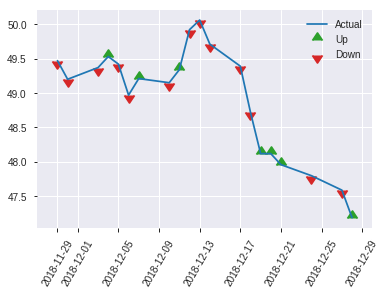


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.19820852347136378
RMSE: 0.44520615839334904
LogLoss: 0.5769818367535207
Null degrees of freedom: 250
Residual degrees of freedom: 130
Null deviance: 348.7926110092956
Residual deviance: 289.6448820502674
AIC: 531.6448820502674
AUC: 0.7616840233680467
pr_auc: 0.7351976098657724
Gini: 0.5233680467360935
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3106159358973614: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      49   75   0.6048   (75.0/124.0)
1      4    123  0.0315   (4.0/127.0)
Total  53   198  0.3147   (79.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.310616     0.756923  197
max f2                       0.260507     0.883171  210
max f0point5                 0.564794     0.700197  94
max accuracy                 0.408996     0.693227  159
max precision                0.90022      1         0
max recall                   0.260507     1         210
max specificity              0.90022      1         0
max absolute_mcc             0.310616     0.445496  197
max min_per_class_accuracy   0.503959     0.685039  125
max mean_per_class_accuracy  0.408996     0.691612  159

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 47.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.850827           1.97638   1.97638            1                0.873886  1                           0.873886            0.023622        0.023622                   97.6378   97.6378
    2        0.0239044                   0.834734           1.97638   1.97638            1                0.839331  1                           0.856608            0.023622        0.0472441                  97.6378   97.6378
    3        0.0318725                   0.809619           0.988189  1.72933            0.5              0.818012  0.875                       0.846959            0.00787402      0.0551181                  -1.1811   72.9331
    4        0.0438247                   0.791747           1.97638   1.79671            1                0.797516  0.909091                    0.833475            0.023622        0.0787402                  97.6378   79.6707
    5        0.0517928                   0.76612            1.97638   1.82435            1                0.77821   0.923077                    0.824972            0.015748        0.0944882                  97.6378   82.4349
    6        0.103586                    0.708855           1.52029   1.67232            0.769231         0.730306  0.846154                    0.777639            0.0787402       0.173228                   52.0291   67.232
    7        0.151394                    0.67994            1.15289   1.50829            0.583333         0.694732  0.763158                    0.751458            0.0551181       0.228346                   15.2887   50.8288
    8        0.203187                    0.642628           1.67232   1.5501             0.846154         0.663104  0.784314                    0.728936            0.0866142       0.314961                   67.232    55.01
    9        0.302789                    0.599864           1.42299   1.50829            0.72             0.624032  0.763158                    0.694428            0.141732        0.456693                   42.2992   50.8288
    10       0.40239                     0.551859           1.18583   1.42847            0.6              0.57509   0.722772                    0.664889            0.11811         0.574803                   18.5827   42.8471
    11       0.501992                    0.503959           1.10677   1.36464            0.56             0.52854   0.690476                    0.637836            0.110236        0.685039                   10.6772   36.4642
    12       0.601594                    0.433025           0.948661  1.29577            0.48             0.465141  0.655629                    0.609244            0.0944882       0.779528                   -5.13386  29.5771
    13       0.701195                    0.37492            0.869606  1.23524            0.44             0.401812  0.625                       0.579779            0.0866142       0.866142                   -13.0394  23.5236
    14       0.800797                    0.29718            1.10677   1.21926            0.56             0.335139  0.616915                    0.549351            0.110236        0.976378                   10.6772   21.9258
    15       0.900398                    0.224164           0.237165  1.11062            0.12             0.254259  0.561947                    0.516708            0.023622        1                          -76.2835  11.0619
    16       1                           0.0293919          0         1                  0                0.144564  0.505976                    0.479642            

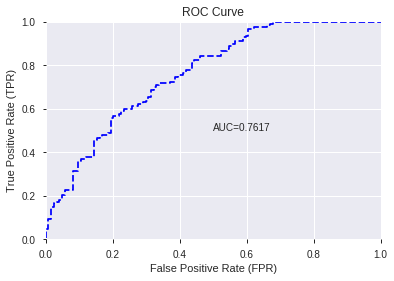

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


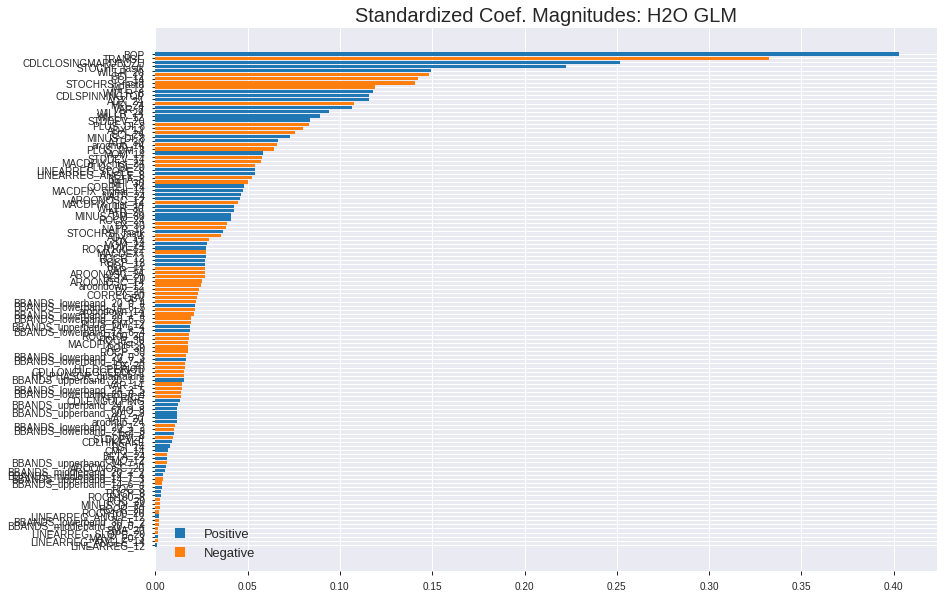

'log_likelihood'
--2019-09-03 02:57:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.17.208
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.17.208|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190903_025751_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190903_025751_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_83a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'TRANGE',
 'CDLCLOSINGMARUBOZU',
 'STOCHF_fastk',
 'WILLR_20',
 'CCI_12',
 'CCI_14',
 'STOCHRSI_fastd',
 'MFI_12',
 'WILLR_8',
 'CDLSPINNINGTOP',
 'ADX_24',
 'MFI_24',
 'VAR_8',
 'WILLR_24',
 'WILLR_12',
 'STDDEV_20',
 'PLUS_DI_8',
 'ADX_12',
 'CCI_24',
 'MINUS_DI_8',
 'ATR_30',
 'aroonup_14',
 'PLUS_DM_8',
 'MOM_14',
 'STDDEV_14',
 'MACDFIX_hist_24',
 'PLUS_DI_20',
 'LINEARREG_SLOPE_8',
 'LINEARREG_ANGLE_8',
 'BETA_8',
 'MFI_30',
 'CORREL_14',
 'MACDFIX_signal_14',
 'NATR_24',
 'AROONOSC_12',
 'MACDFIX_hist_14',
 'WILLR_30',
 'ATR_20',
 'MINUS_DM_30',
 'ROCR_24',
 'DX_30',
 'NATR_12',
 'STOCHRSI_fastk',
 'ADX_14',
 'DX_14',
 'MOM_24',
 'ROCR100_12',
 'MACDEXT',
 'ROCR_12',
 'ROCP_12',
 'ROC_12',
 'VAR_12',
 'AROONOSC_24',
 'BETA_20',
 'AROONOSC_14',
 'aroondown_12',
 'DX_24',
 'CORREL_20',
 'OBV',
 'BBANDS_lowerband_20_0_4',
 'BBANDS_lowerband_14_6_5',
 'aroondown_14',
 'BBANDS_lowerband_20_1_4',
 'BBANDS_lowerband_20_6_5',
 'PLUS_DM_12',
 'BBANDS_upperband_24_6_4',
 'BBANDS_

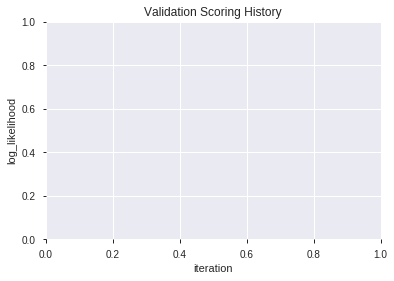

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190903_025805_model_1  0.767844  0.571924              0.301467  0.442316  0.195644
1               XGBoost_2_AutoML_20190903_025805  0.764161  0.576627              0.313659  0.443561  0.196746
2  XGBoost_grid_1_AutoML_20190903_025805_model_4  0.763970  0.584037              0.285338  0.446452  0.199319
3               XGBoost_3_AutoML_20190903_025805  0.763335  0.578078              0.289084  0.444283  0.197387
4  XGBoost_grid_1_AutoML_20190903_025805_model_6  0.756731  0.585903              0.309246  0.447755  0.200484
5  XGBoost_grid_1_AutoML_20190903_025805_model_7  0.753366  0.581960              0.318072  0.446901  0.199720
6  XGBoost_grid_1_AutoML_20190903_025805_model_2  0.749619  0.589979              0.333915  0.450117  0.202605
7               XGBoost_1_AutoML_20190903_025805  0.744983  0.587895              0.313754  0.449835  0.202351
8  XGBoost_grid_1_AutoML_20190903_025805_model_3  0.739713  0.591552              0.326137  0.451405  0.203767
9  XGBoost_grid_1_AutoML_20190903_025805_model_5  0.736284  0.590538              0.325470  0.453203  0.205393

variable  relative_importance  scaled_importance  percentage
0                        BOP          2127.283447           1.000000    0.245884
1                     TRANGE           770.742615           0.362313    0.089087
2               STOCHF_fastk           763.207153           0.358771    0.088216
3                      DX_24           249.410995           0.117244    0.028828
4         CDLCLOSINGMARUBOZU           244.279114           0.114831    0.028235
..                       ...                  ...                ...         ...
99                     VAR_8             3.235027           0.001521    0.000374
100                ROCR100_8             2.894047           0.001360    0.000335
101  BBANDS_lowerband_20_6_4             2.201039           0.001035    0.000254
102                  ROCP_12             2.121161           0.000997    0.000245
103             aroondown_14             1.696003           0.000797    0.000196

[104 rows x 4 columns]

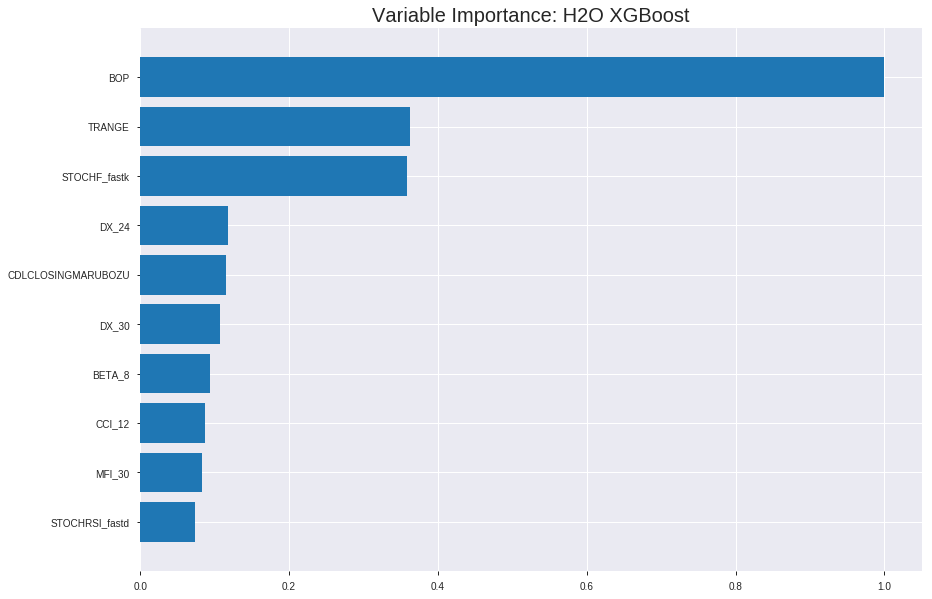

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190903_025805_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.14048913866389018
RMSE: 0.37481880777769166
LogLoss: 0.45048774285867477
Mean Per-Class Error: 0.16799558334476694
AUC: 0.9195495795683961
pr_auc: 0.9310256341599603
Gini: 0.8390991591367922
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5246457457542419: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      652  163  0.2      (163.0/815.0)
1      128  811  0.1363   (128.0/939.0)
Total  780  974  0.1659   (291.0/1754.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.524646     0.847883  196
max f2                       0.378464     0.912336  269
max f0point5                 0.63206      0.857258  139
max accuracy                 0.525879     0.834094  195
max precision                0.929309     1         0
max recall                   0.191986     1         352
max specificity              0.929309     1         0
max absolute_mcc             0.524646     0.666111  196
max min_per_class_accuracy   0.546905     0.826411  183
max mean_per_class_accuracy  0.525879     0.832004  195

Gains/Lift Table: Avg response rate: 53.53 %, avg score: 53.37 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102623                   0.88551            1.86794    1.86794            1                0.900252  1                           0.900252            0.0191693       0.0191693                  86.7945   86.7945
    2        0.0205245                   0.871654           1.86794    1.86794            1                0.878667  1                           0.889459            0.0191693       0.0383387                  86.7945   86.7945
    3        0.0302166                   0.859083           1.86794    1.86794            1                0.865019  1                           0.88162             0.0181044       0.056443                   86.7945   86.7945
    4        0.0404789                   0.849884           1.86794    1.86794            1                0.854008  1                           0.87462             0.0191693       0.0756124                  86.7945   86.7945
    5        0.050171                    0.839184           1.86794    1.86794            1                0.843624  1                           0.868632            0.0181044       0.0937167                  86.7945   86.7945
    6        0.100342                    0.803542           1.86794    1.86794            1                0.820916  1                           0.844774            0.0937167       0.187433                   86.7945   86.7945
    7        0.149943                    0.769242           1.86794    1.86794            1                0.786444  1                           0.825478            0.0926518       0.280085                   86.7945   86.7945
    8        0.200114                    0.738712           1.82549    1.8573             0.977273         0.753057  0.994302                    0.807322            0.0915868       0.371672                   82.5491   85.7301
    9        0.299886                    0.682502           1.68649    1.80047            0.902857         0.711333  0.963878                    0.775386            0.168264        0.539936                   68.6487   80.0471
    10       0.400228                    0.628329           1.42219    1.70563            0.761364         0.656407  0.913105                    0.745557            0.142705        0.682641                   42.2185   70.563
    11       0.5                         0.558996           1.20616    1.60596            0.645714         0.597246  0.859749                    0.715962            0.120341        0.802982                   20.6159   60.5964
    12       0.599772                    0.490688           0.917961   1.49151            0.491429         0.527086  0.798479                    0.684543            0.0915868       0.894569                   -8.20386  49.1515
    13       0.700114                    0.401332           0.689866   1.37662            0.369318         0.448733  0.736971                    0.650746            0.0692226       0.963791                   -31.0134  37.662
    14       0.799886                    0.327816           0.277523   1.23953            0.148571         0.364514  0.663578                    0.615043            0.027689        0.99148                    -72.2477  23.9527
    15       0.899658                    0.216761           0.0747178  1.11035            0.04             0.274182  0.594423                    0.577242            0.00745474      0.998935                   -92.5282  11.035
    16       1                           0.0544778          0.0106133  1                  0.00568182       0.142989  0.535348                    0.



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2098705581529938
RMSE: 0.4581163150914774
LogLoss: 0.6072595799184956
Mean Per-Class Error: 0.3241018796574352
AUC: 0.733018733018733
pr_auc: 0.7306102613620066
Gini: 0.466037466037466
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32569219172000885: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      77   166  0.6831   (166.0/243.0)
1      20   239  0.0772   (20.0/259.0)
Total  97   405  0.3705   (186.0/502.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.325692     0.71988   313
max f2                       0.220632     0.851279  353
max f0point5                 0.613653     0.695652  149
max accuracy                 0.598343     0.673307  161
max precision                0.836244     0.888889  16
max recall                   0.0789274    1         396
max specificity              0.908767     0.995885  0
max absolute_mcc             0.613653     0.359436  149
max min_per_class_accuracy   0.537208     0.656371  191
max mean_per_class_accuracy  0.598343     0.675898  161

Gains/Lift Table: Avg response rate: 51.59 %, avg score: 51.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.873824           1.61519   1.61519            0.833333         0.893505  0.833333                    0.893505            0.019305        0.019305                   61.5187   61.5187
    2        0.0219124                   0.849838           1.55058   1.58582            0.8              0.862622  0.818182                    0.879467            0.015444        0.034749                   55.0579   58.582
    3        0.0318725                   0.837683           1.93822   1.69595            1                0.841013  0.875                       0.867451            0.019305        0.0540541                  93.8224   69.5946
    4        0.0418327                   0.832917           1.55058   1.66133            0.8              0.835212  0.857143                    0.859775            0.015444        0.0694981                  55.0579   66.1335
    5        0.0517928                   0.82591            1.55058   1.64004            0.8              0.82688   0.846154                    0.853449            0.015444        0.0849421                  55.0579   64.0036
    6        0.101594                    0.75551            1.62811   1.63419            0.84             0.789269  0.843137                    0.821988            0.0810811       0.166023                   62.8108   63.4189
    7        0.151394                    0.703699           1.55058   1.60669            0.8              0.730223  0.828947                    0.791802            0.0772201       0.243243                   55.0579   60.6686
    8        0.201195                    0.68576            1.62811   1.61199            0.84             0.693966  0.831683                    0.767585            0.0810811       0.324324                   62.8108   61.1988
    9        0.300797                    0.64574            1.16293   1.46329            0.6              0.664632  0.754967                    0.733495            0.11583         0.440154                   16.2934   46.3295
    10       0.400398                    0.607029           1.31799   1.42715            0.68             0.628799  0.736318                    0.707451            0.131274        0.571429                   31.7992   42.715
    11       0.5                         0.546019           0.814054  1.30502            0.42             0.577466  0.673307                    0.681558            0.0810811       0.65251                    -18.5946  30.5019
    12       0.599602                    0.470882           1.00788   1.25566            0.52             0.505327  0.647841                    0.652284            0.100386        0.752896                   0.787645  25.566
    13       0.699203                    0.391003           0.814054  1.19275            0.42             0.43005   0.615385                    0.620626            0.0810811       0.833977                   -18.5946  19.2753
    14       0.798805                    0.327416           0.77529   1.1407             0.4              0.360767  0.588529                    0.588225            0.0772201       0.911197                   -22.471   14.07
    15       0.898406                    0.213092           0.658996  1.0873             0.34             0.274501  0.560976                    0.553444            0.0656371       0.976834                   -34.1004  8.72964
    16       1                           0.0601522          0.228026  1                  0.117647         0.153254  0.515936                    0.512787            0.


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-03 02:58:12  0.014 sec   0                  0.5              0.693147            0.5             0                  1                0.464652                         0.5                0.693147              0.5               0                    1                  0.484064
    2019-09-03 02:58:12  0.220 sec   5                  0.472575         0.639454            0.830777        0.83737            1.86794          0.249145                         0.483291           0.66006               0.713507          0.690827             1.61519            0.366534
    2019-09-03 02:58:12  0.308 sec   10                 0.453031         0.601921            0.845826        0.861814           1.86794          0.242873                         0.474302           0.64212               0.720848          0.71186              1.61519            0.360558
    2019-09-03 02:58:12  0.409 sec   15                 0.438138         0.573263            0.855055        0.871841           1.86794          0.22805                          0.467757           0.628808              0.726949          0.720987             1.61519            0.348606
    2019-09-03 02:58:12  0.495 sec   20                 0.42605          0.549873            0.866266        0.883002           1.86794          0.222349                         0.464352           0.621545              0.727545          0.71946              1.29215            0.358566
    2019-09-03 02:58:12  0.574 sec   25                 0.41697          0.531944            0.871909        0.886363           1.86794          0.220068                         0.461289           0.614991              0.732637          0.725697             1.29215            0.358566
    2019-09-03 02:58:12  0.654 sec   30                 0.408833         0.515826            0.878153        0.891555           1.86794          0.214937                         0.459767           0.611237              0.732137          0.729485             1.29215            0.368526
    2019-09-03 02:58:12  0.740 sec   35                 0.400869         0.500277            0.888667        0.902112           1.86794          0.194413                         0.458616           0.608717              0.733519          0.728795             1.61519            0.374502
    2019-09-03 02:58:12  0.821 sec   40                 0.394174         0.487232            0.896092        0.908233           1.86794          0.189282                         0.457317           0.605766              0.73603           0.73068              1.61519            0.374502
    2019-09-03 02:58:12  0.907 sec   45                 0.389163         0.477329            0.901532        0.913901           1.86794          0.191562                         0.457361           0.605935              0.73456           0.728345             1.29215            0.380478
    2019-09-03 02:58:13  0.986 sec   50                 0.384409         0.468167            0.90789         0.920902           1.86794          0.185291                         0.457101           0.605414              0.736856          0.732471             1.61519            0.38247
    2019-09-03 02:58:13  1.067 sec   55                 0.379229         0.458597            0.914322        0.926673           1.86794          0.179019                         0.45779            0.606722              0.734409          0.

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      2127.283447265625      1.0                    0.24588421166862245
TRANGE                   770.7426147460938      0.362313078558851      0.08908706569867475
STOCHF_fastk             763.2071533203125      0.3587707854829249     0.08821607175820144
DX_24                    249.41099548339844     0.11724389422762971    0.028828422505120084
CDLCLOSINGMARUBOZU       244.27911376953125     0.11483148335663665    0.028235248759885142
---                      ---                    ---                    ---
VAR_8                    3.235027313232422      0.001520731671837466   0.0003739239082892616
ROCR100_8                2.894047260284424      0.0013604427111038656  0.0003345113835400974
BBANDS_lowerband_20_6_4  2.2010393142700195     0.001034671386692356   0.00025440935825293034
ROCP_12                  2.1211605072021484     0.0009971217093465627  0.00024517648544034883
aroondown_14             1.6960029602050781     0.0007972623311600024  0.0001960342197903654


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7051792828685259)

('F1', 0.7572815533980582)

('auc', 0.7678435356870713)

('logloss', 0.571923862822533)

('mean_per_class_error', 0.29638684277368554)

('rmse', 0.4423163643670676)

('mse', 0.19564376618690052)

xgboost prediction progress: |████████████████████████████████████████████| 100%


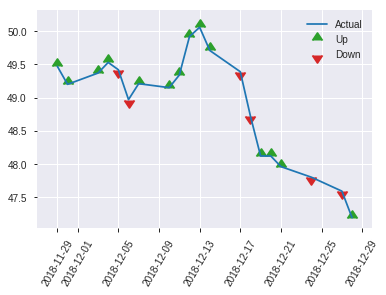


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.19564376618690052
RMSE: 0.4423163643670676
LogLoss: 0.571923862822533
Mean Per-Class Error: 0.29638684277368554
AUC: 0.7678435356870713
pr_auc: 0.7293549120983335
Gini: 0.5356870713741426
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3793053925037384: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      59   65   0.5242   (65.0/124.0)
1      10   117  0.0787   (10.0/127.0)
Total  69   182  0.2988   (75.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.379305     0.757282  181
max f2                       0.246083     0.877072  215
max f0point5                 0.617385     0.701403  92
max accuracy                 0.429364     0.705179  158
max precision                0.759979     0.892857  27
max recall                   0.246083     1         215
max specificity              0.903374     0.991935  0
max absolute_mcc             0.379305     0.444647  181
max min_per_class_accuracy   0.504946     0.669355  126
max mean_per_class_accuracy  0.429364     0.703613  158

Gains/Lift Table: Avg response rate: 50.60 %, avg score: 49.78 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.854429           1.31759   1.31759            0.666667         0.87987   0.666667                    0.87987             0.015748        0.015748                   31.7585   31.7585
    2        0.0239044                   0.831643           1.31759   1.31759            0.666667         0.844633  0.666667                    0.862251            0.015748        0.0314961                  31.7585   31.7585
    3        0.0318725                   0.822979           1.97638   1.48228            1                0.824222  0.75                        0.852744            0.015748        0.0472441                  97.6378   48.2283
    4        0.0438247                   0.813524           1.97638   1.61704            1                0.818722  0.818182                    0.843465            0.023622        0.0708661                  97.6378   61.7037
    5        0.0517928                   0.800079           0.988189  1.52029            0.5              0.801696  0.769231                    0.837039            0.00787402      0.0787402                  -1.1811   52.0291
    6        0.103586                    0.766139           1.97638   1.74833            1                0.781191  0.884615                    0.809115            0.102362        0.181102                   97.6378   74.8334
    7        0.151394                    0.719987           1.48228   1.66432            0.75             0.739829  0.842105                    0.787235            0.0708661       0.251969                   48.2283   66.4318
    8        0.203187                    0.685625           1.36826   1.58885            0.692308         0.701267  0.803922                    0.765322            0.0708661       0.322835                   36.8262   58.8853
    9        0.302789                    0.647115           1.18583   1.45628            0.6              0.663104  0.736842                    0.731698            0.11811         0.440945                   18.5827   45.6278
    10       0.40239                     0.587018           1.18583   1.38933            0.6              0.620397  0.70297                     0.704148            0.11811         0.559055                   18.5827   38.9335
    11       0.501992                    0.505602           1.10677   1.33327            0.56             0.539268  0.674603                    0.671434            0.110236        0.669291                   10.6772   33.3271
    12       0.601594                    0.445424           1.18583   1.30886            0.6              0.470823  0.662252                    0.63822             0.11811         0.787402                   18.5827   30.886
    13       0.701195                    0.388346           1.02772   1.26892            0.52             0.419055  0.642045                    0.607088            0.102362        0.889764                   2.77165   26.8924
    14       0.800797                    0.297005           0.711496  1.19959            0.36             0.350917  0.606965                    0.575226            0.0708661       0.96063                    -28.8504  19.9593
    15       0.900398                    0.202534           0.395276  1.11062            0.2              0.248287  0.561947                    0.53906             0.0393701       1                          -60.4724  11.0619
    16       1                           0.054842           0         1                  0                0.125245  0.505976                    0.497844          

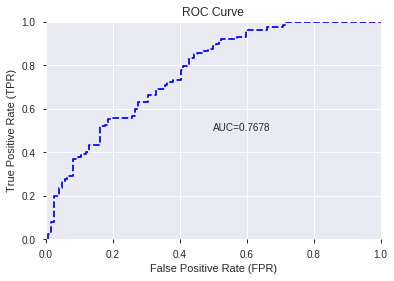

This function is available for GLM models only


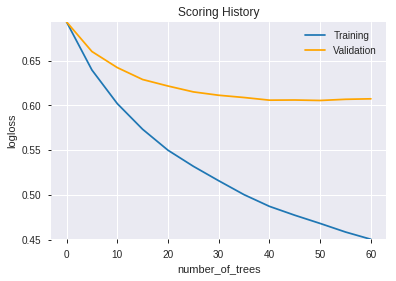

--2019-09-03 02:58:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.138.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.138.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190903_025805_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190903_025805_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_83a1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'STOCHF_fastk',
 'DX_24',
 'CDLCLOSINGMARUBOZU',
 'DX_30',
 'BETA_8',
 'CCI_12',
 'MFI_30',
 'STOCHRSI_fastd',
 'PLUS_DM_12',
 'aroonup_14',
 'ADX_24',
 'WILLR_12',
 'MFI_24',
 'STDDEV_8',
 'MINUS_DI_8',
 'PLUS_DI_8',
 'HT_PHASOR_quadrature',
 'VAR_12',
 'MACDFIX_hist_8',
 'ROC_8',
 'CORREL_14',
 'BBANDS_lowerband_24_3_5',
 'AROONOSC_20',
 'MINUS_DM_30',
 'WILLR_8',
 'NATR_24',
 'CCI_24',
 'MFI_12',
 'PLUS_DI_20',
 'ROC_20',
 'ATR_30',
 'PLUS_DM_8',
 'BBANDS_lowerband_14_7_4',
 'ROCR_24',
 'ATR_20',
 'BBANDS_lowerband_20_1_4',
 'CORREL_20',
 'MINUS_DI_24',
 'BETA_24',
 'BETA_20',
 'STDDEV_20',
 'WILLR_20',
 'WILLR_24',
 'MACDFIX_hist_14',
 'OBV',
 'DX_14',
 'STOCHRSI_fastk',
 'CCI_14',
 'ADX_14',
 'DX_20',
 'MOM_14',
 'ROC_12',
 'MACDFIX_signal_14',
 'BBANDS_middleband_14_7_4',
 'BBANDS_upperband_24_6_4',
 'HT_DCPERIOD',
 'NATR_12',
 'LINEARREG_ANGLE_12',
 'ADX_12',
 'LINEARREG_ANGLE_8',
 'LINEARREG_ANGLE_14',
 'LINEARREG_SLOPE_20',
 'WILLR_30',
 'BBANDS_lowerband_2

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.729
GLM             0.721
XGBoost         0.737
dtype: float64

DeepLearning    GLM  XGBoost
All          0.645  0.578    0.721
DLF          0.729  0.721    0.737
Fwe          0.725  0.701    0.701
RFE          0.717  0.693    0.705
XGBF         0.729  0.721    0.737





F1


DeepLearning    0.772
GLM             0.762
XGBoost         0.769
dtype: float64

DeepLearning    GLM  XGBoost
All          0.721  0.699    0.758
DLF          0.753  0.762    0.769
Fwe          0.762  0.742    0.752
RFE          0.770  0.757    0.757
XGBF         0.772  0.762    0.769





auc


DeepLearning    0.784
GLM             0.772
XGBoost         0.779
dtype: float64

DeepLearning    GLM  XGBoost
All          0.665  0.539    0.779
DLF          0.770  0.772    0.769
Fwe          0.784  0.763    0.760
RFE          0.783  0.762    0.768
XGBF         0.777  0.772    0.769





logloss


DeepLearning    0.925
GLM             1.829
XGBoost         0.573
dtype: float64

DeepLearning    GLM  XGBoost
All          0.925  1.829    0.563
DLF          0.573  0.575    0.573
Fwe          0.557  0.577    0.571
RFE          0.595  0.577    0.572
XGBF         0.584  0.575    0.573





mean_per_class_error


DeepLearning    0.358
GLM             0.427
XGBoost         0.301
dtype: float64

DeepLearning    GLM  XGBoost
All          0.358  0.427    0.280
DLF          0.272  0.281    0.265
Fwe          0.275  0.298    0.301
RFE          0.286  0.308    0.296
XGBF         0.273  0.281    0.265





rmse


DeepLearning    0.555
GLM             0.588
XGBoost         0.442
dtype: float64

DeepLearning    GLM  XGBoost
All          0.555  0.588    0.437
DLF          0.443  0.443    0.442
Fwe          0.435  0.445    0.442
RFE          0.451  0.445    0.442
XGBF         0.447  0.443    0.442





mse


DeepLearning    0.308
GLM             0.345
XGBoost         0.196
dtype: float64

DeepLearning    GLM  XGBoost
All          0.308  0.345    0.191
DLF          0.196  0.196    0.195
Fwe          0.189  0.198    0.196
RFE          0.204  0.198    0.196
XGBF         0.200  0.196    0.195

{'F1':       DeepLearning    GLM  XGBoost
 All          0.721    NaN      NaN
 DLF          0.753    NaN      NaN
 DLF            NaN  0.762      NaN
 DLF            NaN    NaN    0.769
 All            NaN  0.699      NaN
 All            NaN    NaN    0.758
 XGBF         0.772    NaN      NaN
 XGBF           NaN  0.762      NaN
 XGBF           NaN    NaN    0.769
 Fwe          0.762    NaN      NaN
 Fwe            NaN  0.742      NaN
 Fwe            NaN    NaN    0.752
 RFE          0.770    NaN      NaN
 RFE            NaN  0.757      NaN
 RFE            NaN    NaN    0.757,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.645    NaN      NaN
 DLF          0.729    NaN      NaN
 DLF            NaN  0.721      NaN
 DLF            NaN    NaN    0.737
 All            NaN  0.578      NaN
 All            NaN    NaN    0.721
 XGBF         0.729    NaN      NaN
 XGBF           NaN  0.721      NaN
 XGBF           NaN    NaN    0.737
 Fwe          0.725    NaN      NaN
 Fwe     